In [1]:
# Data wrangling
import pandas as pd

# Scientific
import numpy as np

# Hyperparameters tuning
try:
    from hpsklearn import HyperoptEstimator, any_classifier
    from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
except:
    !pip install hpsklearn
    from hpsklearn import HyperoptEstimator, any_classifier
    from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# Machine learning
try:
    #import xgboost as xgb
    from xgboost import XGBRegressor
except:
    !pip install xgboost
    from xgboost import XGBRegressor
    #import xgboost as xgb

    
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

try:
    from boruta import BorutaPy
except:
    !pip install boruta
    from boruta import BorutaPy

try:
    from boostaroota import BoostARoota
except:
    !pip install boostaroota
    from boostaroota import BoostARoota
    
import pickle
    
try:
    import shap
except:
    !pip install shap
    import shap
    
# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns # for correlation heatmap

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 KB 15.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for hpsklearn: filename=hpsklearn-0.1.0-py3-none-any.whl size=23912 sha256=3d1333f9ae2c5b603f65d731d240a1a9dc3ed86769b9c2bdde4f1cd462477259
  Stored in directory: /tmp/pip-ephem-wheel-cache-kbec5nu0/wheels/ed/78/df/b51d66188f755e2c237b6bcbe8f0ed408e2508eb648814d6fb
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=1043792e31a2bf405444eda3cf07585069009d10ac2ba85be9f5e8c4e26c29f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-kbec5nu0/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfull

### This cell sets the "seed" that all calculations will ensure all pseudorandom functions use the same initialization. This is extremely important for reproducibility.
The number itself does not really matter, just make sure you make note of it when you share your code. Small variations in the initialization of functions can cause (usually small) changes in the results. If you want to make sure reviewers and readers can reproduce your results exactly, THIS IS SUPER IMPORTANT!

In [5]:
seed = 100

### Hyperparameter Optimizer Definitions
This defines the hyperparameter optimizer that will be used later down. Modified from Ray Bell's Kaggle comp submission for the basics of the code (https://sites.google.com/view/raybellwaves/blog/using-xgboost-and-hyperopt-in-a-kaggle-comp)


In [6]:
# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(4, 25, 1, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(100, 10000, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(250, 350, 10, dtype=int)),
        'subsample':hp.quniform('subsample', 0.7, 0.9, 0.1),
        'eta':hp.quniform('eta', 0.01, 0.15, 0.01),
        'learning_rate':hp.quniform('learning_rate', 0.01, 0.05, 0.01),
        'objective':'reg:squarederror',
        'tree_method':'gpu_hist',
        'eval_metric': 'rmse',
    }


def score(params):
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=10)
    y_pred = model.predict(X_test).clip(0, 20)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    print(score)
    return {'loss': score, 'status': STATUS_OK}    
    

def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=1000)
    return best

'''
# Code in body
trials = Trials()
best_params = optimize(trials, space)


# Return the best parameters
space_eval(space, best_params)
'''

'\n# Code in body\ntrials = Trials()\nbest_params = optimize(trials, space)\n\n\n# Return the best parameters\nspace_eval(space, best_params)\n'

### This cell loads the data into a pandas dataframe in csv format

The following cell calls the top 5 columns of the loaded dataframe with the .head() method so that we can make sure it loaded correctly

In [7]:
df = pd.read_csv('Common_genes_ph_alldatasets.csv')

In [8]:
df

Unnamed: 0  pH.preference       ASV  X23S_rRNA_IVP  X5_nucleotid_C  \
0             1       3.724741   ASV_347              1               0   
1             2       3.839540  ASV_1159              1               0   
2             3       3.902705   ASV_215              0               1   
3             4       3.914741  ASV_2083              1               0   
4             5       3.984741  ASV_1484              1               0   
..          ...            ...       ...            ...             ...   
721         722       8.500000   ASV_961              1               0   
722         723       8.540000    ASV_43              0               1   
723         724       8.590000   ASV_684              0               0   
724         725       8.590000  ASV_1346              0               0   
725         726       8.750000   ASV_301              0               1   

     X5.FTHF_cyc.lig  AA_permease  AAA_25  AAA_assoc_C  AAL_decarboxy  ...  \
0                  1            0       1            1              0  ...   
1                  1            1       1            1              0  ...   
2                  1            1       0            0              0  ...   
3                  0            1       1            1              1  ...   
4                  0            1       0            1              1  ...   
..               ...          ...     ...          ...            ...  ...   
721                1            1       1            0              0  ...   
722                1            0       1            0              0  ...   
723                0            0       1            0              0  ...   
724                1            0       1            0              0  ...   
725                1            0       1            1              0  ...   

     YicC_N  YiiD_C  YitT_membrane  YlxR  YqcI_YcgG  Ysc84  Ytca  ZapB  \
0         1       0              0     1          0      0     1     0   
1         1       0              0     0          0      1     1     0   
2         1       1              0     0          0      1     1     1   
3         0       0              0     0          1      1     1     1   
4         1       0              0     0          1      1     1     0   
..      ...     ...            ...   ...        ...    ...   ...   ...   
721       1       0              0     0          0      0     0     1   
722       1       0              0     0          0      0     0     1   
723       0       0              0     1          0      0     0     0   
724       1       0              0     1          0      0     0     0   
725       0       0              1     1          0      0     0     0   

     zf.CDGSH  Zn_peptidase_2  
0           1               0  
1           1               0  
2           0               0  
3           1               0  
4           0               0  
..        ...             ...  
721         1               0  
722         1               0  
723         0               0  
724         0               0  
725         0               1  

[726 rows x 335 columns]

### Here we are going to get rid of columns we don't need

In the case of this tutorial using Josep Ramoneda's datam we don't need the 'Unnamed: 0' column as it just indicates the order in which the observation was loaded into the csv contains no useful data. Insofar as predicting our target variable is concerned, 'ASV' is also not helpful. In later stages of data analysis if you want to actually look at the ASV's other metadata, the table will remain in order so a simple merge of the ASV list will restore the data. As such, we will also store those ASVs in their own list.

The following cell calls the top 5 rows of the dataframe with the dropped columns, again to make sure we did it correctly.

In [9]:
ASV_list = df['ASV']
df = df.drop(['Unnamed: 0','ASV'], axis=1)

In [10]:
df.head()

pH.preference  X23S_rRNA_IVP  X5_nucleotid_C  X5.FTHF_cyc.lig  AA_permease  \
0       3.724741              1               0                1            0   
1       3.839540              1               0                1            1   
2       3.902705              0               1                1            1   
3       3.914741              1               0                0            1   
4       3.984741              1               0                0            1   

   AAA_25  AAA_assoc_C  AAL_decarboxy  ABATE  Abhydrolase_11  ...  YicC_N  \
0       1            1              0      0               1  ...       1   
1       1            1              0      0               0  ...       1   
2       0            0              0      0               1  ...       1   
3       1            1              1      1               1  ...       0   
4       0            1              1      1               1  ...       1   

   YiiD_C  YitT_membrane  YlxR  YqcI_YcgG  Ysc84  Ytca  ZapB  zf.CDGSH  \
0       0              0     1          0      0     1     0         1   
1       0              0     0          0      1     1     0         1   
2       1              0     0          0      1     1     1         0   
3       0              0     0          1      1     1     1         1   
4       0              0     0          1      1     1     0         0   

   Zn_peptidase_2  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 333 columns]

Might as well make a list of the genes as well, we may need it later for interpretability. Make sure to get rid of the target variable with .pop(); it's super easy here since it's out first column. If it's not the first column, you'll need to modify wither this or the dataframe itself.

In [11]:
gene_list = list(df)
gene_list.pop(0)

'pH.preference'

### Now that our data is loaded and trimed down to its potentially useful elements, it's time to prep it for machine learning algorithms

This is necessary for supervised machine learning techniques as you need the test set as a "ground truth" against which to test your model. Remember, with supervised methods of machine learning, we are using labled data to regress or classify.


As for unsupervised machine learning, this is a bit more complicated as they use unlabled data to cluster data together or reconstruct data from itself. However, it can still be helpful as unsupervised learning is frequently followed by supervised learning and you can use the test set to validate as you would with supervised ground truth comparisons.

In [12]:
#Split data into training features and labels
X, y = df.loc[:, df.columns != 'pH.preference'], df['pH.preference']

### Set size of test set as a percentage of the full dataset

We are setting our test size with the "test_size" variable here. In the case of Josep's data, we only have 723 observations which is honestly not a lot. In order to give the algorithms the best chance to reach a high performance, we are only setting the test size to 10% of the dataset. If you have thousands of observations, you might want to bump that up to avoid overfitting and improve the quality of your validation.

In [13]:
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [14]:
# Complex Model
'''
model = XGBRegressor(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=600,
    colsample_bytree=0.5,
    min_child_weight=330,
    subsample=0.8,    
    eta=0.2,
    objective='reg:squarederror',
    tree_method='gpu_hist')


model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds=10)
'''

'\nmodel = XGBRegressor(\n    max_depth=5,\n    learning_rate=0.05,\n    n_estimators=600,\n    colsample_bytree=0.5,\n    min_child_weight=330,\n    subsample=0.8,    \n    eta=0.2,\n    objective=\'reg:squarederror\',\n    tree_method=\'gpu_hist\')\n\n\nmodel.fit(\n    X_train, \n    y_train, \n    eval_metric="rmse", \n    eval_set=[(X_train, y_train), (X_test, y_test)], \n    verbose=True, \n    early_stopping_rounds=10)\n'

### XGBoost

XGBoost is a popular and high-performance algorithm for gradient boosting decision trees. Gradient boosting is particularly good for situations where we don't have a ton of observations which is a frequent problem for us folks in ecology.


Here, we are going to start with a basic model in order to get a performance baseline and save some time. 


#### Additionally, this example is for a regression

If your target variable is a class and not a continuous, you should use XGBClassifier instead. Also, remember to one-hot encode your classes. If for some reason you don't want to or can't one-hot encode class-based variables, consider using CatBoost instead of XGBoost (https://catboost.ai/en/docs/concepts/python-quickstart)

In [15]:
# Quick model
model = XGBRegressor(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

### We'll run a quick .predict() against the test set to determine root mean square error (RMSE) and mean absolute error (MAE)

Below is a k-fold method that's been block quoted out with '''...'''  but I'd stick to unsupervised methods for that

In [13]:
# Predict the model
pred = model.predict(X_test)
 
# MAE Computation
scores_MAE = mean_absolute_error(y_test, pred)

# RMSE Computation
scores_RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f, MAE : % f" % (scores_RMSE, scores_MAE))

RMSE :  1.015496, MAE :  0.743749


In [14]:
'''
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_MAE = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores_MAE = np.absolute(scores)

scores_RMSE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores_RMSE = np.absolute(scores_RMSE)

print('Mean MAE: %.3f (%.3f)' % (scores_MAE.mean(), scores_MAE.std()))
print('Mean RMSE: %.3f (%.3f)' % (scores_RMSE.mean(), scores_RMSE.std()))
'''

"\n# define model evaluation method\ncv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n# evaluate model\nscores_MAE = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)\n# force scores to be positive\nscores_MAE = np.absolute(scores)\n\nscores_RMSE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)\n# force scores to be positive\nscores_RMSE = np.absolute(scores_RMSE)\n\nprint('Mean MAE: %.3f (%.3f)' % (scores_MAE.mean(), scores_MAE.std()))\nprint('Mean RMSE: %.3f (%.3f)' % (scores_RMSE.mean(), scores_RMSE.std()))\n"

### Hyperparameter optimization (optional and beware)

Okay, so here we use the definitions from the top of the notebook to perform hyperparameter optimization. Remember when I said "You can set all kinds of hyperparameters for XGBoost" up above? Well you can automate it! Instead of randomly guesstimating the best parameters for your model, why not check a wide array of possible combonations of parameters and pick the best one? 


Well...it's incredibly computationally intensive. Unless you're using an expensive GPU, a cluster, monopolizing the lab server, or something of the sort, hyperparameter optimization will take a very long time. Also, make sure you have your search methods well thought out and defined in the function definition at the top of the notebook; otherwise you may just end up wasting time.

Decide if it's worth it for you, if not, go ahead and skip to "SHAP analysis" a few cells below this.

In [15]:
'''
trials = Trials()
best_params = optimize(trials, space)
'''

'\ntrials = Trials()\nbest_params = optimize(trials, space)\n'

The following function returns the best parameters; go ahead and plug these into a new XGBoost model

In [16]:
'''
# Return the best parameters
space_eval(space, best_params)
'''

'\n# Return the best parameters\nspace_eval(space, best_params)\n'

### More complex model

You can set all kinds of hyperparameters for XGBoost (https://xgboost.readthedocs.io/en/stable/parameter.html) but that's up to you; I'd recommend playing around with them a little to see if you can get your scores up. I just took some numbers that work reasonably well and entered them here if you want to skip tuning and move on; they can be made better, though!

In [17]:
model = XGBRegressor(
    max_depth=5,
    colsample_bytree=0.6,
    n_estimators=300,
    min_child_weight=10,
    subsample=0.9,    
    eta=0.03,
    objective='reg:squarederror',
    #objective='reg:tweedie', tweedie_variance_power=1.54,
    #tree_method='gpu_hist'
    )


model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False, 
    early_stopping_rounds=10)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False, eta=0.03,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0299999993, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [18]:
'''
model = XGBRegressor(
    max_depth=9,
    colsample_bytree=0.6,
    n_estimators=300,
    min_child_weight=10,
    subsample=0.9,    
    eta=0.03,
    objective='reg:squarederror' #,
    #objective='reg:tweedie', tweedie_variance_power=1.53,
    #tree_method='gpu_hist'
)


model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False, 
    early_stopping_rounds=10)
'''

'\nmodel = XGBRegressor(\n    max_depth=9,\n    colsample_bytree=0.6,\n    n_estimators=300,\n    min_child_weight=10,\n    subsample=0.9,    \n    eta=0.03,\n    objective=\'reg:squarederror\' #,\n    #objective=\'reg:tweedie\', tweedie_variance_power=1.53,\n    #tree_method=\'gpu_hist\'\n)\n\n\nmodel.fit(\n    X_train, \n    y_train, \n    eval_metric="rmse", \n    eval_set=[(X_train, y_train), (X_test, y_test)], \n    verbose=False, \n    early_stopping_rounds=10)\n'

Run the predictor and compare to the "quick and easy" model

In [19]:
# Predict the model
pred = model.predict(X_test)
 
# MAE Computation
scores_MAE = mean_absolute_error(y_test, pred)

# RMSE Computation
scores_RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f, MAE : % f" % (scores_RMSE, scores_MAE))

RMSE :  0.906730, MAE :  0.622373


In [89]:
'''
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_MAE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores_MAE = np.absolute(scores_MAE)
print('Mean MAE: %.3f (%.3f)' % (scores_MAE.mean(), scores_MAE.std()) )
'''

"\n# define model evaluation method\ncv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n# evaluate model\nscores_MAE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)\n# force scores to be positive\nscores_MAE = np.absolute(scores_MAE)\nprint('Mean MAE: %.3f (%.3f)' % (scores_MAE.mean(), scores_MAE.std()) )\n"

## Interpretation
### Let's try graphing the predicted vs true values!

First, we join them into the same dataframe

In [21]:
#perm_predicted_vs_true = pd.merge(pd.DataFrame(pred_perm_subset),pd.DataFrame(y_perm_test))

predicted_vs_true = pd.DataFrame(y_test) 
#predictions = pd.DataFrame(pred_perm_subset)
predicted_vs_true['Predicted pH (XGBoost)'] = pred

#pd.concat([pd.DataFrame(pred_perm_subset),pd.DataFrame(y_perm_test)], axis=1, ignore_index=True)

#shap_value_sums
#y_df = pd.DataFrame(y)
#shap_valuecomp=pd.merge(y_df,shap_value_sums,left_index=True, right_index=True)
#shap_valuecomp
predicted_vs_true = predicted_vs_true.sort_index(ascending=True)
predicted_vs_true

pH.preference  Predicted pH (XGBoost)
19        4.348965                5.027437
24        4.469885                5.339875
40        5.022421                5.147266
41        5.024741                5.895385
48        5.149540                4.767467
..             ...                     ...
670       7.940000                7.788762
678       2.050000                5.759346
701       7.460000                7.545578
710       8.450000                7.472828
719       8.490000                7.329669

[73 rows x 2 columns]

### SHAP analysis

SHAP scores can allow us to learn a lot about our model. In fact, it is probably the best way to interperate and explain machine learning models - even super black-boxy ones like deep neural networks. It's a game-theory based method of analysis that shows how important each feature is to the model predictions.

Let's start by using SHAP scores to graph all test predictions vs all test true-values!

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


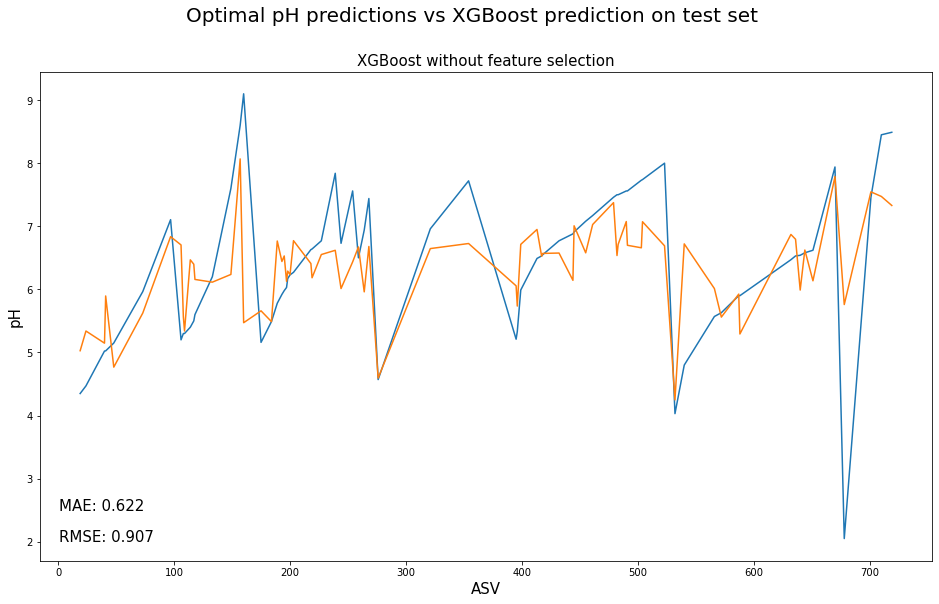

In [22]:
explainer = shap.TreeExplainer(model)
shap_values_forFE = explainer.shap_values(X_test)
shap_values = explainer(X_test)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals+shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y_test)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)

#shap_valuecomp.plot(use_index=True)
plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH'], label = "line 1")



plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs XGBoost prediction on test set", fontsize=20)
plt.title("XGBoost without feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 2, "RMSE: %.3f" % scores_RMSE, fontsize=15)
plt.text(1, 2.5, "MAE: %.3f" % scores_MAE, fontsize=15)

plt.savefig('xgboost_testset.png')
plt.show()

SHAP values allow us to graph against all values, even though the predictor was only trained on 90% of the data. It looks pretty good! 

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


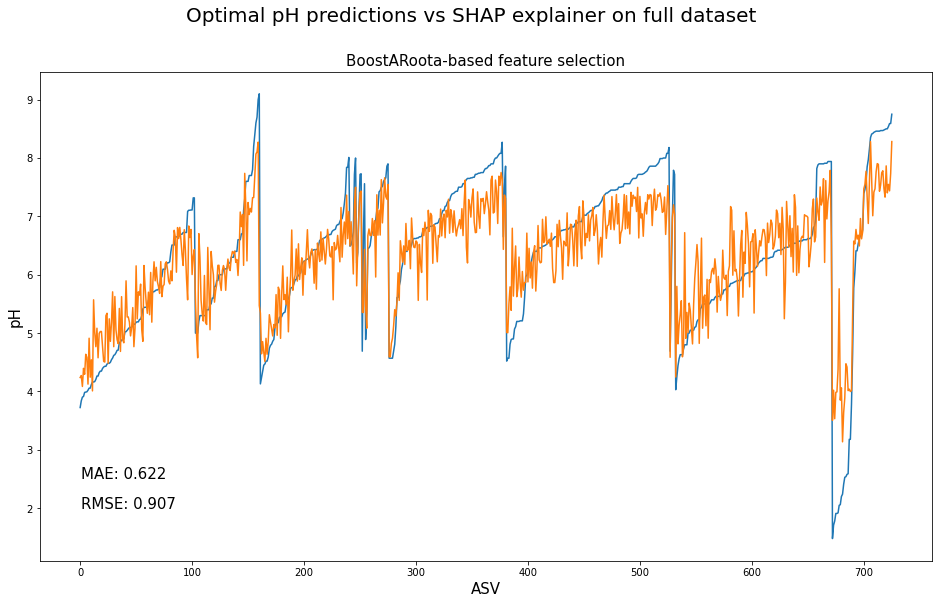

In [23]:
explainer = shap.TreeExplainer(model)
shap_values_forFE = explainer.shap_values(X)
shap_values = explainer(X)



# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals+shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH (XGBoost)'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)
#shap_valuecomp = shap_valuecomp.sort_values(by='pH.preference', ascending=False).reset_index()

#shap_valuecomp.plot(use_index=True)
plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH (XGBoost)'], label = "line 1")


plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs SHAP explainer on full dataset", fontsize=20)
plt.title("BoostARoota-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 2, "RMSE: %.3f" % scores_RMSE, fontsize=15)
plt.text(1, 2.5, "MAE: %.3f" % scores_MAE, fontsize=15)

plt.savefig('xgboost_fullset.png')
plt.show()

### The following section, which is commented out, can be used to look at each feature to see how it influences the pH score.

There is also a good deal of exploratory work that can be done, with some examples looking at things like kurtosis and range. I would consider this to be fairly specific to this project but you may find it interesting.

Otherwise, skip to SHAP summary plot below.

In [24]:
'''
vals = shap_values.values
vals_abs = np.abs(vals)
val_mean = np.mean(vals_abs, axis=0)
#val_final = np.mean(val_mean, axis=1)
feature_importance = pd.DataFrame(list(zip(shap_values.feature_names, val_mean)), columns=['features', 'importance'])
#feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
feature_importance
'''

"\nvals = shap_values.values\nvals_abs = np.abs(vals)\nval_mean = np.mean(vals_abs, axis=0)\n#val_final = np.mean(val_mean, axis=1)\nfeature_importance = pd.DataFrame(list(zip(shap_values.feature_names, val_mean)), columns=['features', 'importance'])\n#feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)\nfeature_importance\n"

In [25]:
'''
shap_table = pd.DataFrame(arr, columns=gene_list)
shap_table = shap_table.T
shap_table.columns = ASV_list
#shap_table = shap_table.apply(pd.to_numeric, errors='coerce')
metrics = pd.DataFrame(index=shap_table.index)
metrics['mean_positive'] = shap_table.where(shap_table>0).mean(axis=1)
metrics['mean_negative'] = shap_table.where(shap_table<=0).mean(axis=1)
metrics['std_positive'] = shap_table.where(shap_table>0).std(axis=1)
metrics['std_negative'] = shap_table.where(shap_table<=0).std(axis=1)
metrics['count_positive'] = shap_table.where(shap_table>0).count(axis=1)
metrics['count_negative'] = shap_table.where(shap_table<=0).count(axis=1)
metrics['kurtosis'] = shap_table.kurtosis(axis=1)
metrics['range'] = np.abs(shap_table.max(axis=1)) + np.abs(shap_table.min(axis=1))


vals = shap_values.values
vals_abs = np.abs(vals)
val_mean = np.mean(vals_abs, axis=0)
metrics['importance'] = val_mean
#val_final = np.mean(val_mean, axis=1)
#feature_importance = pd.DataFrame(list(zip(shap_values.feature_names, val_mean)), columns=['features', 'importance'])
#feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
#feature_importance


#shap_table.insert(0, "ASV", ASV_list, True)


shap_table
'''

'\nshap_table = pd.DataFrame(arr, columns=gene_list)\nshap_table = shap_table.T\nshap_table.columns = ASV_list\n#shap_table = shap_table.apply(pd.to_numeric, errors=\'coerce\')\nmetrics = pd.DataFrame(index=shap_table.index)\nmetrics[\'mean_positive\'] = shap_table.where(shap_table>0).mean(axis=1)\nmetrics[\'mean_negative\'] = shap_table.where(shap_table<=0).mean(axis=1)\nmetrics[\'std_positive\'] = shap_table.where(shap_table>0).std(axis=1)\nmetrics[\'std_negative\'] = shap_table.where(shap_table<=0).std(axis=1)\nmetrics[\'count_positive\'] = shap_table.where(shap_table>0).count(axis=1)\nmetrics[\'count_negative\'] = shap_table.where(shap_table<=0).count(axis=1)\nmetrics[\'kurtosis\'] = shap_table.kurtosis(axis=1)\nmetrics[\'range\'] = np.abs(shap_table.max(axis=1)) + np.abs(shap_table.min(axis=1))\n\n\nvals = shap_values.values\nvals_abs = np.abs(vals)\nval_mean = np.mean(vals_abs, axis=0)\nmetrics[\'importance\'] = val_mean\n#val_final = np.mean(val_mean, axis=1)\n#feature_importanc

In [26]:
'''
#shap_table.loc[["AAA_assoc_C","DPRP","Gpr1_Fun34_YaaH","Nramp","GSDH","Endonuclease_5","FixH"]]
#metrics.loc[["AAA_assoc_C","DPRP","Gpr1_Fun34_YaaH","Nramp","GSDH","Endonuclease_5","FixH","AA_permease"]]
plttbl = shap_table.loc[["AAA_assoc_C","DPRP","Gpr1_Fun34_YaaH","Endonuclease_5","AA_permease"]].T
plttbl = plttbl.reset_index(drop=True)
#shap_table.loc[["DPRP","Gpr1_Fun34_YaaH","Endonuclease_5"]].T.plot(use_index=True)
#plt.show()

plt.figure(figsize=(16, 9))
plt.plot(plttbl['AA_permease'], label = "AA_permease")
#plt.plot(plttbl['DPRP'], label = "DPRP")
plt.show()
'''

'\n#shap_table.loc[["AAA_assoc_C","DPRP","Gpr1_Fun34_YaaH","Nramp","GSDH","Endonuclease_5","FixH"]]\n#metrics.loc[["AAA_assoc_C","DPRP","Gpr1_Fun34_YaaH","Nramp","GSDH","Endonuclease_5","FixH","AA_permease"]]\nplttbl = shap_table.loc[["AAA_assoc_C","DPRP","Gpr1_Fun34_YaaH","Endonuclease_5","AA_permease"]].T\nplttbl = plttbl.reset_index(drop=True)\n#shap_table.loc[["DPRP","Gpr1_Fun34_YaaH","Endonuclease_5"]].T.plot(use_index=True)\n#plt.show()\n\nplt.figure(figsize=(16, 9))\nplt.plot(plttbl[\'AA_permease\'], label = "AA_permease")\n#plt.plot(plttbl[\'DPRP\'], label = "DPRP")\nplt.show()\n'

In [27]:
'''
shap_metrics = pd.concat([shap_table, metrics], axis=1)
shap_metrics.to_csv('shap_metrics_XGBoost.csv')
'''

"\nshap_metrics = pd.concat([shap_table, metrics], axis=1)\nshap_metrics.to_csv('shap_metrics_XGBoost.csv')\n"

In [28]:
'''
shap_metrics.loc[(shap_metrics['importance'] > 0.010000) & (shap_metrics['kurtosis'] > 0.100000)]
'''

"\nshap_metrics.loc[(shap_metrics['importance'] > 0.010000) & (shap_metrics['kurtosis'] > 0.100000)]\n"

### SHAP summary plot

So how do all of our features, genes in this case, impact the predicted pH of each ASV?

In this graph,we are using one-hot encoded classes instead of continuous features, so "red" represents gene present (1) and "blue" represents gene absent (0). Because it is a regression, a gene's presence or absence with nearly zero impact will actually show as a small impact if the opposite situation (present for absent or absent for present) has a strong impact. For example, "endonuclease_5" in the plot below effectivly has zero impact on pH optimum if the gene is absent, but can have a fairly substantial impact (in the positice direction) if present. AAA_assoc_C has the opposite impact.

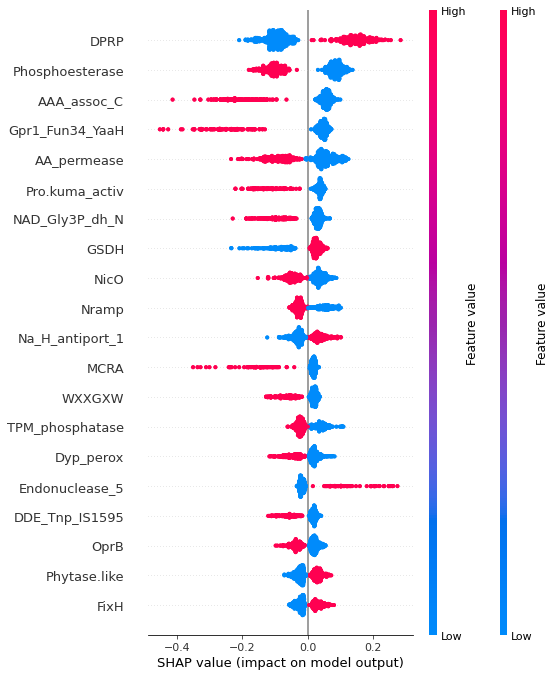

In [29]:
fig = shap.summary_plot(shap_values, X, show=False)
plt.savefig('xgboost_summary.png')

shap.summary_plot(shap_values, X)


# Feature Selection

I've noticed that in some papers, authors stop at citing the error of functions, R^2 values, etc, with maybe a PCA thrown on top. I firmly believe this is insufficent as it allows noise to enter into the model, reduced the clarity of the model, and ultimatly obfuscates what is actually happening in a natural process.

#### What is feature selection?

Feature selection is when you select a subset of features (variables) from your data. This serves to reduce model complexity (going from hundreds of variables to a few tens in the case of Josep's data) and reduce the error introduced by noise (called generalization error). As you can imagine, a model with fewer variables and especially without irrelevant variables will be more efficent and more powerful.

#### Feature selection methodologies

There are quite a few methods to do feature selection. For random forests, such as this pipline, we will stick to feature importance techniques though K-nearest neighbors, sequential forward/backward search, L1 norm regularization, etc. can also be used with other models.

## Feature Selection Method One
### Ranking features based on gain

XGBoost built in feature importance metric. MDI counts the times a feature is used to split a node, weighted by the number of samples it splits. Near as I can tell gain is basically MDI but Gini impurity is replaced by the objective function of the gradient boosting model.

We are going to run the .feature_importances_.argsort() on our model from above and rank them based on our training set.

In [119]:
sorted_idx = model.feature_importances_.argsort()

In [120]:
X_train.columns[sorted_idx]

Index(['Ribosomal_L18p', 'Ribosomal_L6', 'Phospholip_B', 'Ig_3', 'GvpL_GvpF',
       'Peptidase_S55', 'CBM9_1', 'PSCyt2', 'X23S_rRNA_IVP', 'AIG2_2',
       ...
       'BrnA_antitoxin', 'Glucodextran_N', 'Nramp', 'Nudix_N', 'DctP',
       'Gpr1_Fun34_YaaH', 'Peptidase_C10', 'WXXGXW', 'Phosphoesterase',
       'Pro.kuma_activ'],
      dtype='object', length=332)

### Plot the gain

You see some features (genes in this case) towards the top have relativly high importance, and some actually have pretty dand low importance. Lets get rid of some of these unimportant features!

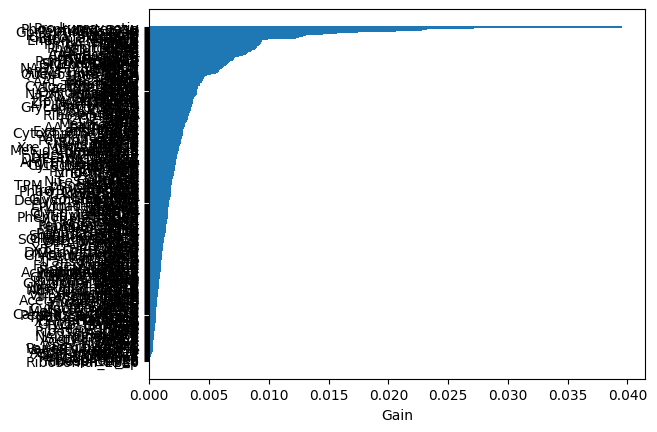

In [121]:
fig=plt.figure()
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx], height=2)
plt.xlabel("Gain")
fig.savefig('XGBoost_Gain_2.png', bbox_inches='tight', pad_inches = 0, dpi=200)
plt.show()

First, lets get a list of our importances in tabular format. 

In [122]:
result=list(reversed(model.feature_importances_[sorted_idx]))

In [123]:
gainlist = pd.DataFrame()
gainlist['gene'] = list(reversed(X_train.columns[sorted_idx]))
gainlist['mdi'] = list(reversed(model.feature_importances_[sorted_idx]))

### Remove all the genes with a feature importance below the mean and create a new dataframe to train XGBoost on only including those genes with a high-enough importance

This is an arbitray cutoff; feel free to play around with it

In [124]:
mdi_mean = gainlist['mdi'].mean()
gainlist_subset = gainlist.loc[gainlist['mdi'] > mdi_mean]

In [125]:
gainlist_subset_list = gainlist_subset['gene'].tolist()
gainlist_subset_list.append('pH.preference')

In [126]:
gainlist.loc[gainlist['gene'].isin(gainlist_subset_list)].to_csv('gain_selection.csv')

In [127]:
gainlist_subset_df = df[gainlist_subset_list]

In [128]:
#Split data into training features and labels
X_gain, y_gain = gainlist_subset_df.loc[:, gainlist_subset_df.columns != 'pH.preference'], gainlist_subset_df['pH.preference']

In [129]:
test_size = 0.1
X_gain_train, X_gain_test, y_gain_train, y_gain_test = train_test_split(X_gain, y_gain, test_size=test_size, random_state=seed)

In [130]:
# Quick model
model_gain_subset = XGBRegressor(learning_rate = 0.05, n_estimators=300, max_depth=5)
model_gain_subset.fit(X_gain_train, y_gain_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Interestingly, that does not seem to have helped much.

In [131]:
# Predict the model
pred_gain_subset = model_gain_subset.predict(X_gain_test)
 
# MAE Computation
scores_gain_subset_MAE = mean_absolute_error(y_gain_test, pred_gain_subset)

# RMSE Computation
scores_gain_subset_RMSE = np.sqrt(mean_squared_error(y_gain_test, pred_gain_subset))
print("RMSE : % f, MAE : % f" % (scores_gain_subset_RMSE, scores_gain_subset_MAE))

RMSE :  0.969729, MAE :  0.672808


### Running the SHAP analysis as we did for the basic model

See the XGBoost section at the top for a refresher

In [132]:
#perm_predicted_vs_true = pd.merge(pd.DataFrame(pred_perm_subset),pd.DataFrame(y_perm_test))

gain_predicted_vs_true = pd.DataFrame(y_gain_test) 
#predictions = pd.DataFrame(pred_perm_subset)
gain_predicted_vs_true['Predicted pH (XGBoost)'] = pred_gain_subset

#pd.concat([pd.DataFrame(pred_perm_subset),pd.DataFrame(y_perm_test)], axis=1, ignore_index=True)

#shap_value_sums
#y_df = pd.DataFrame(y)
#shap_valuecomp=pd.merge(y_df,shap_value_sums,left_index=True, right_index=True)
#shap_valuecomp
gain_predicted_vs_true = gain_predicted_vs_true.sort_index(ascending=True)
gain_predicted_vs_true

pH.preference  Predicted pH (XGBoost)
19        4.348965                4.327611
24        4.469885                5.447534
40        5.022421                5.142433
41        5.024741                6.018596
48        5.149540                4.524480
..             ...                     ...
670       7.940000                7.994191
678       2.050000                5.851550
701       7.460000                8.087313
710       8.450000                7.939686
719       8.490000                7.312209

[73 rows x 2 columns]

In [1]:
explainer = shap.TreeExplainer(model_gain_subset)
shap_values_forFE = explainer.shap_values(X_gain_test)
shap_values = explainer(X_gain_test)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals+shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y_gain_test)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)

#shap_valuecomp.plot(use_index=True)
plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH'], label = "line 1")

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs XGBoost prediction on test set", fontsize=20)
plt.title("Gain-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 2, "RMSE: %.3f" % scores_gain_subset_RMSE, fontsize=15)
plt.text(1, 2.5, "MAE: %.3f" % scores_gain_subset_MAE, fontsize=15)

plt.savefig('gain_testset.png')
plt.show()

NameError: name 'shap' is not defined

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


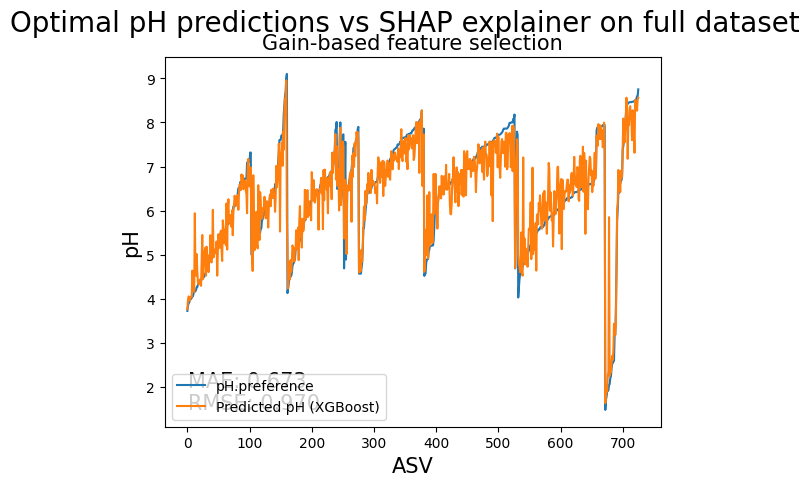

In [138]:
explainer = shap.TreeExplainer(model_gain_subset)
shap_values_forFE = explainer.shap_values(X_gain)
shap_values = explainer(X_gain)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals+shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH (XGBoost)'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)

#shap_valuecomp.plot(use_index=True)
plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH'], label = "line 1")

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs SHAP explainer on full dataset", fontsize=20)
plt.title("Gain-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 1.5, "RMSE: %.3f" % scores_gain_subset_RMSE, fontsize=15)
plt.text(1, 2.0, "MAE: %.3f" % scores_gain_subset_MAE, fontsize=15)

plt.savefig('gain_fullset.png')
plt.show()

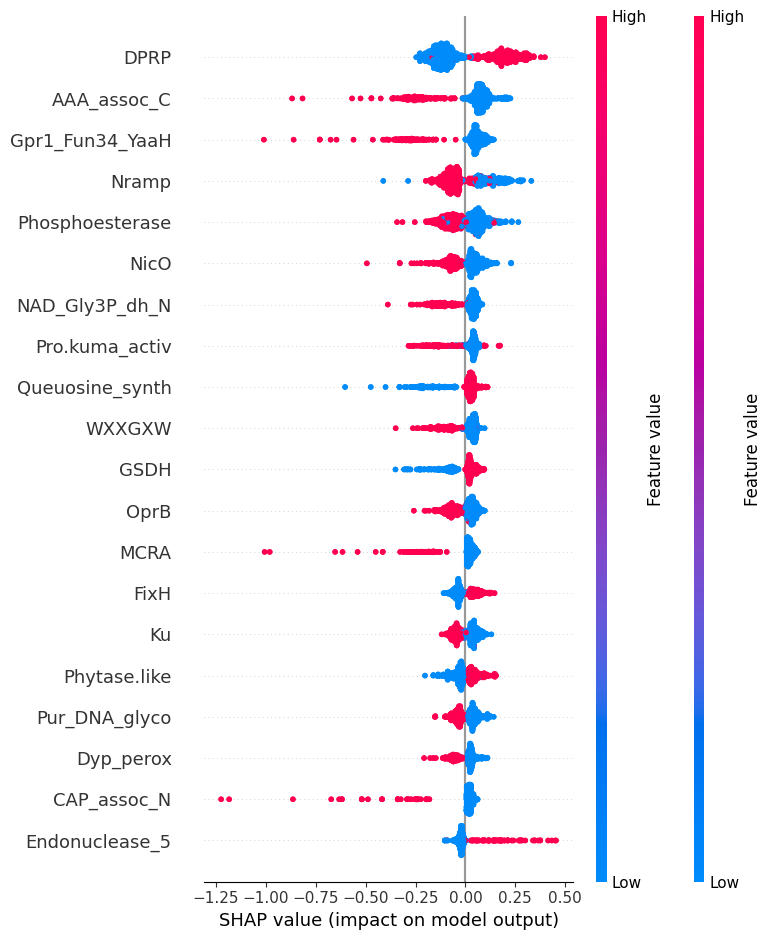

In [139]:
fig = shap.summary_plot(shap_values, X_gain, show=False)
plt.savefig('gain_summary.png')

shap.summary_plot(shap_values, X_gain)


In [48]:
print('Mean MAE of original model: %.3f Mean MAE of model based on gain subset: %.3f' % (scores_MAE, scores_gain_subset_MAE))
print('Mean RMSE of model based on gain is %.3f lower than RMSE of original model' % (scores_MAE-scores_gain_subset_MAE)) 
print('Mean RMSE of original model: %.3f Mean RMSE of model based on gain subset: %.3f' % (scores_RMSE, scores_gain_subset_RMSE))
print('Mean RMSE of model based on gain is %.3f lower than RMSE of original model' % (scores_RMSE-scores_gain_subset_RMSE)) 

Mean MAE of original model: 0.622 Mean MAE of model based on gain subset: 0.702
Mean RMSE of model based on gain is -0.080 lower than RMSE of original model
Mean RMSE of original model: 0.907 Mean RMSE of model based on gain subset: 0.985
Mean RMSE of model based on gain is -0.078 lower than RMSE of original model


## Feature Selection Method Two
### Ranking features based on permutation importance

Permutation importance tests assign random values to each feature and then rerun the model with the random feature. If the resulting model performs worse than the original model, then the feature is assigned a positive value. If, however, it performs better than the original model, the feature is assigned a negative value, indicating that the feature likely introduces spurrious relationships in the data (e.g. "worse than noise")

In [30]:
perm_importance = permutation_importance(model, X_test, y_test, random_state=seed)

In [31]:
sorted_idx = perm_importance.importances_mean.argsort()

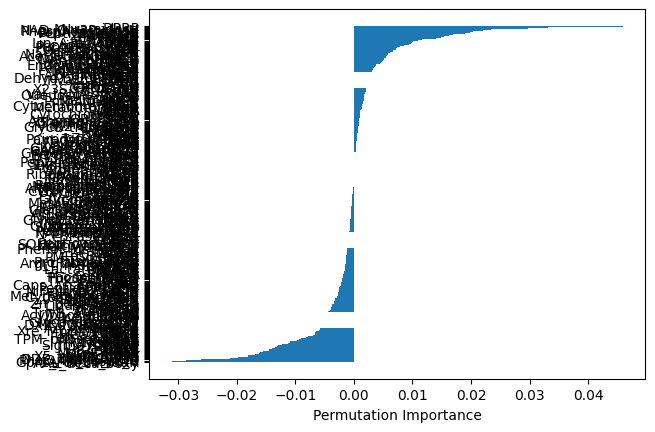

In [32]:
fig=plt.figure()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
fig.savefig('Perm_Importance_2.png', bbox_inches='tight', pad_inches = 0, dpi=200)
plt.show()

In [33]:
permlist = pd.DataFrame()
permlist['gene'] = list(reversed(X_train.columns[sorted_idx]))
permlist['permimpt'] = list(reversed(perm_importance.importances_mean[sorted_idx]))

### Here we are removing all features below a set threshold

This will be heavily dependant on what your permutation list looks like and is somewhat arbitrary. However, you could introduce a grid search that reruns the model with a range of different tresholds and selects the one with the best performance.

In [34]:
permlist_subset = permlist.loc[permlist['permimpt'] > 0.005]

In [35]:
permlist_subset = permlist_subset['gene'].tolist()
permlist_subset.append('pH.preference')

In [36]:
#permlist_subset_2 = pd.read_csv('perm_selection_2.csv')
#permlist_subset_2 = permlist_subset_2['gene'].tolist()
#permlist_subset_2.append('pH.preference')

In [37]:
permlist.loc[permlist['gene'].isin(permlist_subset)].to_csv('perm_selection.csv')


In [38]:
permlist_subset_df = df[permlist_subset]

In [39]:
permlist_subset_df

DPRP  Muramidase  NAD_Gly3P_dh_N  Phosphoesterase  BrnA_antitoxin  \
0       0           0               0                1               1   
1       0           1               0                1               1   
2       0           0               1                1               0   
3       0           1               0                1               0   
4       0           0               0                1               1   
..    ...         ...             ...              ...             ...   
721     1           1               1                0               0   
722     0           0               0                0               0   
723     0           0               0                0               0   
724     0           0               0                0               0   
725     1           0               0                0               0   

     Peptidase_C10  TraG.D_C  AAA_25  ArdcN  SufE  ...  TFR_dimer  \
0                0         1       1      0     1  ...          0   
1                0         0       1      0     0  ...          0   
2                0         0       0      0     1  ...          0   
3                0         0       1      1     0  ...          0   
4                0         0       0      1     0  ...          1   
..             ...       ...     ...    ...   ...  ...        ...   
721              0         0       1      0     1  ...          0   
722              0         0       1      0     0  ...          0   
723              0         0       1      0     1  ...          0   
724              0         0       1      0     1  ...          0   
725              0         0       1      0     1  ...          0   

     Na_H_antiport_1  DHquinase_I  AcetylCoA_hyd_C  OFeT_1  PHO4  \
0                  0            0                1       0     1   
1                  1            0                1       1     1   
2                  0            0                1       0     1   
3                  0            1                0       0     1   
4                  0            1                0       0     1   
..               ...          ...              ...     ...   ...   
721                1            0                1       0     1   
722                0            1                0       0     1   
723                1            0                1       0     0   
724                1            0                0       0     0   
725                0            0                0       0     0   

     Cys_rich_CPXG  Mannitol_dh_C  CsbD  pH.preference  
0                0              1     1       3.724741  
1                0              1     0       3.839540  
2                1              0     1       3.902705  
3                0              0     1       3.914741  
4                0              0     1       3.984741  
..             ...            ...   ...            ...  
721              1              0     1       8.500000  
722              0              0     0       8.540000  
723              0              0     0       8.590000  
724              0              0     0       8.590000  
725              0              0     0       8.750000  

[726 rows x 35 columns]

In [40]:
#Split data into training features and labels
X_perm, y_perm = permlist_subset_df.loc[:, permlist_subset_df.columns != 'pH.preference'], permlist_subset_df['pH.preference']

In [41]:
test_size = 0.1
X_perm_train, X_perm_test, y_perm_train, y_perm_test = train_test_split(X_perm, y_perm, test_size=test_size, random_state=seed)

In [42]:
'''
model_perm_subset = XGBRegressor(
    max_depth=6,
    colsample_bytree=0.6,
    n_estimators=200,
    min_child_weight=5,
    subsample=0.9,    
    eta=0.03,
    objective='reg:squarederror' #,
    #objective='reg:tweedie', tweedie_variance_power=1.54,
    #tree_method='gpu_hist'
)


model_perm_subset.fit(
    X_perm_train, 
    y_perm_train, 
    eval_metric="rmse", 
    eval_set=[(X_perm_train, y_perm_train), (X_perm_test, y_perm_test)], 
    verbose=False, 
    early_stopping_rounds=10)
'''

'\nmodel_perm_subset = XGBRegressor(\n    max_depth=6,\n    colsample_bytree=0.6,\n    n_estimators=200,\n    min_child_weight=5,\n    subsample=0.9,    \n    eta=0.03,\n    objective=\'reg:squarederror\' #,\n    #objective=\'reg:tweedie\', tweedie_variance_power=1.54,\n    #tree_method=\'gpu_hist\'\n)\n\n\nmodel_perm_subset.fit(\n    X_perm_train, \n    y_perm_train, \n    eval_metric="rmse", \n    eval_set=[(X_perm_train, y_perm_train), (X_perm_test, y_perm_test)], \n    verbose=False, \n    early_stopping_rounds=10)\n'

In [43]:
# Quick model
model_perm_subset = XGBRegressor(learning_rate = 0.05, n_estimators=300, max_depth=5)
model_perm_subset.fit(X_perm_train, y_perm_train, early_stopping_rounds=10, eval_metric="rmse", verbose=False, eval_set=[(X_perm_train, y_perm_train), (X_perm_test, y_perm_test)])

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [45]:
# Predict the model
pred_perm_subset = model_perm_subset.predict(X_perm_test)
 
# MAE Computation
scores_perm_subset_MAE = mean_absolute_error(y_perm_test, pred_perm_subset)

# RMSE Computation
scores_perm_subset_RMSE = np.sqrt(mean_squared_error(y_perm_test, pred_perm_subset))
print("RMSE : % f, MAE : % f" % (scores_perm_subset_RMSE, scores_perm_subset_MAE))

RMSE :  0.784212, MAE :  0.582559


### Compare this performance to the original model

In this case, it's better!!!! How 'bout them apples?

In [46]:
print('Mean MAE of original model: %.3f Mean MAE of model based on permutation subset: %.3f' % (scores_MAE, scores_perm_subset_MAE))
print('Mean RMSE of model based on permutation importance is %.3f lower than RMSE of original model' % (scores_MAE-scores_perm_subset_MAE)) 
print('Mean RMSE of original model: %.3f Mean RMSE of model based on permutation subset: %.3f' % (scores_RMSE, scores_perm_subset_RMSE))
print('Mean RMSE of model based on permutation importance is %.3f lower than RMSE of original model' % (scores_RMSE-scores_perm_subset_RMSE))

Mean MAE of original model: 0.622 Mean MAE of model based on permutation subset: 0.583
Mean RMSE of model based on permutation importance is 0.040 lower than RMSE of original model
Mean RMSE of original model: 0.907 Mean RMSE of model based on permutation subset: 0.784
Mean RMSE of model based on permutation importance is 0.123 lower than RMSE of original model


###  Save that model!!!!

In [64]:
# save the model to disk
filename = 'pH_model_2022-09-12.sav'
pickle.dump(model_perm_subset, open(filename, 'wb'))

# load procedure
'''
model_perm_subset = pickle.load(open(filename, 'rb'))
'''

"\nmodel_perm_subset = pickle.load(open(filename, 'rb'))\n"

### Verify that the loaded model works

In [48]:
# load the model from disk
filename = 'pH_model_2022-08-19.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [49]:
loaded_model.fit(X_perm_train, y_perm_train, early_stopping_rounds=10, eval_metric="rmse", verbose=False, eval_set=[(X_perm_train, y_perm_train), (X_perm_test, y_perm_test)])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [50]:
# Predict the model
loaded_pred_perm_subset = loaded_model.predict(X_perm_test)

# MAE Computation
scores_loaded_perm_subset_MAE = mean_absolute_error(y_perm_test, loaded_pred_perm_subset)

# RMSE Computation
scores_loaded_perm_subset_RMSE = np.sqrt(mean_squared_error(y_perm_test, loaded_pred_perm_subset))
print("RMSE : % f, MAE : % f" % (scores_loaded_perm_subset_RMSE, scores_loaded_perm_subset_MAE))

RMSE :  0.784212, MAE :  0.582559


### SHAP analysis of the permutation based model

In [51]:
#perm_predicted_vs_true = pd.merge(pd.DataFrame(pred_perm_subset),pd.DataFrame(y_perm_test))

perm_predicted_vs_true = pd.DataFrame(y_perm_test) 
#predictions = pd.DataFrame(pred_perm_subset)
perm_predicted_vs_true['Predicted pH (XGBoost, permutation)'] = pred_perm_subset

#pd.concat([pd.DataFrame(pred_perm_subset),pd.DataFrame(y_perm_test)], axis=1, ignore_index=True)

#shap_value_sums
#y_df = pd.DataFrame(y)
#shap_valuecomp=pd.merge(y_df,shap_value_sums,left_index=True, right_index=True)
#shap_valuecomp
perm_predicted_vs_true = perm_predicted_vs_true.sort_index(ascending=True)
perm_predicted_vs_true


pH.preference  Predicted pH (XGBoost, permutation)
19        4.348965                             4.597085
24        4.469885                             5.454977
40        5.022421                             4.816030
41        5.024741                             5.861870
48        5.149540                             4.702946
..             ...                                  ...
670       7.940000                             7.528265
678       2.050000                             4.319451
701       7.460000                             7.530282
710       8.450000                             6.538560
719       8.490000                             7.236334

[73 rows x 2 columns]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


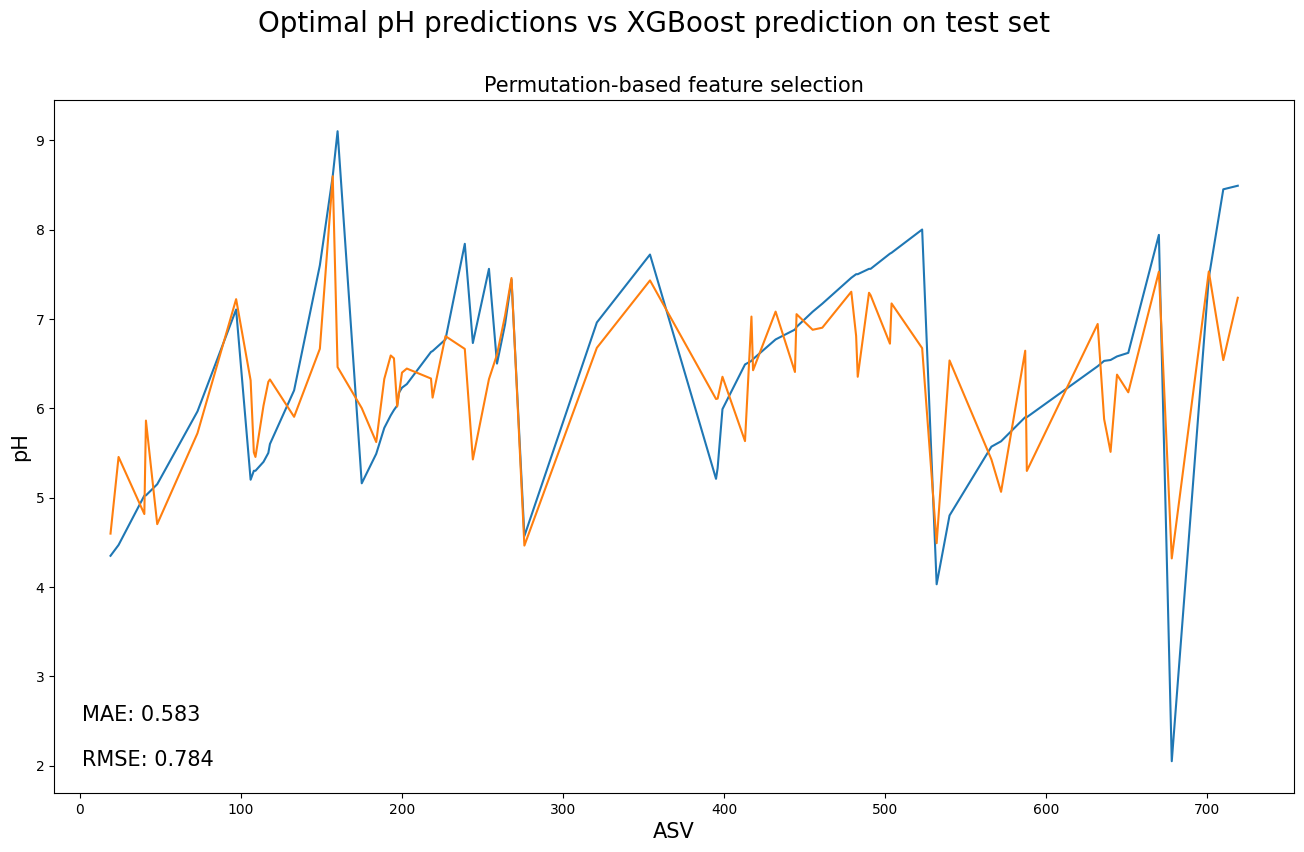

In [52]:
explainer = shap.TreeExplainer(model_perm_subset)
shap_values_forFE = explainer.shap_values(X_perm_test)
shap_values = explainer(X_perm_test)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals+shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y_perm_test)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH (XGBoost, permutation)'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)
#shap_valuecomp = shap_valuecomp.sort_values(by='pH.preference', ascending=False).reset_index()

#shap_valuecomp.plot(use_index=True)
plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH (XGBoost, permutation)'], label = "line 1")




plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs XGBoost prediction on test set", fontsize=20)
plt.title("Permutation-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 2, "RMSE: %.3f" % scores_perm_subset_RMSE, fontsize=15)
plt.text(1, 2.5, "MAE: %.3f" % scores_perm_subset_MAE, fontsize=15)

plt.savefig('perm_testset.png')
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


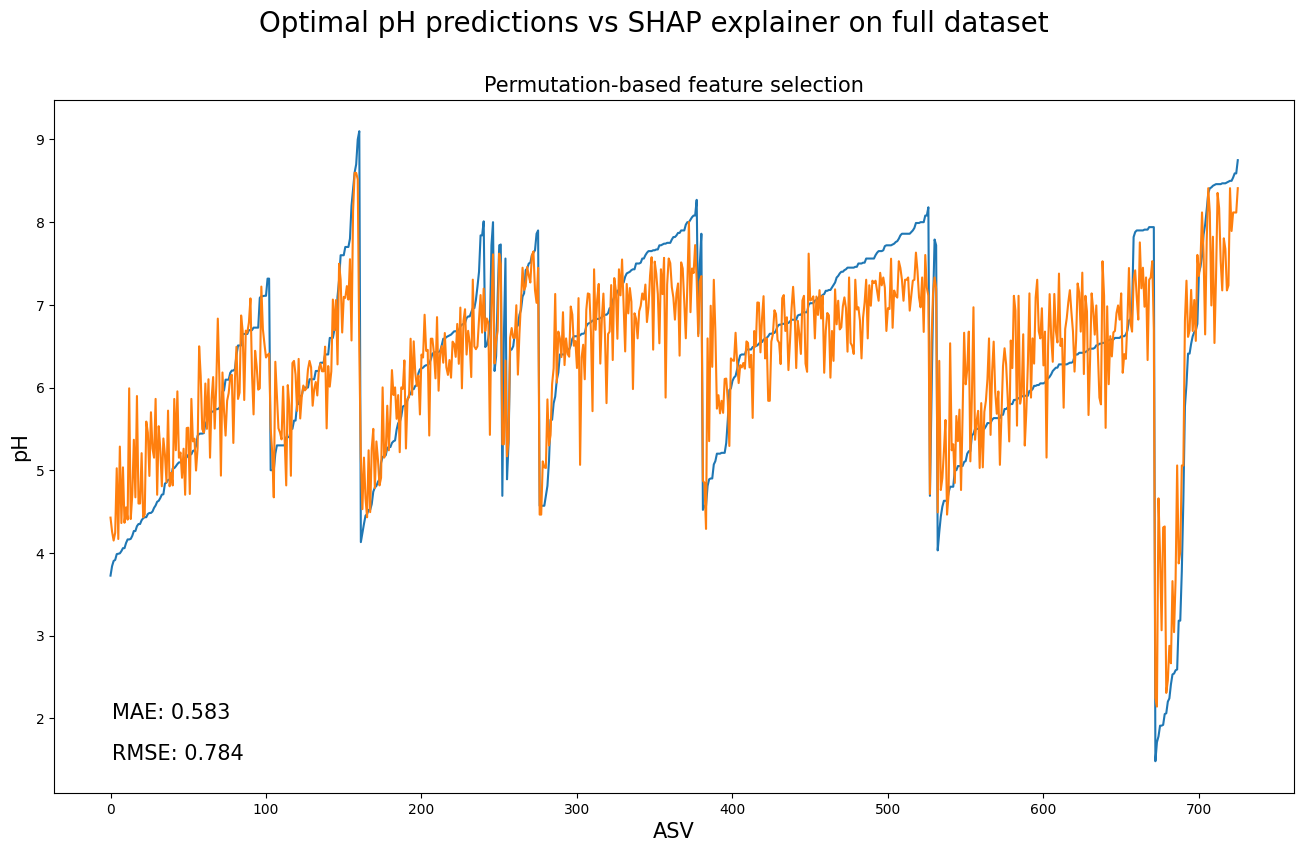

In [53]:
explainer = shap.TreeExplainer(model_perm_subset)
shap_values_forFE = explainer.shap_values(X_perm)
shap_values = explainer(X_perm)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals+shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH (XGBoost, permutation)'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)
#shap_valuecomp = shap_valuecomp.sort_values(by='pH.preference', ascending=False).reset_index()

#shap_valuecomp.plot(use_index=True)
plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH (XGBoost, permutation)'], label = "line 1")

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs SHAP explainer on full dataset", fontsize=20)
plt.title("Permutation-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 1.5, "RMSE: %.3f" % scores_perm_subset_RMSE, fontsize=15)
plt.text(1, 2.0, "MAE: %.3f" % scores_perm_subset_MAE, fontsize=15)

plt.savefig('perm_fullset.png')
plt.show()

In [54]:
test_set_graph_perm = perm_predicted_vs_true
test_set_graph_perm.index.rename('ASV', inplace=True)
test_set_graph_perm.to_csv('perm_test_graph.csv')

full_set_graph_perm = shap_valuecomp
full_set_graph_perm.index.rename('ASV', inplace=True)
full_set_graph_perm.to_csv('perm_full_graph.csv')

In [58]:
fig = shap.summary_plot(shap_values, X_perm, show=False, max_display=30)
plt.savefig('perm_summary.png')

#shap.summary_plot(shap_values, X_perm, max_display=30)


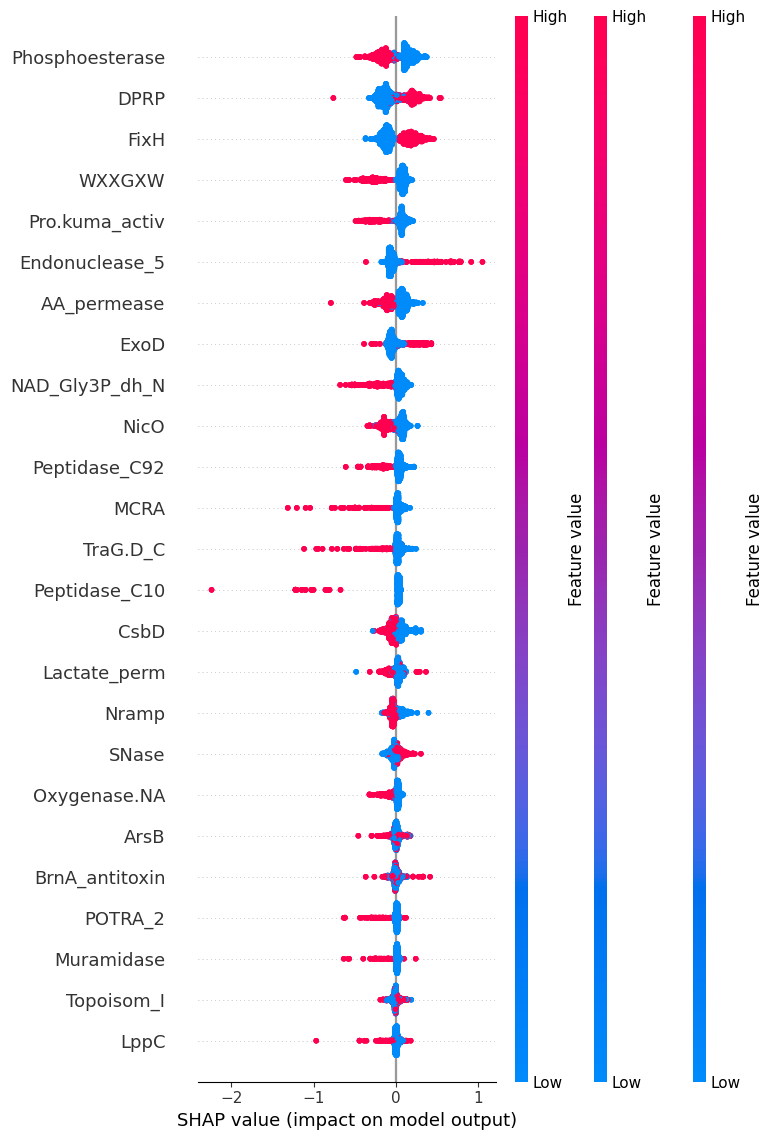

In [63]:
shap.summary_plot(shap_values, X_perm, show=False, max_display=30)
plt.show()

In [56]:
print('Mean MAE of original model: %.3f Mean MAE of model based on perm subset: %.3f' % (scores_MAE, scores_perm_subset_MAE))
print('Mean RMSE of model based on perm is %.3f lower than RMSE of original model' % (scores_MAE-scores_perm_subset_MAE)) 
print('Mean RMSE of original model: %.3f Mean RMSE of model based on perm subset: %.3f' % (scores_RMSE, scores_perm_subset_RMSE))
print('Mean RMSE of model based on perm is %.3f lower than RMSE of original model' % (scores_RMSE-scores_perm_subset_RMSE)) 

Mean MAE of original model: 0.622 Mean MAE of model based on perm subset: 0.583
Mean RMSE of model based on perm is 0.040 lower than RMSE of original model
Mean RMSE of original model: 0.907 Mean RMSE of model based on perm subset: 0.784
Mean RMSE of model based on perm is 0.123 lower than RMSE of original model


#### Correlations to help with permutation feature selection

It's useful to look at correlations when selecting features from a permutation test. I would recommend removing features that have a low perm score and also a low correltaion with other features. I've not done that here yet; also, there are too many features to make a decent looking correlation table


In [57]:
'''
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X_train[X_train.columns[sorted_idx]])
'''

'\ndef correlation_heatmap(train):\n    correlations = train.corr()\n\n    fig, ax = plt.subplots(figsize=(10,10))\n    sns.heatmap(correlations, vmax=1.0, center=0, fmt=\'.2f\', cmap="YlGnBu",\n                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}\n                )\n    plt.show();\n    \ncorrelation_heatmap(X_train[X_train.columns[sorted_idx]])\n'

## Feature Selection Method Three
### SHAP values

By now, we've used SHAP values to "un-blackbox" our models, but you can actually use it as a feature selection method on its own! This section will also review a few other cool things you can do to examine ouputs on a prediction-by-prediction basis.

See https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

See https://towardsdatascience.com/black-box-models-are-actually-more-explainable-than-a-logistic-regression-f263c22795d

See https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

See https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

In [129]:
explainer = shap.TreeExplainer(model_perm_subset)
shap_values_forFE = explainer.shap_values(X_perm)
shap_values = explainer(X_perm)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [130]:
# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals+shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

In [131]:
shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums
y_df = pd.DataFrame(y)
shap_valuecomp=pd.merge(y_df,shap_value_sums,left_index=True, right_index=True)
shap_valuecomp

pH.preference  Shap_pH_prediction
0         3.724741            4.263312
1         3.839540            4.305889
2         3.902705            4.115897
3         3.914741            4.110126
4         3.984741            4.194448
..             ...                 ...
721       8.500000            7.987048
722       8.540000            7.628067
723       8.590000            7.894991
724       8.590000            7.907505
725       8.750000            8.489118

[726 rows x 2 columns]

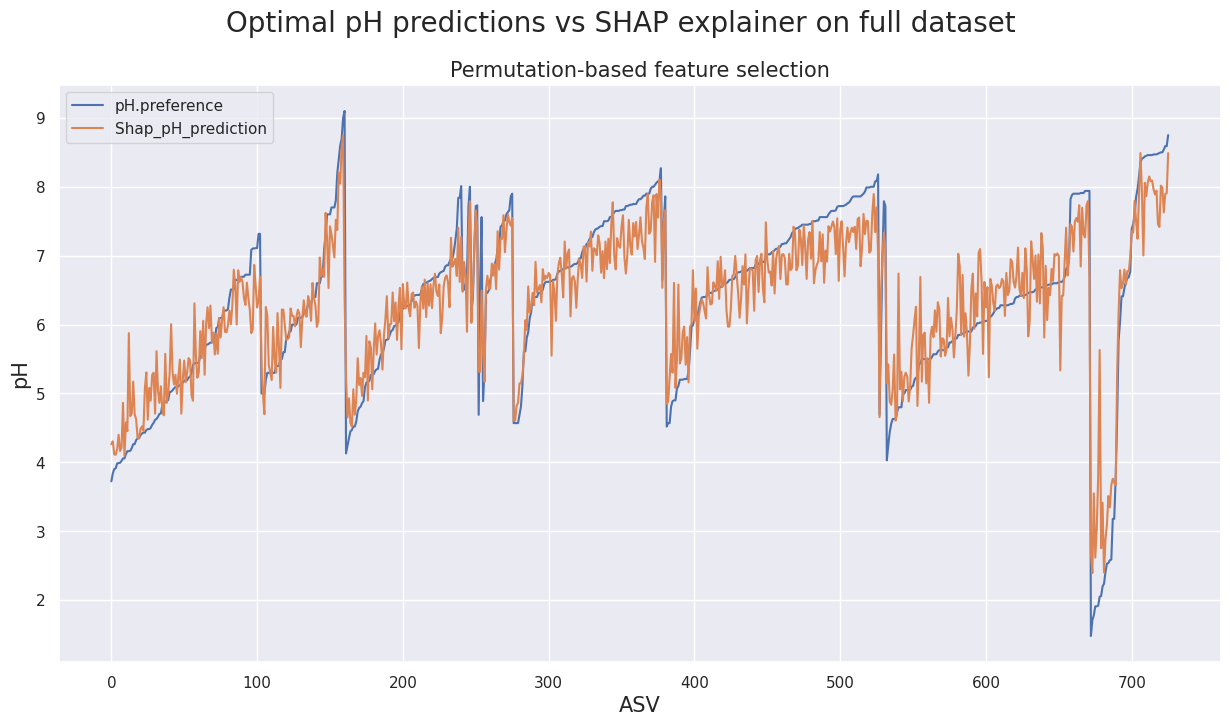

In [132]:
shap_valuecomp.plot(use_index=True)

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs SHAP explainer on full dataset", fontsize=20)
plt.title("Permutation-based feature selection", fontsize = 15)

plt.show()

In [314]:
def shap_feature_ranking(data, shap_values, columns=[]):
    if not columns: columns = data.columns.tolist()     # If columns are not given, take all columns
    
    c_idxs = []
    for column in columns: c_idxs.append(data.columns.get_loc(column))  # Get column locations for desired columns in given dataframe
    if isinstance(shap_values, list):   # If shap values is a list of arrays (i.e., several classes)
        means = [np.abs(shap_values[class_][:, c_idxs]).mean(axis=0) for class_ in range(len(shap_values))]  # Compute mean shap values per class 
        shap_means = np.sum(np.column_stack(means), 1)  # Sum of shap values over all classes 
    else:                               # Else there is only one 2D array of shap values
        assert len(shap_values.shape) == 2, 'Expected two-dimensional shap values array.'
        shap_means = np.abs(shap_values).mean(axis=0)
    
    # Put into dataframe along with columns and sort by shap_means, reset index to get ranking
    df_ranking = pd.DataFrame({'feature': columns, 'mean_shap_value': shap_means}).sort_values(by='mean_shap_value', ascending=False).reset_index(drop=True)
    df_ranking.index += 1
    return df_ranking

In [316]:
feature_names_shap = X_perm_train.columns.tolist()
shap_feats = shap_feature_ranking(df, shap_values_forFE, columns=feature_names_shap)


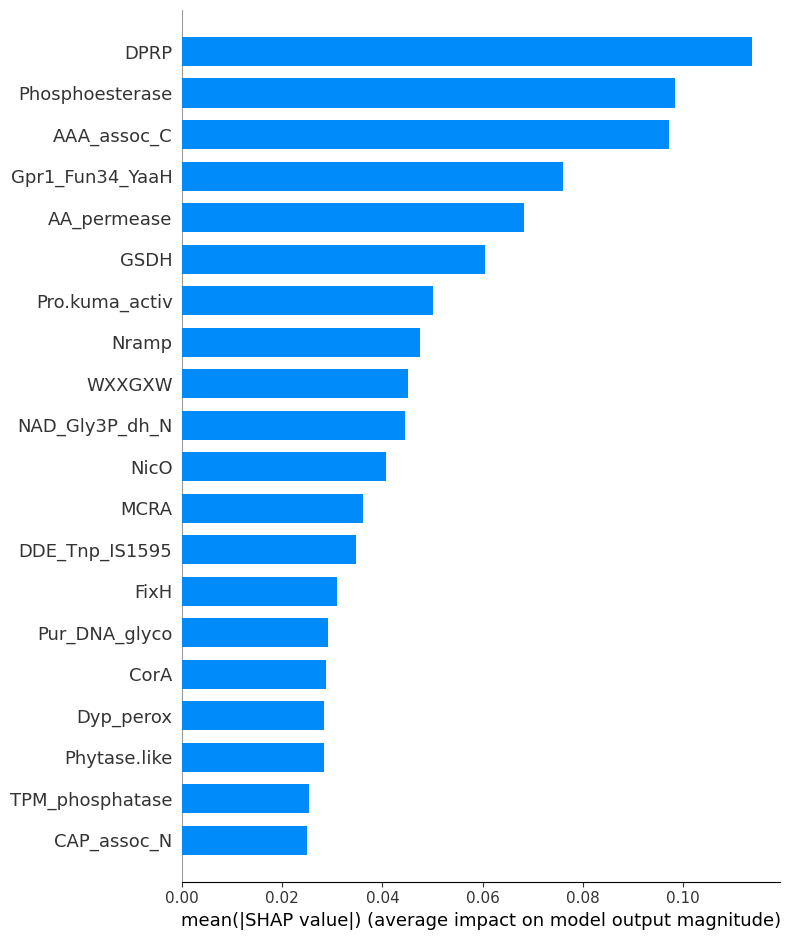

In [213]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

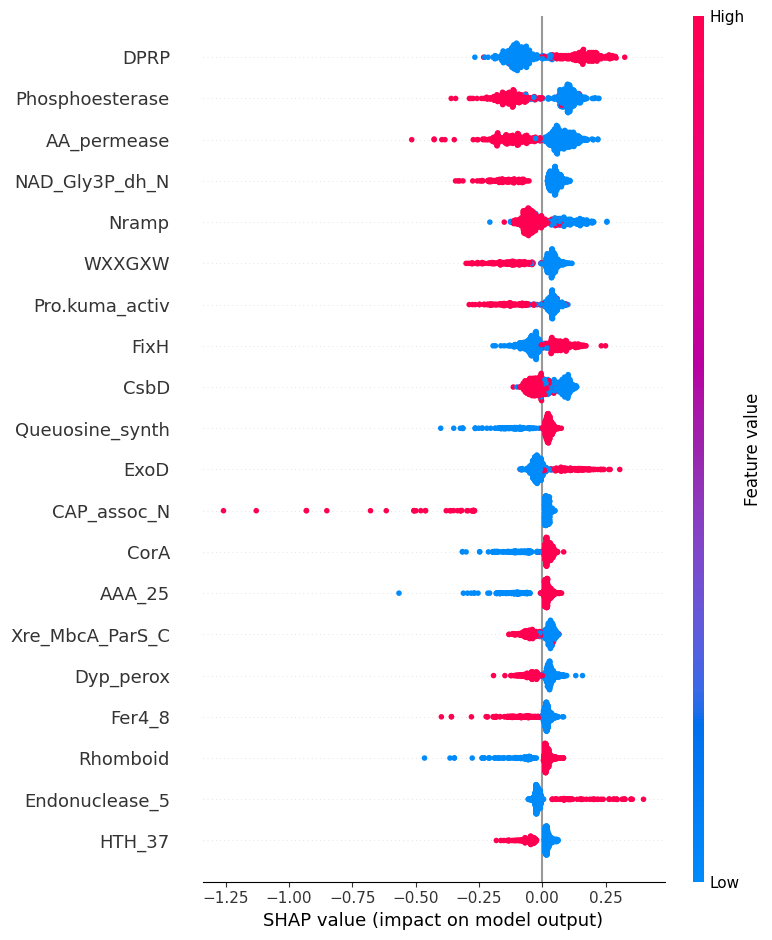

In [317]:
shap.summary_plot(shap_values, X_perm)

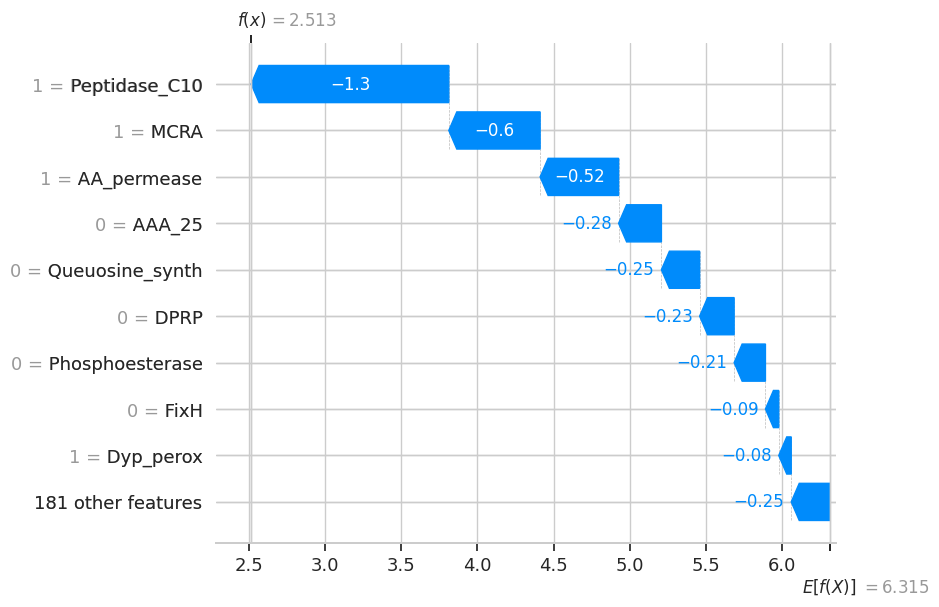

In [387]:
shap.plots.waterfall(shap_values[679])

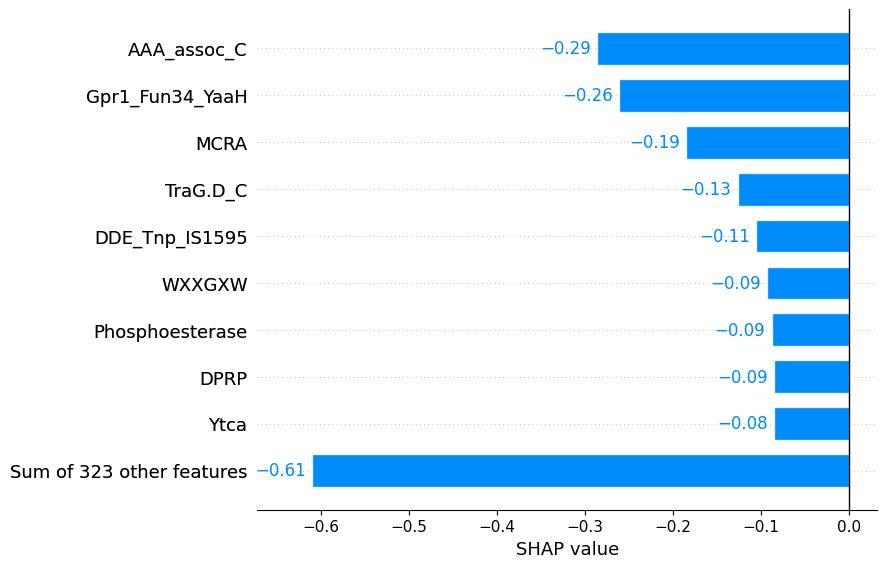

In [216]:
shap.plots.bar(shap_values[0])

The expected value is  6.275474


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


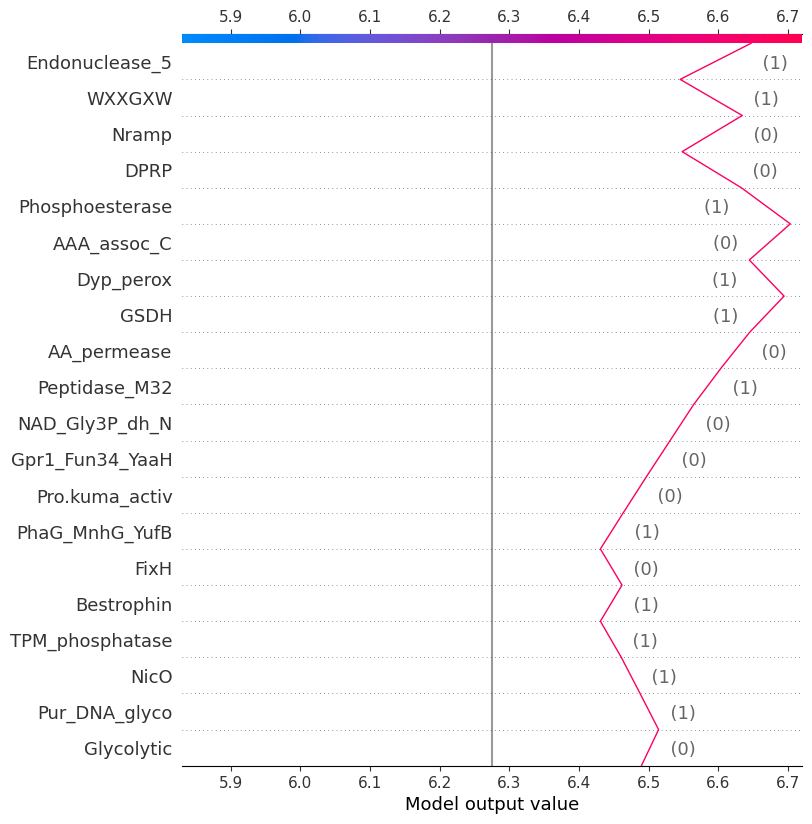

In [217]:
expected_value = explainer.expected_value
print("The expected value is ", expected_value)
shap_values = explainer.shap_values(X_test)[0]
shap.decision_plot(expected_value, shap_values, X_test)

In [218]:
shap.force_plot(explainer.expected_value, shap_values[0:,], X.iloc[0])

In [219]:
shap.dependence_plot("AAL_decarboxy", shap_values, X_test)

TypeError: order must be str, not int

In [220]:
shap_feats

feature  mean_shap_value
1               DPRP         0.113745
2    Phosphoesterase         0.098414
3        AAA_assoc_C         0.097330
4    Gpr1_Fun34_YaaH         0.076152
5        AA_permease         0.068293
..               ...              ...
328       ATP.synt_F         0.000000
329   Ribosomal_L18p         0.000000
330           HipA_2         0.000000
331           UreE_C         0.000000
332        GWxTD_dom         0.000000

[332 rows x 2 columns]

In [221]:
shap_mean = np.absolute(shap_values).mean()
shaplist_subset = shap_feats.loc[shap_feats['mean_shap_value'] > shap_mean]
shaplist_subset

feature  mean_shap_value
1              DPRP         0.113745
2   Phosphoesterase         0.098414
3       AAA_assoc_C         0.097330
4   Gpr1_Fun34_YaaH         0.076152
5       AA_permease         0.068293
..              ...              ...
85             RadC         0.007026
86             RmuC         0.007016
87    YitT_membrane         0.007002
88       Muramidase         0.006949
89             RIO1         0.006919

[89 rows x 2 columns]

In [222]:
shaplist_subset = shaplist_subset['feature'].tolist()
shaplist_subset.append('pH.preference')

In [223]:
shaplist_subset_df = df[shaplist_subset]

In [224]:
#Split data into training features and labels
X_shap, y_shap = shaplist_subset_df.loc[:, shaplist_subset_df.columns != 'pH.preference'], shaplist_subset_df['pH.preference']

In [225]:
test_size = 0.1
X_shap_train, X_shap_test, y_shap_train, y_shap_test = train_test_split(X_shap, y_shap, test_size=test_size, random_state=seed)

In [226]:
# Quick model
model_shap_subset = XGBRegressor(learning_rate = 0.05, n_estimators=300, max_depth=5)
model_shap_subset.fit(X_shap_train, y_shap_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_shap_train, y_shap_train), (X_shap_test, y_shap_test)])

[0]	validation_0-rmse:5.68763	validation_1-rmse:5.73271
[1]	validation_0-rmse:5.41641	validation_1-rmse:5.45937
[2]	validation_0-rmse:5.15921	validation_1-rmse:5.19917
[3]	validation_0-rmse:4.91377	validation_1-rmse:4.95081
[4]	validation_0-rmse:4.68171	validation_1-rmse:4.72357
[5]	validation_0-rmse:4.46064	validation_1-rmse:4.50054
[6]	validation_0-rmse:4.25130	validation_1-rmse:4.29761
[7]	validation_0-rmse:4.05217	validation_1-rmse:4.09703
[8]	validation_0-rmse:3.86297	validation_1-rmse:3.90767
[9]	validation_0-rmse:3.68401	validation_1-rmse:3.72826
[10]	validation_0-rmse:3.51369	validation_1-rmse:3.55771
[11]	validation_0-rmse:3.35257	validation_1-rmse:3.39545
[12]	validation_0-rmse:3.19975	validation_1-rmse:3.24445
[13]	validation_0-rmse:3.05431	validation_1-rmse:3.10568


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[14]	validation_0-rmse:2.91653	validation_1-rmse:2.96897
[15]	validation_0-rmse:2.78627	validation_1-rmse:2.83893
[16]	validation_0-rmse:2.66210	validation_1-rmse:2.71818
[17]	validation_0-rmse:2.54476	validation_1-rmse:2.60433
[18]	validation_0-rmse:2.43303	validation_1-rmse:2.50013
[19]	validation_0-rmse:2.32735	validation_1-rmse:2.39436
[20]	validation_0-rmse:2.22648	validation_1-rmse:2.29875
[21]	validation_0-rmse:2.13158	validation_1-rmse:2.20334
[22]	validation_0-rmse:2.04122	validation_1-rmse:2.11620
[23]	validation_0-rmse:1.95552	validation_1-rmse:2.03742
[24]	validation_0-rmse:1.87431	validation_1-rmse:1.96394
[25]	validation_0-rmse:1.79858	validation_1-rmse:1.89055
[26]	validation_0-rmse:1.72574	validation_1-rmse:1.82361
[27]	validation_0-rmse:1.65746	validation_1-rmse:1.75858
[28]	validation_0-rmse:1.59195	validation_1-rmse:1.70425
[29]	validation_0-rmse:1.52992	validation_1-rmse:1.64841
[30]	validation_0-rmse:1.47153	validation_1-rmse:1.59618
[31]	validation_0-rmse:1.41600	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [227]:
# Predict the model
pred_shap_subset = model_shap_subset.predict(X_shap_test)
 
# MAE Computation
scores_shap_subset_MAE = mean_absolute_error(y_shap_test, pred_shap_subset)

# RMSE Computation
scores_shap_subset_RMSE = np.sqrt(mean_squared_error(y_shap_test, pred_shap_subset))
print("RMSE : % f, MAE : % f" % (scores_shap_subset_RMSE, scores_shap_subset_MAE))

RMSE :  0.919274, MAE :  0.625130


In [228]:
'''
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_shap_subset_MAE = cross_val_score(model_shap_subset, X_shap, y_shap, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores_shap_subset_MAE = np.absolute(scores_shap_subset_MAE)

#scores_shap_subset_RMSE = cross_val_score(model_shap_subset, X_shap, y_shap, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
#scores_shap_subset_RMSE = np.absolute(scores_shap_subset_RMSE)

print('Mean MAE: %.3f (%.3f)' % (scores_shap_subset_MAE.mean(), scores_shap_subset_MAE.std()))

#print('Mean RMSE: %.3f (%.3f)' % (scores_shap_subset_RMSE.mean(), scores_shap_subset_RMSE.std()))

print('Mean MAE of original model: %.3f (%.3f) Mean MAE of model based on gain subset: %.3f (%.3f)' % (scores_MAE.mean(), scores_MAE.std(), scores_shap_subset_MAE.mean(), scores_shap_subset_MAE.std()))
print('Mean RMSE of model based on gain is %.3f lower than RMSE of original model' % (scores_MAE.mean()-scores_shap_subset_MAE.mean())) 
print('Mean RMSE of original model: %.3f (%.3f) Mean RMSE of model based on gain subset: %.3f' % (scores_RMSE.mean(), scores_RMSE.std(), scores_shap_subset_RMSE))
print('Mean RMSE of model based on gain is %.3f lower than RMSE of original model' % (scores_RMSE.mean()-scores_shap_subset_RMSE)) 
'''

"\n# define model evaluation method\ncv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n# evaluate model\nscores_shap_subset_MAE = cross_val_score(model_shap_subset, X_shap, y_shap, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)\n# force scores to be positive\nscores_shap_subset_MAE = np.absolute(scores_shap_subset_MAE)\n\n#scores_shap_subset_RMSE = cross_val_score(model_shap_subset, X_shap, y_shap, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)\n# force scores to be positive\n#scores_shap_subset_RMSE = np.absolute(scores_shap_subset_RMSE)\n\nprint('Mean MAE: %.3f (%.3f)' % (scores_shap_subset_MAE.mean(), scores_shap_subset_MAE.std()))\n\n#print('Mean RMSE: %.3f (%.3f)' % (scores_shap_subset_RMSE.mean(), scores_shap_subset_RMSE.std()))\n\nprint('Mean MAE of original model: %.3f (%.3f) Mean MAE of model based on gain subset: %.3f (%.3f)' % (scores_MAE.mean(), scores_MAE.std(), scores_shap_subset_MAE.mean(), scores_shap_subset_MAE.std()))\nprint('Mean RMSE of m

In [229]:
print('Mean MAE of original model: %.3f Mean MAE of model based on shap subset: %.3f' % (scores_MAE, scores_shap_subset_MAE))
print('Mean RMSE of model based on shap is %.3f lower than RMSE of original model' % (scores_MAE-scores_shap_subset_MAE)) 
print('Mean RMSE of original model: %.3f Mean RMSE of model based on shap subset: %.3f' % (scores_RMSE, scores_shap_subset_RMSE))
print('Mean RMSE of model based on shap is %.3f lower than RMSE of original model' % (scores_RMSE-scores_shap_subset_RMSE)) 

Mean MAE of original model: 0.630 Mean MAE of model based on shap subset: 0.625
Mean RMSE of model based on shap is 0.005 lower than RMSE of original model
Mean RMSE of original model: 0.917 Mean RMSE of model based on shap subset: 0.919
Mean RMSE of model based on shap is -0.003 lower than RMSE of original model


## Feature Seection Method Four
### Boruta algorithm

Note, however, Boruta works well on random forests but poorly on boosted models (such as the XGBoost we have been using here) and neural networks. Its methodology is fairly similar to the permutation-based model.

### If you are using a neural network or boosted model, ship forward to the BoostARoota section

see https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a

see https://www.kaggle.com/code/ajaysamp/boruta-beats-em-all-new-look-at-feature-selection/notebook

In [ ]:
from boruta import BorutaPy

# define Boruta feature selection method
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
feat_selector.fit(X_train.values, y_train.values)

# check selected features
feat_selector.support_
accept = X.columns[feat_selector.support_].to_list()

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train.values)

In [ ]:
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(list(X_train.columns), 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

In [145]:
accept = X.columns[feat_selector.support_].to_list()
accept.insert(0, "pH.preference")
accept


['pH.preference',
 'Gpr1_Fun34_YaaH',
 'Nramp',
 'Peptidase_C10',
 'Phosphoesterase',
 'Pro.kuma_activ',
 'WXXGXW']

In [146]:
new_x = df[accept]

In [147]:
X_new, y_new = new_x.loc[:, new_x.columns != 'pH.preference'], df['pH.preference']

In [148]:
X_t, X_val, y_t, y_val = train_test_split(X_new, y_new, random_state=42)

In [149]:
model = XGBRegressor(
    max_depth=17,
    n_estimators=2110,
    colsample_bytree=0.5,
    min_child_weight=330,
    subsample=0.8,    
    eta=0.2,
    objective='reg:squarederror',
    tree_method='gpu_hist')


model.fit(
    X_t, 
    y_t, 
    eval_metric="rmse", 
    eval_set=[(X_t, y_t), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds=10)

[0]	validation_0-rmse:4.86083	validation_1-rmse:4.75603
[1]	validation_0-rmse:3.96154	validation_1-rmse:3.86242
[2]	validation_0-rmse:3.24997	validation_1-rmse:3.15829
[3]	validation_0-rmse:2.71172	validation_1-rmse:2.62926
[4]	validation_0-rmse:2.30325	validation_1-rmse:2.23195
[5]	validation_0-rmse:1.99094	validation_1-rmse:1.93288
[6]	validation_0-rmse:1.76405	validation_1-rmse:1.72043
[7]	validation_0-rmse:1.59736	validation_1-rmse:1.56908
[8]	validation_0-rmse:1.48167	validation_1-rmse:1.46822
[9]	validation_0-rmse:1.40516	validation_1-rmse:1.40485
[10]	validation_0-rmse:1.35383	validation_1-rmse:1.36495
[11]	validation_0-rmse:1.31948	validation_1-rmse:1.34036
[12]	validation_0-rmse:1.29867	validation_1-rmse:1.32695
[13]	validation_0-rmse:1.28473	validation_1-rmse:1.31912
[14]	validation_0-rmse:1.27512	validation_1-rmse:1.31471
[15]	validation_0-rmse:1.26860	validation_1-rmse:1.31260
[16]	validation_0-rmse:1.26496	validation_1-rmse:1.31202
[17]	validation_0-rmse:1.26251	validation

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=330,
             missing=nan, monotone_constraints='()', n_estimators=2110,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [150]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.992 (0.082)


## Feature Selection Method Five
### BoostARoota

This is basically Boruta algo for boosted Models

see https://morioh.com/p/9ec0e787a417

In [76]:
X_br = pd.get_dummies(X)
X_br

X23S_rRNA_IVP  X5_nucleotid_C  X5.FTHF_cyc.lig  AA_permease  AAA_25  \
0                1               0                1            0       1   
1                1               0                1            1       1   
2                0               1                1            1       0   
3                1               0                0            1       1   
4                1               0                0            1       0   
..             ...             ...              ...          ...     ...   
721              1               0                1            1       1   
722              0               1                1            0       1   
723              0               0                0            0       1   
724              0               0                1            0       1   
725              0               1                1            0       1   

     AAA_assoc_C  AAL_decarboxy  ABATE  Abhydrolase_11  AbiEii  ...  YicC_N  \
0              1              0      0               1       0  ...       1   
1              1              0      0               0       1  ...       1   
2              0              0      0               1       0  ...       1   
3              1              1      1               1       1  ...       0   
4              1              1      1               1       1  ...       1   
..           ...            ...    ...             ...     ...  ...     ...   
721            0              0      1               1       0  ...       1   
722            0              0      0               0       1  ...       1   
723            0              0      0               0       0  ...       0   
724            0              0      0               0       0  ...       1   
725            1              0      0               0       0  ...       0   

     YiiD_C  YitT_membrane  YlxR  YqcI_YcgG  Ysc84  Ytca  ZapB  zf.CDGSH  \
0         0              0     1          0      0     1     0         1   
1         0              0     0          0      1     1     0         1   
2         1              0     0          0      1     1     1         0   
3         0              0     0          1      1     1     1         1   
4         0              0     0          1      1     1     0         0   
..      ...            ...   ...        ...    ...   ...   ...       ...   
721       0              0     0          0      0     0     1         1   
722       0              0     0          0      0     0     1         1   
723       0              0     1          0      0     0     0         0   
724       0              0     1          0      0     0     0         0   
725       0              1     1          0      0     0     0         0   

     Zn_peptidase_2  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
..              ...  
721               0  
722               0  
723               0  
724               0  
725               1  

[726 rows x 332 columns]

In [77]:
#OHE the variables - BoostARoota may break if not done
X_br = pd.get_dummies(X)

#Specify the evaluation metric: can use whichever you like as long as recognized by XGBoost
  #EXCEPTION: multi-class currently only supports "mlogloss" so much be passed in as eval_metric
br = BoostARoota(metric='rmse', cutoff=1)

#Fit the model for the subset of variables
br.fit(X_br, y)


[18:37:17] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  1  iteration:  1
[18:37:17] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  1  iteration:  2
[18:37:17] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or s

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Round:  2  iteration:  3
[18:37:18] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  2  iteration:  4
[18:37:18] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  2  iteration:  5
[18:37:18] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed d

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Round:  3  iteration:  7
[18:37:18] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  3  iteration:  8
[18:37:18] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  3  iteration:  9
[18:37:18] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed d

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Round:  4  iteration:  6
[18:37:18] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  4  iteration:  7
[18:37:18] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  4  iteration:  8
[18:37:18] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed d

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [78]:
#Can look at the important variables - will return a pandas series
br.keep_vars_

0       X23S_rRNA_IVP
1      X5_nucleotid_C
2     X5.FTHF_cyc.lig
3         AA_permease
4              AAA_25
           ...       
66           TraG.D_C
67               TrbL
68            UPRTase
69               VanZ
70             WXXGXW
Name: feature, Length: 67, dtype: object

In [79]:
br.keep_vars_.to_csv('br_selection.csv')

In [80]:
#Then modify dataframe to only include the important variables
X_br_subset = br.transform(X_br)

In [81]:
X_br_subset

X23S_rRNA_IVP  X5_nucleotid_C  X5.FTHF_cyc.lig  AA_permease  AAA_25  \
0                1               0                1            0       1   
1                1               0                1            1       1   
2                0               1                1            1       0   
3                1               0                0            1       1   
4                1               0                0            1       0   
..             ...             ...              ...          ...     ...   
721              1               0                1            1       1   
722              0               1                1            0       1   
723              0               0                0            0       1   
724              0               0                1            0       1   
725              0               1                1            0       1   

     AAA_assoc_C  AAL_decarboxy  ABATE  Abhydrolase_11  AbiEii  ...  POTRA_2  \
0              1              0      0               1       0  ...        0   
1              1              0      0               0       1  ...        1   
2              0              0      0               1       0  ...        0   
3              1              1      1               1       1  ...        0   
4              1              1      1               1       1  ...        0   
..           ...            ...    ...             ...     ...  ...      ...   
721            0              0      1               1       0  ...        0   
722            0              0      0               0       1  ...        0   
723            0              0      0               0       0  ...        0   
724            0              0      0               0       0  ...        0   
725            1              0      0               0       0  ...        0   

     PRK  Pro.kuma_activ  Rhomboid  SufE  TraG.D_C  TrbL  UPRTase  VanZ  \
0      1               0         1     1         1     0        1     0   
1      0               1         0     0         0     1        1     0   
2      0               1         1     1         0     1        1     0   
3      1               1         1     0         0     1        0     1   
4      1               1         1     0         0     1        0     1   
..   ...             ...       ...   ...       ...   ...      ...   ...   
721    0               0         1     1         0     0        1     0   
722    0               0         1     0         0     0        1     0   
723    0               0         1     1         0     0        0     0   
724    1               0         1     1         0     1        1     1   
725    1               0         1     1         0     0        1     1   

     WXXGXW  
0         1  
1         1  
2         1  
3         1  
4         1  
..      ...  
721       0  
722       0  
723       0  
724       0  
725       0  

[726 rows x 67 columns]

In [82]:
test_size = 0.1
X_br_train, X_br_test, y_br_train, y_br_test = train_test_split(X_br_subset, y, test_size=test_size, random_state=seed)

In [83]:
# Quick model
model_br_subset = XGBRegressor(learning_rate = 0.05, n_estimators=300, max_depth=5)
model_br_subset.fit(X_br_train, y_br_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_br_train, y_br_train), (X_br_test, y_br_test)])

[0]	validation_0-rmse:5.68757	validation_1-rmse:5.73309
[1]	validation_0-rmse:5.41627	validation_1-rmse:5.46044
[2]	validation_0-rmse:5.15761	validation_1-rmse:5.19833
[3]	validation_0-rmse:4.91328	validation_1-rmse:4.95483
[4]	validation_0-rmse:4.68054	validation_1-rmse:4.72858
[5]	validation_0-rmse:4.45927	validation_1-rmse:4.50319
[6]	validation_0-rmse:4.24964	validation_1-rmse:4.28853
[7]	validation_0-rmse:4.05038	validation_1-rmse:4.09782
[8]	validation_0-rmse:3.86117	validation_1-rmse:3.91266
[9]	validation_0-rmse:3.68119	validation_1-rmse:3.73401
[10]	validation_0-rmse:3.51068	validation_1-rmse:3.56357
[11]	validation_0-rmse:3.34876	validation_1-rmse:3.40478
[12]	validation_0-rmse:3.19550	validation_1-rmse:3.25384


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[13]	validation_0-rmse:3.04955	validation_1-rmse:3.11046
[14]	validation_0-rmse:2.91088	validation_1-rmse:2.97730
[15]	validation_0-rmse:2.78019	validation_1-rmse:2.84878
[16]	validation_0-rmse:2.65484	validation_1-rmse:2.73047
[17]	validation_0-rmse:2.53689	validation_1-rmse:2.61431
[18]	validation_0-rmse:2.42435	validation_1-rmse:2.50991
[19]	validation_0-rmse:2.31791	validation_1-rmse:2.40861
[20]	validation_0-rmse:2.21662	validation_1-rmse:2.31041
[21]	validation_0-rmse:2.12174	validation_1-rmse:2.21593
[22]	validation_0-rmse:2.03067	validation_1-rmse:2.13045
[23]	validation_0-rmse:1.94480	validation_1-rmse:2.05283
[24]	validation_0-rmse:1.86271	validation_1-rmse:1.97908
[25]	validation_0-rmse:1.78519	validation_1-rmse:1.90887
[26]	validation_0-rmse:1.71138	validation_1-rmse:1.84115
[27]	validation_0-rmse:1.64259	validation_1-rmse:1.77881
[28]	validation_0-rmse:1.57651	validation_1-rmse:1.72611
[29]	validation_0-rmse:1.51381	validation_1-rmse:1.66935
[30]	validation_0-rmse:1.45509	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [84]:
# Predict the model
pred_br_subset = model_br_subset.predict(X_br_test)
 
# MAE Computation
scores_br_subset_MAE = mean_absolute_error(y_br_test, pred_br_subset)

# RMSE Computation
scores_br_subset_RMSE = np.sqrt(mean_squared_error(y_br_test, pred_br_subset))
print("RMSE : % f, MAE : % f" % (scores_br_subset_RMSE, scores_br_subset_MAE))

RMSE :  0.962638, MAE :  0.680934


### SHAP analysis yet again

In [225]:
#perm_predicted_vs_true = pd.merge(pd.DataFrame(pred_perm_subset),pd.DataFrame(y_perm_test))

br_predicted_vs_true = pd.DataFrame(y_br_test) 
#predictions = pd.DataFrame(pred_perm_subset)
br_predicted_vs_true['Predicted pH (XGBoost)'] = pred_br_subset

#pd.concat([pd.DataFrame(pred_perm_subset),pd.DataFrame(y_perm_test)], axis=1, ignore_index=True)

#shap_value_sums
#y_df = pd.DataFrame(y)
#shap_valuecomp=pd.merge(y_df,shap_value_sums,left_index=True, right_index=True)
#shap_valuecomp
br_predicted_vs_true = br_predicted_vs_true.sort_index(ascending=True)
br_predicted_vs_true

pH.preference  Predicted pH (XGBoost)
19        4.348965                4.576661
24        4.469885                5.506861
40        5.022421                5.215897
41        5.024741                5.931289
48        5.149540                4.623288
..             ...                     ...
670       7.940000                8.114078
678       2.050000                5.613524
701       7.460000                7.615698
710       8.450000                7.400560
719       8.490000                7.451569

[73 rows x 2 columns]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


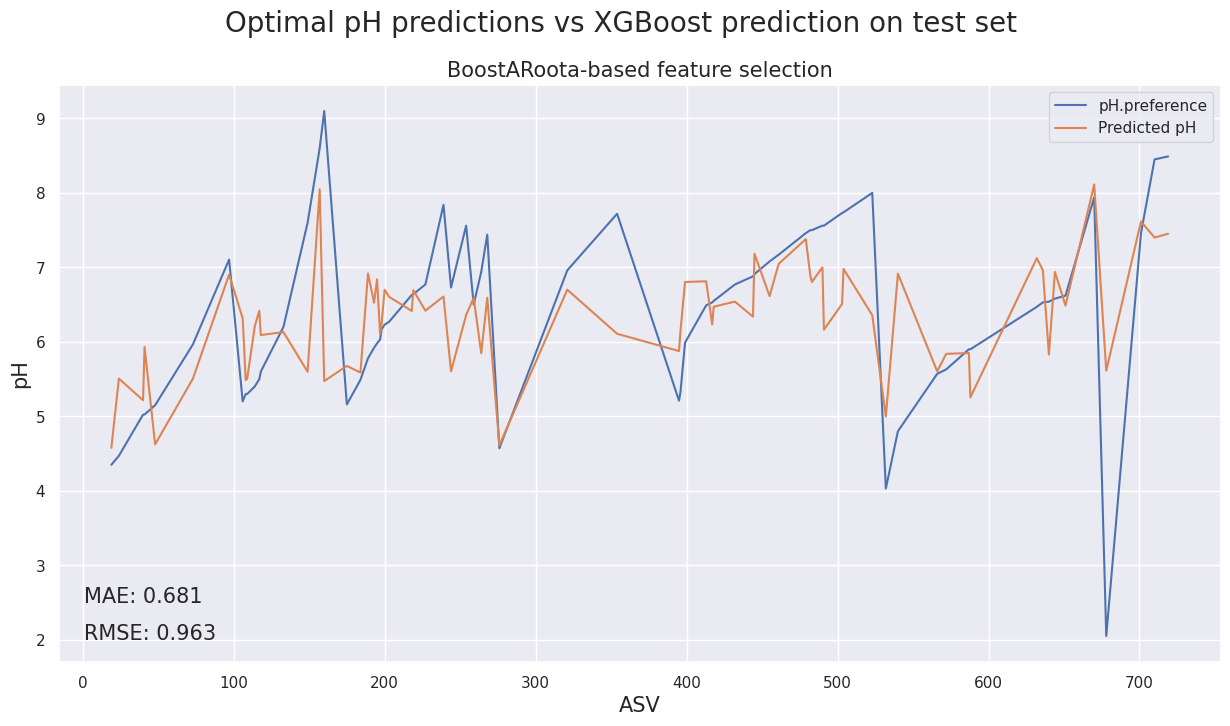

In [226]:
explainer = shap.TreeExplainer(model_br_subset)
shap_values_forFE = explainer.shap_values(X_br_test)
shap_values = explainer(X_br_test)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals+shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y_br_test)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)

shap_valuecomp.plot(use_index=True)

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs XGBoost prediction on test set", fontsize=20)
plt.title("BoostARoota-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 2, "RMSE: %.3f" % scores_br_subset_RMSE, fontsize=15)
plt.text(1, 2.5, "MAE: %.3f" % scores_br_subset_MAE, fontsize=15)

plt.savefig('br_testset.png')
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


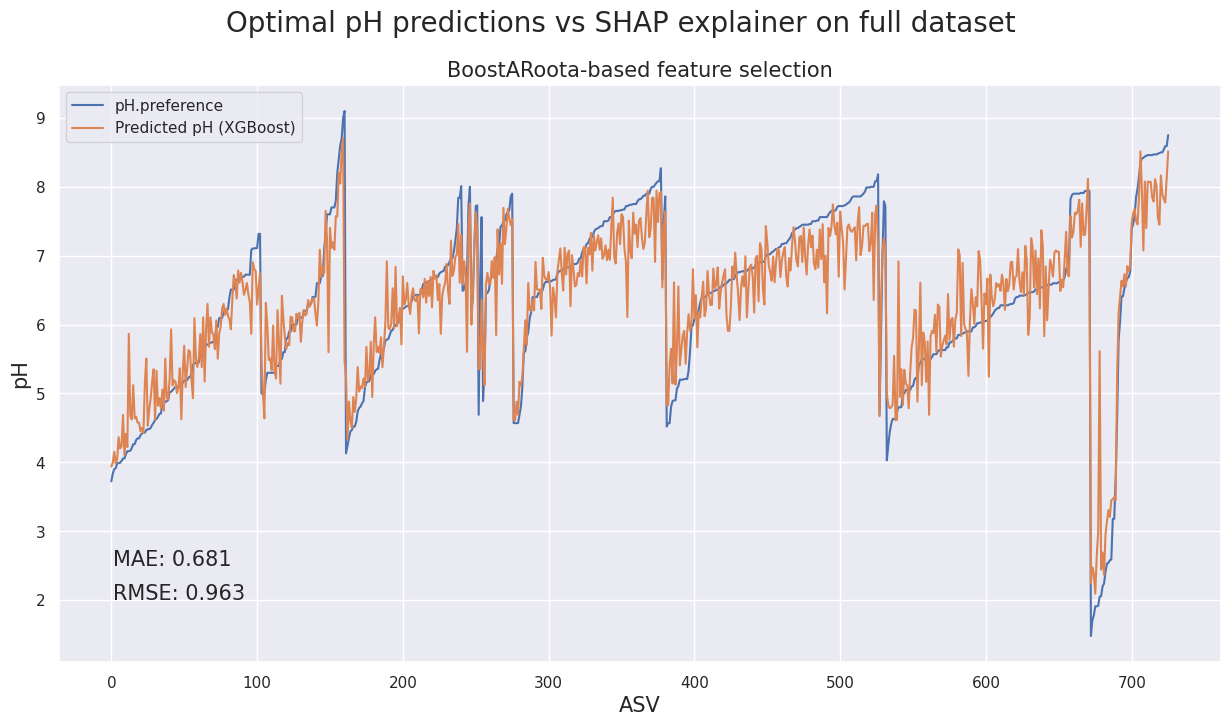

In [227]:
explainer = shap.TreeExplainer(model_br_subset)
shap_values_forFE = explainer.shap_values(X_br)
shap_values = explainer(X_br)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals+shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH (XGBoost)'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)

shap_valuecomp.plot(use_index=True)

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs SHAP explainer on full dataset", fontsize=20)
plt.title("BoostARoota-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 2, "RMSE: %.3f" % scores_br_subset_RMSE, fontsize=15)
plt.text(1, 2.5, "MAE: %.3f" % scores_br_subset_MAE, fontsize=15)

plt.savefig('br_fullset.png')
plt.show()

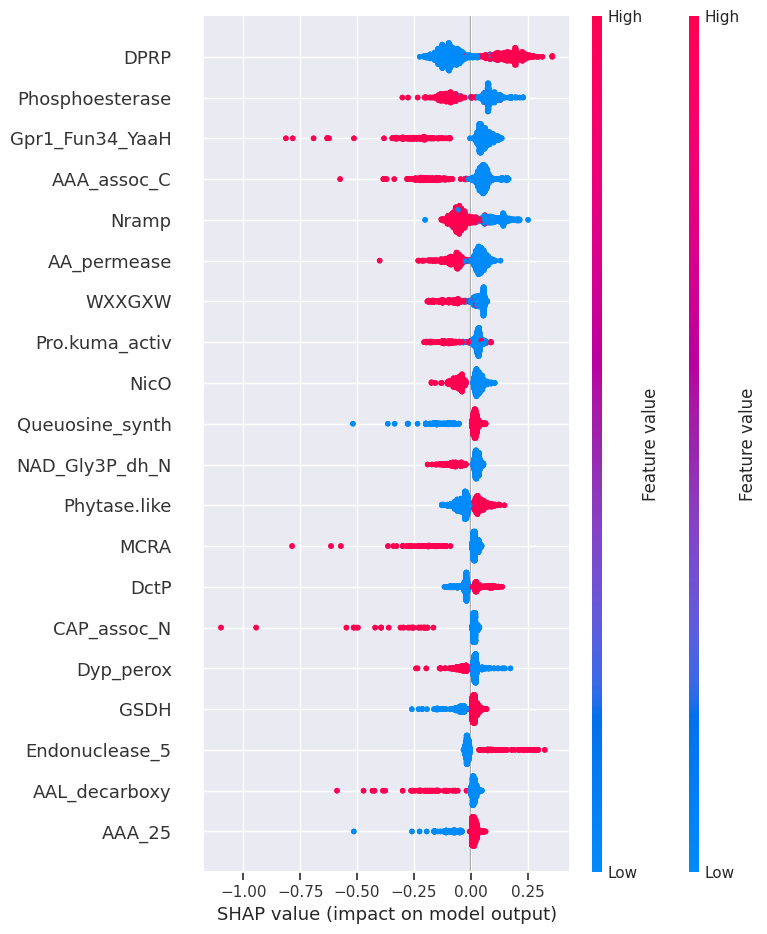

In [228]:
fig = shap.summary_plot(shap_values, X_br, show=False)
plt.savefig('br_summary.png')

shap.summary_plot(shap_values, X_br)


In [264]:
'''
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_br_subset_MAE = cross_val_score(model_br_subset, X_br, y_br, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores_br_subset_MAE = np.absolute(scores_br_subset_MAE)

#scores_br_subset_RMSE = cross_val_score(model_br_subset, X_br, y_br, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
#scores_br_subset_RMSE = np.absolute(scores_br_subset_RMSE)

print('Mean MAE: %.3f (%.3f)' % (scores_br_subset_MAE.mean(), scores_br_subset_MAE.std()))

#print('Mean RMSE: %.3f (%.3f)' % (scores_br_subset_RMSE.mean(), scores_br_subset_RMSE.std()))

print('Mean MAE of original model: %.3f (%.3f) Mean MAE of model based on gain subset: %.3f (%.3f)' % (scores_MAE.mean(), scores_MAE.std(), scores_br_subset_MAE.mean(), scores_br_subset_MAE.std()))
print('Mean RMSE of model based on gain is %.3f lower than RMSE of original model' % (scores_MAE.mean()-scores_br_subset_MAE.mean())) 
print('Mean RMSE of original model: %.3f (%.3f) Mean RMSE of model based on gain subset: %.3f' % (scores_RMSE.mean(), scores_RMSE.std(), scores_br_subset_RMSE))
print('Mean RMSE of model based on gain is %.3f lower than RMSE of original model' % (scores_RMSE.mean()-scores_br_subset_RMSE)) 
'''

"\n# define model evaluation method\ncv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n# evaluate model\nscores_br_subset_MAE = cross_val_score(model_br_subset, X_br, y_br, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)\n# force scores to be positive\nscores_br_subset_MAE = np.absolute(scores_br_subset_MAE)\n\n#scores_br_subset_RMSE = cross_val_score(model_br_subset, X_br, y_br, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)\n# force scores to be positive\n#scores_br_subset_RMSE = np.absolute(scores_br_subset_RMSE)\n\nprint('Mean MAE: %.3f (%.3f)' % (scores_br_subset_MAE.mean(), scores_br_subset_MAE.std()))\n\n#print('Mean RMSE: %.3f (%.3f)' % (scores_br_subset_RMSE.mean(), scores_br_subset_RMSE.std()))\n\nprint('Mean MAE of original model: %.3f (%.3f) Mean MAE of model based on gain subset: %.3f (%.3f)' % (scores_MAE.mean(), scores_MAE.std(), scores_br_subset_MAE.mean(), scores_br_subset_MAE.std()))\nprint('Mean RMSE of model based on gain is %.3f lower tha

In [265]:
print('Mean MAE of original model: %.3f Mean MAE of model based on br subset: %.3f' % (scores_MAE, scores_br_subset_MAE))
print('Mean RMSE of model based on br is %.3f lower than RMSE of original model' % (scores_MAE-scores_br_subset_MAE)) 
print('Mean RMSE of original model: %.3f Mean RMSE of model based on br subset: %.3f' % (scores_RMSE, scores_br_subset_RMSE))
print('Mean RMSE of model based on br is %.3f lower than RMSE of original model' % (scores_RMSE-scores_br_subset_RMSE)) 

Mean MAE of original model: 0.630 Mean MAE of model based on br subset: 0.681
Mean RMSE of model based on br is -0.051 lower than RMSE of original model
Mean RMSE of original model: 0.917 Mean RMSE of model based on br subset: 0.963
Mean RMSE of model based on br is -0.046 lower than RMSE of original model


# Feature Extraction

see https://towardsdatascience.com/feature-extraction-techniques-d619b56e31be

see https://machinelearningmastery.com/autoencoder-for-regression/

https://github.com/tejasnp163/Dimensionality-Reduction-on-Wine-Dataset/blob/main/Wine%20Dataset%20Dimensionality%20Reduction.ipynb

## Method One
### Autoencoders

In [26]:
# train autoencoder for regression with no compression in the bottleneck layer
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

try:
    import pydot
except:
    !pip install pydot
    import pydot
    
try:
    import graphviz
except:
    !pip install graphviz
    import graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 15.8 MB/s eta 0:00:00
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [27]:
X_train_ae, X_test_ae, y_train_ae, y_test_ae = train_test_split(X, y, test_size=0.33, random_state=1)

In [28]:
# number of input columns
n_inputs = X.shape[1]

In [29]:
# scale data
t = MinMaxScaler()
t.fit(X_train_ae)
X_train_ae = t.transform(X_train_ae)
X_test_ae = t.transform(X_test_ae)

In [30]:
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)

In [31]:
# define bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

In [32]:
# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)

In [33]:
# output layer
output = Dense(n_inputs, activation='linear')(d)

In [34]:
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [35]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [36]:
# plot the autoencoder
plot_model(model, 'autoencoder.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [37]:
#fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=400, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/400
41/41 - 1s - loss: 0.3283 - val_loss: 0.2598
Epoch 2/400
41/41 - 0s - loss: 0.1333 - val_loss: 0.1527
Epoch 3/400
41/41 - 0s - loss: 0.1137 - val_loss: 0.1309
Epoch 4/400
41/41 - 0s - loss: 0.1003 - val_loss: 0.1165
Epoch 5/400
41/41 - 0s - loss: 0.0912 - val_loss: 0.1030
Epoch 6/400
41/41 - 0s - loss: 0.0834 - val_loss: 0.1044
Epoch 7/400
41/41 - 0s - loss: 0.0813 - val_loss: 0.0853
Epoch 8/400
41/41 - 0s - loss: 0.0739 - val_loss: 0.0855
Epoch 9/400
41/41 - 0s - loss: 0.0709 - val_loss: 0.0811
Epoch 10/400
41/41 - 0s - loss: 0.0646 - val_loss: 0.0781
Epoch 11/400
41/41 - 0s - loss: 0.0630 - val_loss: 0.0739
Epoch 12/400
41/41 - 0s - loss: 0.0595 - val_loss: 0.0742
Epoch 13/400
41/41 - 0s - loss: 0.0593 - val_loss: 0.0708
Epoch 14/400
41/41 - 0s - loss: 0.0560 - val_loss: 0.0681
Epoch 15/400
41/41 - 0s - loss: 0.0543 - val_loss: 0.0727
Epoch 16/400
41/41 - 0s - loss: 0.0540 - val_loss: 0.0662
Epoch 17/400
41/41 - 0s - loss: 0.0503 - val_loss: 0.0636
Epoch 18/400
41/41 - 0s

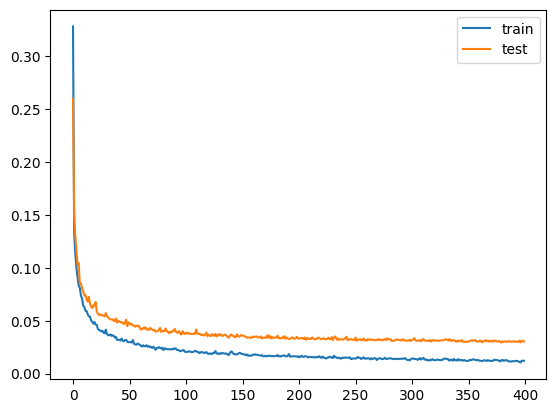

In [38]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [40]:
# save the encoder to file
encoder.save('encoder.h5')

## Method Two
### Locally Linear Embedding (LLE)
Locally Linear Embedding (LLE)

https://www.analyticsvidhya.com/blog/2021/02/a-quick-introduction-to-manifold-learning/

https://towardsdatascience.com/lle-locally-linear-embedding-a-nifty-way-to-reduce-dimensionality-in-python-ab5c38336107

In [16]:
from sklearn.manifold import LocallyLinearEmbedding

try:
    import plotly.express as px # for data visualization
except:
    !pip install plotly
    import plotly.express as px


In [17]:
#lle= LocallyLinearEmbedding(n_neighbors=48, n_components=24, eigen_solver='dense')
lle= LocallyLinearEmbedding(n_neighbors=48, n_components=24, eigen_solver='dense')

X_transformed=lle.fit_transform(X)  #X_perm

In [18]:
X_train_lle, X_test_lle, y_train_lle, y_test_lle = train_test_split(X_transformed, y, test_size=0.10, random_state=seed)

In [19]:
clftre = XGBRegressor(learning_rate = 0.05, 
                      n_estimators=250, 
                      #max_depth=6, 
                      #method='gpu_hist', #sampling_method='uniform',
                      random_state=seed)
clftre.fit(X_train_lle,y_train_lle)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=250, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, ...)

In [20]:
# Predict the model
pred_X_trans = clftre.predict(X_test_lle)
 
# MAE Computation
pred_X_trans_MAE = mean_absolute_error(y_test_lle, pred_X_trans)

# RMSE Computation
pred_X_trans_RMSE = np.sqrt(mean_squared_error(y_test_lle, pred_X_trans))
print("RMSE : % f, MAE : % f" % (pred_X_trans_RMSE, pred_X_trans_MAE))

RMSE :  0.889801, MAE :  0.641621


In [21]:
# Create a 3D scatter plot
def Plot3D(X, y, plot_name):
    fig = px.scatter_3d(None, 
                        x=X[:,0], y=X[:,1], z=X[:,2],
                        color=y,
                        height=800, width=800
                       )
    # Update chart looks
    fig.update_layout(title_text=plot_name,
                      showlegend=False,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=1.75, z=1)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, 
                                  line=dict(color='black', width=0.1)))
    fig.update(layout_coloraxis_showscale=False)
    return fig

In [22]:
# Create a 2D scatter plot
def Plot2D(X, y, plot_name):
    # Create a scatter plot
    fig = px.scatter(None, x=X[:,0], y=X[:,1], 
                     labels={
                         "x": "Dimension 1",
                         "y": "Dimension 2",
                     },
                     
                     opacity=1, color=y, color_continuous_scale='sunset')

    # Change chart background color
    fig.update_layout(dict(plot_bgcolor = 'white'))

    # Update axes lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                     zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                     showline=True, linewidth=1, linecolor='black')

    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                     zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                     showline=True, linewidth=1, linecolor='black')

    # Set figure title
    fig.update_layout(title_text=plot_name)

    # Update marker size
    fig.update_traces(marker=dict(size=5,
                                 line=dict(color='black', width=0.3)))
    return fig

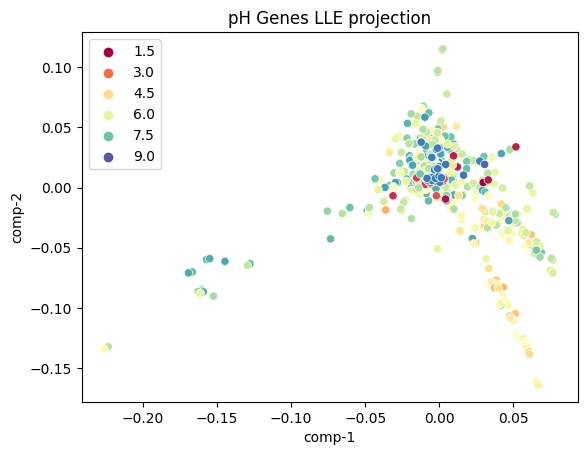

In [23]:
df_lle = pd.DataFrame()
df_lle["y"] = y
df_lle["comp-1"] = X_transformed[:,2]
df_lle["comp-2"] = X_transformed[:,3]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_lle.y.tolist(),
                palette=sns.color_palette("Spectral", 20,as_cmap=True),
                data=df_lle).set(title="pH Genes LLE projection")

plt.show()

In [24]:
Plot3D(X_transformed, y, 'Top 3 LLE')

### Feature selection time

In [208]:
X_train_lle = pd.DataFrame(X_train_lle)
X_transformed = pd.DataFrame(X_transformed)
X_test_lle = pd.DataFrame(X_test_lle)

In [209]:
lle_perm_importance = permutation_importance(clftre, X_test_lle, y_test_lle, random_state=seed)

In [210]:
sorted_idx = lle_perm_importance.importances_mean.argsort()

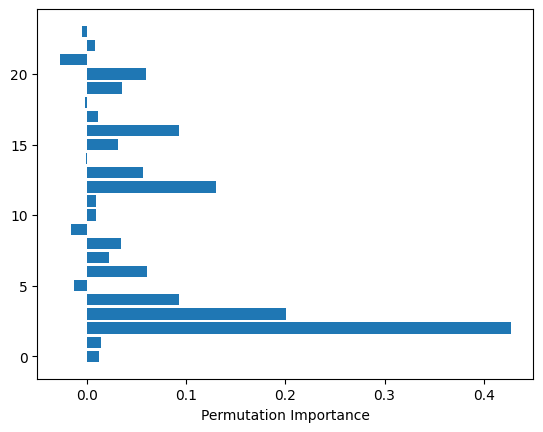

In [211]:
fig=plt.figure()
plt.barh(X_train_lle.columns[sorted_idx], lle_perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
fig.savefig('Perm_Importance_2.png', bbox_inches='tight', pad_inches = 0, dpi=200)
plt.show()

In [212]:
lle_permlist = pd.DataFrame()
lle_permlist['PC'] = list(reversed(X_train_lle.columns[sorted_idx]))
lle_permlist['permimpt'] = list(reversed(lle_perm_importance.importances_mean[sorted_idx]))

### Here we are removing all features below a set threshold

This will be heavily dependant on what your permutation list looks like and is somewhat arbitrary. However, you could introduce a grid search that reruns the model with a range of different tresholds and selects the one with the best performance.

In [213]:
lle_perm_mean = lle_permlist['permimpt'].mean()
lle_permlist_subset = lle_permlist.loc[lle_permlist['permimpt'] > 0.005]

In [214]:
lle_permlist_subset_list = lle_permlist_subset['PC'].tolist()

In [215]:
lle_permlist.loc[lle_permlist['PC'].isin(lle_perm_importance)].to_csv('lle_selection.csv')

In [216]:
lle_df_all = pd.concat([y.reset_index(drop=True),X_transformed[lle_permlist_subset_list].reset_index(drop=True)], axis=1)

In [217]:
lle_df_train = pd.concat([y_train.reset_index(drop=True),X_train_lle[lle_permlist_subset_list].reset_index(drop=True)], axis=1)

In [218]:
lle_df_test = pd.concat([y_test.reset_index(drop=True),X_test_lle[lle_permlist_subset_list].reset_index(drop=True)], axis=1)

In [219]:
#Split data into training features and labels
X_lle_perm, y_lle_perm = lle_df_all.loc[:, lle_df_all.columns != 'pH.preference'], lle_df_all['pH.preference']

In [220]:
test_size = 0.1
X_lle_perm_train, X_lle_perm_test, y_lle_perm_train, y_lle_perm_test = train_test_split(X_lle_perm, y_lle_perm, test_size=test_size, random_state=seed)

In [221]:
# Quick model
model_lle_perm_subset = XGBRegressor(learning_rate = 0.04, n_estimators=100, max_depth=5, random_state=seed)

In [222]:
model_lle_perm_subset = XGBRegressor(
    max_depth=5,
    colsample_bytree=0.8,
    n_estimators=240,
    min_child_weight=10,
    subsample=0.9,    
    eta=.03,
    objective='reg:squarederror',
    #objective='reg:tweedie', tweedie_variance_power=1.5,
    tree_method='gpu_hist'
    )

In [223]:
# Quick model
#model_pca_subset = XGBRegressor(learning_rate = 0.01, n_estimators=325, max_depth=5)
model_lle_perm_subset.fit(X_lle_perm_train, y_lle_perm_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.03,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0299999993, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=240, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [224]:
# Predict the model
pred_lle_subset = model_lle_perm_subset.predict(X_lle_perm_test)
 
# MAE Computation
scores_lle_subset_MAE = mean_absolute_error(y_lle_perm_test, pred_lle_subset)

# RMSE Computation
scores_lle_subset_RMSE = np.sqrt(mean_squared_error(y_lle_perm_test, pred_lle_subset))
print("RMSE : % f, MAE : % f" % (scores_lle_subset_RMSE, scores_lle_subset_MAE))

RMSE :  0.909814, MAE :  0.633550


## Method Three
### t-SNE

https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html

https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0

https://medium.com/jungle-book/automatic-feature-extraction-with-t-sne-62826ce09268

In [25]:
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  

In [56]:
tsne = TSNE(n_components=3, verbose=1, perplexity=4, n_iter=1500, learning_rate=100, random_state=seed)
z = tsne.fit_transform(X_perm) 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 726 samples in 0.000s...
[t-SNE] Computed neighbors for 726 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 726 / 726
[t-SNE] Mean sigma: 0.187748
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.524033
[t-SNE] KL divergence after 1500 iterations: 0.597999


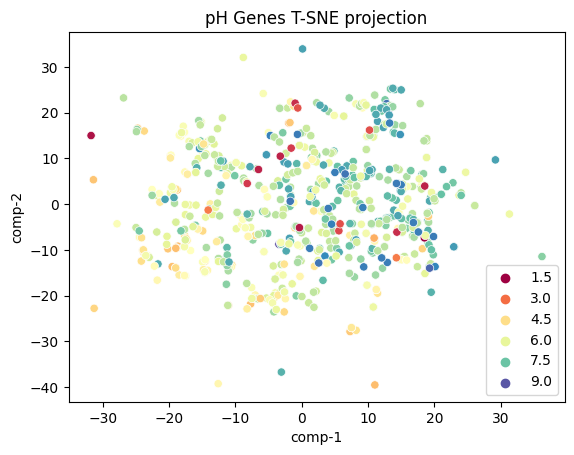

In [57]:
df_tsne = pd.DataFrame()
df_tsne["y"] = y
df_tsne["comp-1"] = z[:,0]
df_tsne["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne.y.tolist(),
                palette=sns.color_palette("Spectral", 20,as_cmap=True),
                data=df_tsne).set(title="pH Genes T-SNE projection")

plt.show()

In [58]:
Plot3D(z, y, 'Top 3 T-Sne')

# Method Four
## PCA

https://medium.com/analytics-vidhya/feature-extraction-techniques-pca-lda-and-t-sne-df0459c723aa

In [51]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

<Figure size 640x480 with 0 Axes>

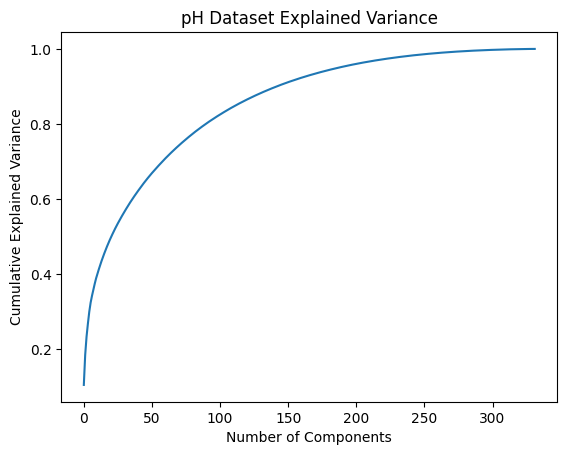

In [52]:
# Fitting the PCA algorithm with our Data
pca = PCA()
pca.fit(X)
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  # for each component
plt.title('pH Dataset Explained Variance')
plt.show(block=True)

In [53]:
# pca = PCA(n_components=12)
#    pca.fit(Xtrain)
#    trainX_pca = pca.transform(trainX)
#    testX_pca = pca.transform(testX)
#    applyrandomforest(trainX_pca, testX_pca, trainY, testY)
    
    
pca = PCA(n_components=5)
Xpca = pca.fit_transform(X)

In [54]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=gene_list)
loadings

PC1       PC2       PC3       PC4       PC5
X23S_rRNA_IVP   -0.060080  0.081336 -0.079347  0.024999  0.115034
X5_nucleotid_C   0.047076 -0.039422 -0.021012 -0.074031  0.151625
X5.FTHF_cyc.lig  0.070700 -0.102166 -0.000649 -0.022047  0.045627
AA_permease      0.066537  0.044673  0.093186 -0.102383 -0.006487
AAA_25           0.044994 -0.052656  0.012898 -0.023619  0.078657
...                   ...       ...       ...       ...       ...
Ysc84            0.022999  0.094524 -0.079898 -0.037521 -0.084370
Ytca             0.008492  0.035493 -0.017226 -0.003066 -0.038690
ZapB             0.043388  0.019886 -0.113378 -0.143809 -0.049955
zf.CDGSH        -0.005754  0.074307  0.023991  0.015840  0.002579
Zn_peptidase_2  -0.044767  0.027941 -0.019342  0.010698  0.163479

[332 rows x 5 columns]

In [55]:
loadings.sort_values(by=['PC2'])

PC1       PC2       PC3       PC4       PC5
YGGT             0.087834 -0.111222  0.090646 -0.002702 -0.091475
X5.FTHF_cyc.lig  0.070700 -0.102166 -0.000649 -0.022047  0.045627
HSP33            0.126992 -0.098814 -0.107186  0.015516 -0.052823
FAD_binding_7    0.016556 -0.095952 -0.024858 -0.050370  0.055313
PRA.PH           0.097278 -0.091869  0.006713 -0.019220  0.045375
...                   ...       ...       ...       ...       ...
SQHop_cyclase_C  0.055680  0.116310  0.033124  0.051042 -0.050870
Phosphoesterase  0.068052  0.117575  0.016354 -0.001233  0.006648
BBP2            -0.033296  0.127017 -0.097821  0.027171  0.096109
ActD            -0.043825  0.129799 -0.088893  0.041017  0.127534
VitK2_biosynth  -0.037923  0.132860  0.018463 -0.010360  0.044133

[332 rows x 5 columns]

In [56]:
pca = PCA(n_components=175, random_state=seed)
pca.fit(X)
X_pca_all = pca.transform(X)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

In [57]:
X_pca_all = pd.DataFrame(X_pca_all)
X_pca_train = pd.DataFrame(X_pca_train)
X_pca_test = pd.DataFrame(X_pca_test)

In [58]:
pca_model = XGBRegressor(learning_rate = 0.03, n_estimators=250, max_depth=5)
pca_model.fit(X_pca_train, 
              y_train, 
              early_stopping_rounds=10, 
              eval_metric="rmse", 
              verbose=False, 
              eval_set=[(X_pca_train, y_train), (X_pca_test, y_test)]
             )

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=250, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [59]:
# Predict the model
pred_pca = pca_model.predict(X_pca_test)
 
# MAE Computation
scores_pca_MAE = mean_absolute_error(y_test, pred_pca)

# RMSE Computation
scores_pca_RMSE = np.sqrt(mean_squared_error(y_test, pred_pca))
print("RMSE : % f, MAE : % f" % (scores_pca_RMSE, scores_pca_MAE))

RMSE :  0.934764, MAE :  0.688535


### Okay lets do feature selection on the engineered features

In [64]:
X_pca_train

0         1         2         3         4         5         6    \
0    2.464049 -1.372157 -0.615086  0.884919 -0.971698 -0.743309 -0.411219   
1    1.210106 -0.440179  0.129315  0.468385  0.994680 -0.490255  0.249337   
2   -1.323851 -2.034872 -1.928875 -1.772308 -1.290215  0.094371 -0.673620   
3    2.439086 -0.549259  0.173609 -1.869265 -0.221930  0.130426  0.709482   
4   -2.909054 -2.267662 -0.337952 -0.336092 -1.719353  0.159576  0.083792   
..        ...       ...       ...       ...       ...       ...       ...   
648  1.527807  0.681635  3.851103  0.284935  0.655653  0.807562 -2.227763   
649  1.115534  0.993288  4.553600 -0.664704  0.709806 -0.083370 -0.934817   
650  0.924994  0.837360 -0.392385 -1.299123 -1.933468 -1.473360  0.284943   
651  3.278683 -0.188495 -0.951052 -1.761169 -1.524203  1.329880  0.348140   
652 -0.056762 -2.544226 -2.166500 -1.776342 -0.738030 -0.325582 -0.547906   

          7         8         9    ...       165       166       167  \
0   -0.262014 -1.147304 -0.381770  ...  0.025678  0.055086  0.226499   
1   -1.950599  0.262338  0.007581  ... -0.037036  0.514114  0.217381   
2   -0.354522 -0.377142  0.042260  ...  0.023179 -0.052367 -0.270167   
3   -1.043031  2.253115 -1.553341  ...  0.106773 -0.159522  0.080574   
4   -0.072880  0.025997  0.070590  ...  0.001489  0.083898  0.194967   
..        ...       ...       ...  ...       ...       ...       ...   
648 -1.035700  1.457710 -0.093532  ...  0.037764 -0.271147 -0.456065   
649 -0.304074 -0.858958 -0.790851  ...  0.006838 -0.247935 -0.310843   
650 -1.207836 -0.116382  0.869489  ...  0.196882 -0.091666 -0.298456   
651  1.155931 -0.241751 -1.459477  ... -0.177073 -0.403988  0.080060   
652 -0.665429 -0.780952  0.843113  ...  0.175200  0.008674 -0.388306   

          168       169       170       171       172       173       174  
0    0.113035  0.366369 -0.257885 -0.010778 -0.358872  0.152966  0.277867  
1   -0.133479 -0.278254 -0.042092  0.271097 -0.180555  0.538358 -0.257573  
2    0.099360  0.155147  0.315110  0.127499  0.197570 -0.497791 -0.186460  
3   -0.028958 -0.050512 -0.025629  0.010761  0.426236  0.034747 -0.187778  
4    0.219848  0.150816 -0.032537  0.397504 -0.177276  0.038028 -0.207560  
..        ...       ...       ...       ...       ...       ...       ...  
648  0.088514 -0.259428 -0.263981  0.077682 -0.187608 -0.204473  0.238284  
649  0.035381  0.156537  0.496998 -0.002871  0.147163  0.040880 -0.103165  
650 -0.436145 -0.096632 -0.241857 -0.036899 -0.173101 -0.136182  0.490788  
651  0.154242 -0.565602 -0.066661 -0.105844  0.079622 -0.237902 -0.152354  
652  0.155869  0.265745 -0.141716  0.154993  0.007301 -0.073479 -0.091113  

[653 rows x 175 columns]

In [60]:
pca_perm_importance = permutation_importance(pca_model, X_pca_test, y_test, random_state=seed)

In [61]:
sorted_idx = pca_perm_importance.importances_mean.argsort()

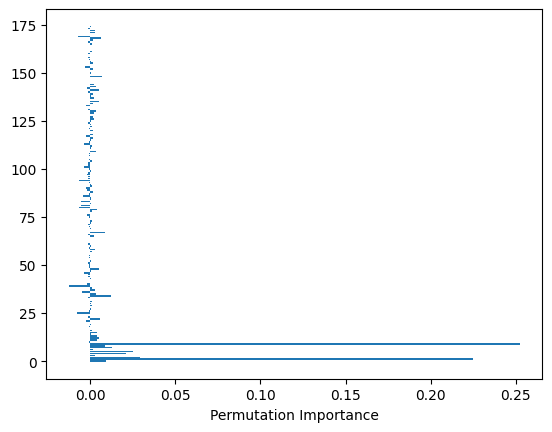

In [62]:
fig=plt.figure()
plt.barh(X_pca_train.columns[sorted_idx], pca_perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
fig.savefig('Perm_Importance_2.png', bbox_inches='tight', pad_inches = 0, dpi=200)
plt.show()

In [1090]:
pca_permlist = pd.DataFrame()
pca_permlist['PC'] = list(reversed(X_pca_train.columns[sorted_idx]))
pca_permlist['permimpt'] = list(reversed(pca_perm_importance.importances_mean[sorted_idx]))

### Here we are removing all features below a set threshold

This will be heavily dependant on what your permutation list looks like and is somewhat arbitrary. However, you could introduce a grid search that reruns the model with a range of different tresholds and selects the one with the best performance.

In [1091]:
pca_perm_mean = pca_permlist['permimpt'].mean()
pca_permlist_subset = pca_permlist.loc[pca_permlist['permimpt'] > .0010]

In [1092]:
pca_permlist_subset_list = pca_permlist_subset['PC'].tolist()

In [1093]:
pca_permlist.loc[pca_permlist['PC'].isin(pca_permlist_subset_list)].to_csv('pca_selection.csv')

In [1094]:
pca_df_all = pd.concat([y.reset_index(drop=True),X_pca_all[pca_permlist_subset_list].reset_index(drop=True)], axis=1)

In [1095]:
pca_df_train = pd.concat([y_train.reset_index(drop=True),X_pca_train[pca_permlist_subset_list].reset_index(drop=True)], axis=1)

In [1096]:
pca_df_test = pd.concat([y_test.reset_index(drop=True),X_pca_test[pca_permlist_subset_list].reset_index(drop=True)], axis=1)

In [1097]:
#Split data into training features and labels
X_pca_perm, y_pca_perm = pca_df_all.loc[:, pca_df_all.columns != 'pH.preference'], pca_df_all['pH.preference']

In [1098]:
test_size = 0.1
X_pca_perm_train, X_pca_perm_test, y_pca_perm_train, y_pca_perm_test = train_test_split(X_pca_perm, y_pca_perm, test_size=test_size, random_state=seed)

In [1211]:
# Quick model
model_pca_perm_subset = XGBRegressor(learning_rate = 0.03, n_estimators=300, max_depth=4, random_state=seed)

In [1112]:
model_pca_subset = XGBRegressor(
    max_depth=5,
    colsample_bytree=0.8,
    n_estimators=225,
    min_child_weight=10,
    subsample=0.9,    
    eta=0.02,
    objective='reg:squarederror',
    #objective='reg:tweedie', tweedie_variance_power=1.54,
    #tree_method='gpu_hist'
    )

In [1113]:
# Quick model
#model_pca_subset = XGBRegressor(learning_rate = 0.01, n_estimators=325, max_depth=5)
model_pca_perm_subset.fit(X_pca_perm_train, y_pca_perm_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, ...)

In [1114]:
# Predict the model
pred_pca_subset = model_pca_perm_subset.predict(X_pca_perm_test)
 
# MAE Computation
scores_pca_subset_MAE = mean_absolute_error(y_pca_perm_test, pred_pca_subset)

# RMSE Computation
scores_pca_subset_RMSE = np.sqrt(mean_squared_error(y_pca_perm_test, pred_pca_subset))
print("RMSE : % f, MAE : % f" % (scores_pca_subset_RMSE, scores_pca_subset_MAE))

RMSE :  0.806475, MAE :  0.607202


In [1116]:
trials = Trials()
best_params = optimize(trials, space)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056647840740875                                      
  0%|          | 1/1000 [00:00<15:19,  1.09trial/s, best loss: 1.2056647840740875]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                
  0%|          | 2/1000 [00:07<1:10:11,  4.22s/trial, best loss: 1.2050776463037485]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                  
  0%|          | 3/1000 [00:08<45:41,  2.75s/trial, best loss: 1.2050776463037485]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                
  0%|          | 4/1000 [00:09<32:16,  1.94s/trial, best loss: 1.2050776463037485]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.137927199205024                                                                 
  0%|          | 5/1000 [00:10<31:30,  1.90s/trial, best loss: 1.137927199205024] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                               
  1%|          | 6/1000 [00:12<29:57,  1.81s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                               
  1%|          | 7/1000 [00:27<1:40:21,  6.06s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2034160845974042                                                                 
  1%|          | 8/1000 [00:28<1:11:30,  4.33s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1461484803716728                                                                 
  1%|          | 9/1000 [00:31<1:05:10,  3.95s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.3360980061060843                                                                 
  1%|          | 10/1000 [00:31<46:54,  2.84s/trial, best loss: 1.137927199205024] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2037822719217084                                                                
  1%|          | 11/1000 [00:32<37:34,  2.28s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                
  1%|          | 12/1000 [00:34<35:44,  2.17s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056107292385634                                                                
  1%|▏         | 13/1000 [00:35<29:10,  1.77s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                
  1%|▏         | 14/1000 [01:31<5:00:54, 18.31s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205924614896148                                                                   
  2%|▏         | 15/1000 [01:39<4:09:59, 15.23s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                  
  2%|▏         | 16/1000 [02:35<7:26:45, 27.24s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205430191344257                                                                   
  2%|▏         | 17/1000 [02:35<5:15:00, 19.23s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205430191344257                                                                   
  2%|▏         | 18/1000 [03:16<6:59:19, 25.62s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                  
  2%|▏         | 19/1000 [03:17<4:58:24, 18.25s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1466385495922702                                                                  
  2%|▏         | 20/1000 [03:19<3:41:10, 13.54s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1479415269341757                                                                  
  2%|▏         | 21/1000 [03:22<2:48:49, 10.35s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1479415269341757                                                                  
  2%|▏         | 22/1000 [03:31<2:42:23,  9.96s/trial, best loss: 1.137927199205024]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1366194344603113                                                                  
  2%|▏         | 23/1000 [03:59<4:10:27, 15.38s/trial, best loss: 1.1366194344603113]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1362351021646586                                                                   
  2%|▏         | 24/1000 [04:02<3:07:39, 11.54s/trial, best loss: 1.1362351021646586]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1366194344603113                                                                   
  2%|▎         | 25/1000 [04:31<4:31:26, 16.70s/trial, best loss: 1.1362351021646586]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                   
  3%|▎         | 26/1000 [04:34<3:25:19, 12.65s/trial, best loss: 1.0845987456850539]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0888899658283462                                                                   
  3%|▎         | 27/1000 [04:37<2:36:57,  9.68s/trial, best loss: 1.0845987456850539]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                   
  3%|▎         | 28/1000 [04:39<2:01:58,  7.53s/trial, best loss: 1.0842922728926354]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                   
  3%|▎         | 29/1000 [04:41<1:36:11,  5.94s/trial, best loss: 1.0842922728926354]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                   
  3%|▎         | 30/1000 [09:15<23:15:38, 86.33s/trial, best loss: 1.0842922728926354]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                     
  3%|▎         | 31/1000 [13:48<38:18:23, 142.32s/trial, best loss: 1.0842922728926354]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
  3%|▎         | 32/1000 [13:51<26:58:57, 100.35s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
  3%|▎         | 33/1000 [13:53<19:03:45, 70.97s/trial, best loss: 1.0404382244055173] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                    
  3%|▎         | 34/1000 [13:54<13:24:55, 50.00s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1016783003207808                                                                    
  4%|▎         | 35/1000 [13:56<9:30:51, 35.49s/trial, best loss: 1.0404382244055173] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
  4%|▎         | 36/1000 [13:57<6:44:46, 25.19s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
  4%|▎         | 37/1000 [13:58<4:48:03, 17.95s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                   
  4%|▍         | 38/1000 [13:59<3:27:13, 12.92s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.094120775091802                                                                    
  4%|▍         | 39/1000 [14:00<2:30:39,  9.41s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1016783003207808                                                                   
  4%|▍         | 40/1000 [14:02<1:51:52,  6.99s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.201928784969834                                                                    
  4%|▍         | 41/1000 [14:02<1:21:57,  5.13s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
  4%|▍         | 42/1000 [14:04<1:02:35,  3.92s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.208546228162958                                                                    
  4%|▍         | 43/1000 [14:06<55:51,  3.50s/trial, best loss: 1.0404382244055173]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0851759909654668                                                                 
  4%|▍         | 44/1000 [14:07<43:43,  2.74s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                 
  4%|▍         | 45/1000 [14:08<34:15,  2.15s/trial, best loss: 1.0404382244055173]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                  
  5%|▍         | 46/1000 [14:33<2:23:06,  9.00s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                  
  5%|▍         | 47/1000 [14:44<2:34:28,  9.73s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                   
  5%|▍         | 48/1000 [15:03<3:15:34, 12.33s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1029043556345206                                                                  
  5%|▍         | 49/1000 [15:04<2:21:22,  8.92s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.118294376693675                                                                   
  5%|▌         | 50/1000 [15:20<2:55:32, 11.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0551314969362653                                                                  
  5%|▌         | 51/1000 [15:21<2:08:32,  8.13s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0532433419988043                                                                  
  5%|▌         | 52/1000 [15:25<1:50:58,  7.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                  
  5%|▌         | 53/1000 [15:39<2:21:53,  8.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                  
  5%|▌         | 54/1000 [15:41<1:50:03,  6.98s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205430191344257                                                                   
  6%|▌         | 55/1000 [15:42<1:19:37,  5.06s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                   
  6%|▌         | 56/1000 [15:44<1:04:09,  4.08s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1078162283793738                                                                  
  6%|▌         | 57/1000 [15:45<51:15,  3.26s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                
  6%|▌         | 58/1000 [15:54<1:19:57,  5.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                  
  6%|▌         | 59/1000 [15:55<1:00:16,  3.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0536075551866058                                                                  
  6%|▌         | 60/1000 [16:01<1:07:32,  4.31s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                  
  6%|▌         | 61/1000 [16:18<2:07:03,  8.12s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                   
  6%|▌         | 62/1000 [16:19<1:35:35,  6.12s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2034160845974042                                                                  
  6%|▋         | 63/1000 [16:20<1:09:04,  4.42s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                   
  6%|▋         | 64/1000 [16:21<55:28,  3.56s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                
  6%|▋         | 65/1000 [16:23<46:50,  3.01s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                
  7%|▋         | 66/1000 [16:25<42:26,  2.73s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                
  7%|▋         | 67/1000 [16:27<39:43,  2.55s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0423399989690576                                                                
  7%|▋         | 68/1000 [16:31<45:54,  2.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                
  7%|▋         | 69/1000 [16:33<41:13,  2.66s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                
  7%|▋         | 70/1000 [16:35<37:57,  2.45s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0971264551081836                                                                
  7%|▋         | 71/1000 [17:10<3:09:07, 12.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                  
  7%|▋         | 72/1000 [19:23<12:29:50, 48.48s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1394510622797311                                                                   
  7%|▋         | 73/1000 [19:25<8:51:46, 34.42s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                  
  7%|▋         | 74/1000 [21:08<14:09:45, 55.06s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
  8%|▊         | 75/1000 [21:09<9:58:36, 38.83s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.059798680830837                                                                   
  8%|▊         | 76/1000 [22:05<11:18:40, 44.07s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
  8%|▊         | 77/1000 [22:07<8:04:36, 31.50s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                   
  8%|▊         | 78/1000 [22:09<5:48:24, 22.67s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                    
  8%|▊         | 79/1000 [22:11<4:13:07, 16.49s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0648443625656905                                                                  
  8%|▊         | 80/1000 [22:13<3:03:11, 11.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0936167060453554                                                                  
  8%|▊         | 81/1000 [22:18<2:31:12,  9.87s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.133491535345206                                                                   
  8%|▊         | 82/1000 [22:19<1:50:40,  7.23s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.10042275467998                                                                    
  8%|▊         | 83/1000 [22:21<1:28:29,  5.79s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1259325732057373                                                                  
  8%|▊         | 84/1000 [22:23<1:10:25,  4.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                  
  8%|▊         | 85/1000 [22:24<53:33,  3.51s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2005107158474726                                                                
  9%|▊         | 86/1000 [22:27<51:50,  3.40s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                
  9%|▊         | 87/1000 [22:28<40:29,  2.66s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                
  9%|▉         | 88/1000 [22:29<31:21,  2.06s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                 
  9%|▉         | 89/1000 [22:30<28:32,  1.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                
  9%|▉         | 90/1000 [22:36<46:57,  3.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0955510143068148                                                                
  9%|▉         | 91/1000 [22:41<56:43,  3.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0887490752222373                                                                
  9%|▉         | 92/1000 [24:09<7:18:03, 28.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                   
  9%|▉         | 93/1000 [25:22<10:34:34, 41.98s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.058475472379644                                                                    
  9%|▉         | 94/1000 [25:24<7:34:23, 30.09s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                  
 10%|▉         | 95/1000 [25:25<5:22:03, 21.35s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                  
 10%|▉         | 96/1000 [25:26<3:48:22, 15.16s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.08366644676109                                                                    
 10%|▉         | 97/1000 [29:54<22:49:20, 90.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2018743587308953                                                                   
 10%|▉         | 98/1000 [29:54<16:00:45, 63.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 10%|▉         | 99/1000 [30:31<13:58:47, 55.86s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1191269394911005                                                                   
 10%|█         | 100/1000 [30:32<9:50:56, 39.40s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 10%|█         | 101/1000 [30:34<6:58:29, 27.93s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                   
 10%|█         | 102/1000 [30:36<5:01:37, 20.15s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                   
 10%|█         | 103/1000 [30:47<4:21:53, 17.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205430191344257                                                                    
 10%|█         | 104/1000 [30:48<3:06:47, 12.51s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0503791831222093                                                                   
 10%|█         | 105/1000 [30:51<2:23:21,  9.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0586411119380088                                                                   
 11%|█         | 106/1000 [30:52<1:46:29,  7.15s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 11%|█         | 107/1000 [30:54<1:23:43,  5.63s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.107380396236909                                                                    
 11%|█         | 108/1000 [31:01<1:30:31,  6.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.19855514050597                                                                     
 11%|█         | 109/1000 [31:02<1:08:23,  4.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                   
 11%|█         | 110/1000 [31:04<55:43,  3.76s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.129316129982329                                                                  
 11%|█         | 111/1000 [31:06<45:27,  3.07s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                 
 11%|█         | 112/1000 [31:09<48:33,  3.28s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                 
 11%|█▏        | 113/1000 [31:16<1:05:19,  4.42s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1983001676476652                                                                   
 11%|█▏        | 114/1000 [31:17<50:00,  3.39s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                   
 12%|█▏        | 115/1000 [31:19<44:07,  2.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                 
 12%|█▏        | 116/1000 [31:21<35:55,  2.44s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                 
 12%|█▏        | 117/1000 [31:22<32:53,  2.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                 
 12%|█▏        | 118/1000 [31:28<48:06,  3.27s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0779463316748172                                                                 
 12%|█▏        | 119/1000 [31:29<37:01,  2.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0630171284118313                                                                 
 12%|█▏        | 120/1000 [31:29<28:42,  1.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                 
 12%|█▏        | 121/1000 [31:30<23:13,  1.59s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.104109686662315                                                                  
 12%|█▏        | 122/1000 [31:32<25:32,  1.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                 
 12%|█▏        | 123/1000 [31:34<25:28,  1.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.137927199205024                                                                  
 12%|█▏        | 124/1000 [31:36<26:23,  1.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                 
 12%|█▎        | 125/1000 [31:38<25:34,  1.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2059340727357482                                                                 
 13%|█▎        | 126/1000 [32:25<3:46:28, 15.55s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                   
 13%|█▎        | 127/1000 [32:26<2:41:33, 11.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 13%|█▎        | 128/1000 [33:10<5:06:05, 21.06s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1316223795784048                                                                   
 13%|█▎        | 129/1000 [33:12<3:41:01, 15.23s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 13%|█▎        | 130/1000 [37:59<23:22:44, 96.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                    
 13%|█▎        | 131/1000 [38:18<17:42:03, 73.33s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.075812691991992                                                                     
 13%|█▎        | 132/1000 [38:19<12:27:50, 51.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0536075551866058                                                                    
 13%|█▎        | 133/1000 [38:20<8:47:23, 36.50s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                   
 13%|█▎        | 134/1000 [38:23<6:20:44, 26.38s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2062161594347827                                                                   
 14%|█▎        | 135/1000 [38:55<6:45:09, 28.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2059340727357482                                                                   
 14%|█▎        | 136/1000 [38:56<4:46:16, 19.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
 14%|█▎        | 137/1000 [38:57<3:25:40, 14.30s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                   
 14%|█▍        | 138/1000 [38:59<2:31:13, 10.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1576017692745273                                                                   
 14%|█▍        | 139/1000 [38:59<1:49:11,  7.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0955510143068148                                                                   
 14%|█▍        | 140/1000 [39:01<1:24:04,  5.87s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 14%|█▍        | 141/1000 [39:03<1:06:34,  4.65s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1239247920163067                                                                   
 14%|█▍        | 142/1000 [39:06<1:00:24,  4.22s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                   
 14%|█▍        | 143/1000 [39:13<1:12:26,  5.07s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                   
 14%|█▍        | 144/1000 [39:15<59:47,  4.19s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0496307693417248                                                                 
 14%|█▍        | 145/1000 [39:17<46:49,  3.29s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                   
 15%|█▍        | 146/1000 [39:19<42:54,  3.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                   
 15%|█▍        | 147/1000 [39:21<40:28,  2.85s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                   
 15%|█▍        | 148/1000 [39:24<39:44,  2.80s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                   
 15%|█▍        | 149/1000 [39:27<39:03,  2.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                   
 15%|█▌        | 150/1000 [39:29<39:05,  2.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                 
 15%|█▌        | 151/1000 [39:32<36:58,  2.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                   
 15%|█▌        | 152/1000 [39:34<36:57,  2.62s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                 
 15%|█▌        | 153/1000 [39:36<34:56,  2.48s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                  
 15%|█▌        | 154/1000 [39:38<32:02,  2.27s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0627151208557148                                                                 
 16%|█▌        | 155/1000 [41:09<6:44:19, 28.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 16%|█▌        | 156/1000 [41:11<4:52:37, 20.80s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.11946515198824                                                                     
 16%|█▌        | 157/1000 [41:13<3:31:56, 15.08s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1370016054254768                                                                   
 16%|█▌        | 158/1000 [41:15<2:35:44, 11.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2029091944638843                                                                   
 16%|█▌        | 159/1000 [41:18<2:04:59,  8.92s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 16%|█▌        | 160/1000 [41:21<1:36:43,  6.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 16%|█▌        | 161/1000 [41:22<1:15:16,  5.38s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 16%|█▌        | 162/1000 [42:43<6:30:07, 27.93s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 16%|█▋        | 163/1000 [43:56<9:37:47, 41.42s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 16%|█▋        | 164/1000 [43:59<6:55:17, 29.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0955510143068148                                                                   
 16%|█▋        | 165/1000 [43:59<4:52:48, 21.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 17%|█▋        | 166/1000 [44:11<4:13:38, 18.25s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0503791831222093                                                                   
 17%|█▋        | 167/1000 [44:15<3:13:06, 13.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0586411119380088                                                                   
 17%|█▋        | 168/1000 [44:16<2:20:01, 10.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 17%|█▋        | 169/1000 [44:17<1:42:40,  7.41s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.043964624680316                                                                    
 17%|█▋        | 170/1000 [44:18<1:15:48,  5.48s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.107380396236909                                                                    
 17%|█▋        | 171/1000 [44:20<1:02:08,  4.50s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1986815210586035                                                                   
 17%|█▋        | 172/1000 [44:21<48:10,  3.49s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1351514912110794                                                                 
 17%|█▋        | 173/1000 [44:23<38:26,  2.79s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1466385495922702                                                                 
 17%|█▋        | 174/1000 [44:25<35:18,  2.57s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                 
 18%|█▊        | 175/1000 [44:26<29:01,  2.11s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                 
 18%|█▊        | 176/1000 [47:20<12:18:19, 53.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.094120775091802                                                                     
 18%|█▊        | 177/1000 [47:39<9:54:24, 43.33s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 18%|█▊        | 178/1000 [48:52<11:55:34, 52.23s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                    
 18%|█▊        | 179/1000 [50:12<13:50:55, 60.73s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                      
 18%|█▊        | 180/1000 [50:15<9:49:37, 43.14s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0582761802741185                                                                   
 18%|█▊        | 181/1000 [50:16<6:57:55, 30.62s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.088490671209654                                                                    
 18%|█▊        | 182/1000 [51:01<7:55:31, 34.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
 18%|█▊        | 183/1000 [51:02<5:36:59, 24.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0423399989690576                                                                   
 18%|█▊        | 184/1000 [51:07<4:15:56, 18.82s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1013385650774907                                                                   
 18%|█▊        | 185/1000 [51:09<3:07:31, 13.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.145458323239372                                                                    
 19%|█▊        | 186/1000 [51:17<2:43:50, 12.08s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                   
 19%|█▊        | 187/1000 [51:18<1:57:43,  8.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                   
 19%|█▉        | 188/1000 [51:22<1:41:00,  7.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 19%|█▉        | 189/1000 [51:24<1:15:09,  5.56s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1239247920163067                                                                   
 19%|█▉        | 190/1000 [51:25<59:08,  4.38s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055024747035763                                                                 
 19%|█▉        | 191/1000 [51:26<43:39,  3.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                 
 19%|█▉        | 192/1000 [51:28<40:00,  2.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                 
 19%|█▉        | 193/1000 [51:35<56:31,  4.20s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0648443625656905                                                                 
 19%|█▉        | 194/1000 [51:37<46:09,  3.44s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.076827942374657                                                                  
 20%|█▉        | 195/1000 [51:39<39:45,  2.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                   
 20%|█▉        | 196/1000 [52:59<5:51:35, 26.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 20%|█▉        | 197/1000 [53:00<4:10:22, 18.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1093486199608127                                                                   
 20%|█▉        | 198/1000 [53:09<3:30:22, 15.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.111276600212759                                                                    
 20%|█▉        | 199/1000 [53:11<2:34:31, 11.58s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1372724250933934                                                                   
 20%|██        | 200/1000 [54:36<7:28:01, 33.60s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2009491287198013                                                                   
 20%|██        | 201/1000 [54:37<5:17:53, 23.87s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                   
 20%|██        | 202/1000 [54:39<3:49:11, 17.23s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0779463316748172                                                                   
 20%|██        | 203/1000 [54:40<2:42:58, 12.27s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                    
 20%|██        | 204/1000 [54:41<2:00:52,  9.11s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 20%|██        | 205/1000 [55:54<6:13:33, 28.19s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                   
 21%|██        | 206/1000 [55:55<4:25:22, 20.05s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.092341289091067                                                                    
 21%|██        | 207/1000 [56:01<3:29:10, 15.83s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 21%|██        | 208/1000 [56:03<2:34:27, 11.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.058475472379644                                                                    
 21%|██        | 209/1000 [56:05<1:55:18,  8.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0503791831222093                                                                   
 21%|██        | 210/1000 [1:03:12<29:26:45, 134.18s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                       
 21%|██        | 211/1000 [1:03:13<20:38:02, 94.15s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 21%|██        | 212/1000 [1:03:15<14:33:34, 66.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0946710140559743                                                                      
 21%|██▏       | 213/1000 [1:03:15<10:13:42, 46.79s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                      
 21%|██▏       | 214/1000 [1:03:17<7:15:25, 33.24s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                     
 22%|██▏       | 215/1000 [1:03:18<5:09:00, 23.62s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 22%|██▏       | 216/1000 [1:04:00<6:18:25, 28.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 22%|██▏       | 217/1000 [1:04:00<4:27:30, 20.50s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                     
 22%|██▏       | 218/1000 [1:04:34<5:16:59, 24.32s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                      
 22%|██▏       | 219/1000 [1:04:36<3:50:15, 17.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 22%|██▏       | 220/1000 [1:04:38<2:49:14, 13.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 22%|██▏       | 221/1000 [1:04:44<2:20:44, 10.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                     
 22%|██▏       | 222/1000 [1:04:45<1:44:59,  8.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0648443625656905                                                                     
 22%|██▏       | 223/1000 [1:04:47<1:20:12,  6.19s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0423399989690576                                                                     
 22%|██▏       | 224/1000 [1:05:29<3:39:27, 16.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0935709099186552                                                                     
 22%|██▎       | 225/1000 [1:05:32<2:42:12, 12.56s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 23%|██▎       | 226/1000 [1:05:32<1:56:43,  9.05s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                     
 23%|██▎       | 227/1000 [1:05:35<1:29:50,  6.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.111276600212759                                                                      
 23%|██▎       | 228/1000 [1:05:36<1:10:12,  5.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                     
 23%|██▎       | 229/1000 [1:06:19<3:34:36, 16.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 23%|██▎       | 230/1000 [1:06:21<2:37:04, 12.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0955510143068148                                                                     
 23%|██▎       | 231/1000 [1:06:22<1:52:08,  8.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                     
 23%|██▎       | 232/1000 [1:06:23<1:22:19,  6.43s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1370016054254768                                                                     
 23%|██▎       | 233/1000 [1:06:33<1:36:11,  7.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0423399989690576                                                                     
 23%|██▎       | 234/1000 [1:06:37<1:24:32,  6.62s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                     
 24%|██▎       | 235/1000 [1:07:30<4:20:31, 20.43s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 24%|██▎       | 236/1000 [1:07:32<3:10:16, 14.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.089792837437675                                                                      
 24%|██▎       | 237/1000 [1:07:34<2:20:52, 11.08s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 24%|██▍       | 238/1000 [1:07:37<1:49:21,  8.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055024747035763                                                                     
 24%|██▍       | 239/1000 [1:07:42<1:36:45,  7.63s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0646094849322014                                                                     
 24%|██▍       | 240/1000 [1:07:44<1:12:32,  5.73s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1029043556345206                                                                     
 24%|██▍       | 241/1000 [1:07:45<55:43,  4.40s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1299572001066958                                                                   
 24%|██▍       | 242/1000 [1:07:49<52:03,  4.12s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
 24%|██▍       | 243/1000 [1:08:28<3:07:09, 14.83s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2005107158474726                                                                     
 24%|██▍       | 244/1000 [1:08:30<2:17:44, 10.93s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0955510143068148                                                                     
 24%|██▍       | 245/1000 [1:08:31<1:39:11,  7.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0687530434241541                                                                     
 25%|██▍       | 246/1000 [1:08:32<1:14:36,  5.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 25%|██▍       | 247/1000 [1:08:34<56:40,  4.52s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 25%|██▍       | 248/1000 [1:08:35<46:28,  3.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 25%|██▍       | 249/1000 [1:08:37<36:58,  2.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                   
 25%|██▌       | 250/1000 [1:08:39<33:01,  2.64s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.201928784969834                                                                    
 25%|██▌       | 251/1000 [1:10:25<7:00:29, 33.68s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 25%|██▌       | 252/1000 [1:11:45<9:54:36, 47.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0646094849322014                                                                     
 25%|██▌       | 253/1000 [1:11:46<7:00:57, 33.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 25%|██▌       | 254/1000 [1:11:47<4:57:02, 23.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                     
 26%|██▌       | 255/1000 [1:11:50<3:38:31, 17.60s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                     
 26%|██▌       | 256/1000 [1:11:54<2:45:52, 13.38s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1370016054254768                                                                     
 26%|██▌       | 257/1000 [1:11:56<2:03:59, 10.01s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 26%|██▌       | 258/1000 [1:11:58<1:36:04,  7.77s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0497865860723703                                                                     
 26%|██▌       | 259/1000 [1:12:00<1:14:25,  6.03s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 26%|██▌       | 260/1000 [1:12:22<2:13:26, 10.82s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 26%|██▌       | 261/1000 [1:12:44<2:54:16, 14.15s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 26%|██▌       | 262/1000 [1:13:06<3:22:49, 16.49s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 26%|██▋       | 263/1000 [1:13:28<3:43:13, 18.17s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 26%|██▋       | 264/1000 [1:13:50<3:56:39, 19.29s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 26%|██▋       | 265/1000 [1:15:10<7:38:03, 37.39s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 27%|██▋       | 266/1000 [1:16:29<10:11:09, 49.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 27%|██▋       | 267/1000 [1:17:48<11:57:33, 58.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 27%|██▋       | 268/1000 [1:17:50<8:28:22, 41.67s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.19855514050597                                                                       
 27%|██▋       | 269/1000 [1:17:51<5:59:18, 29.49s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 27%|██▋       | 270/1000 [1:17:54<4:20:10, 21.38s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 27%|██▋       | 271/1000 [1:17:55<3:07:30, 15.43s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0447362281538113                                                                     
 27%|██▋       | 272/1000 [1:18:03<2:39:52, 13.18s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 27%|██▋       | 273/1000 [1:18:05<1:57:30,  9.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 27%|██▋       | 274/1000 [1:18:48<4:00:16, 19.86s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                     
 28%|██▊       | 275/1000 [1:18:50<2:55:31, 14.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 28%|██▊       | 276/1000 [1:18:55<2:17:56, 11.43s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0503791831222093                                                                     
 28%|██▊       | 277/1000 [1:18:58<1:48:09,  8.98s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.058475472379644                                                                      
 28%|██▊       | 278/1000 [1:18:59<1:21:13,  6.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 28%|██▊       | 279/1000 [1:19:01<1:03:27,  5.28s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 28%|██▊       | 280/1000 [1:19:02<46:43,  3.89s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                    
 28%|██▊       | 281/1000 [1:19:15<1:18:19,  6.54s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 28%|██▊       | 282/1000 [1:19:17<1:02:04,  5.19s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1362351021646586                                                                     
 28%|██▊       | 283/1000 [1:19:18<49:05,  4.11s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2031133263951104                                                                   
 28%|██▊       | 284/1000 [1:19:19<36:40,  3.07s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 28%|██▊       | 285/1000 [1:19:25<46:59,  3.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 29%|██▊       | 286/1000 [1:19:27<39:31,  3.32s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 29%|██▊       | 287/1000 [1:21:49<8:54:55, 45.01s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 29%|██▉       | 288/1000 [1:22:10<7:28:52, 37.83s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 29%|██▉       | 289/1000 [1:22:11<5:16:00, 26.67s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                     
 29%|██▉       | 290/1000 [1:22:29<4:44:48, 24.07s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 29%|██▉       | 291/1000 [1:23:49<8:02:13, 40.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0586411119380088                                                                     
 29%|██▉       | 292/1000 [1:23:50<5:41:28, 28.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 29%|██▉       | 293/1000 [1:24:12<5:18:41, 27.05s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0503791831222093                                                                     
 29%|██▉       | 294/1000 [1:24:15<3:52:27, 19.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                     
 30%|██▉       | 295/1000 [1:24:16<2:46:04, 14.13s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.141351799214265                                                                      
 30%|██▉       | 296/1000 [1:24:19<2:05:58, 10.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 30%|██▉       | 297/1000 [1:25:00<3:53:24, 19.92s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                      
 30%|██▉       | 298/1000 [1:25:02<2:47:45, 14.34s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2031133263951104                                                                     
 30%|██▉       | 299/1000 [1:25:09<2:21:59, 12.15s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                     
 30%|███       | 300/1000 [1:26:13<5:25:31, 27.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 30%|███       | 301/1000 [1:26:15<3:53:29, 20.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                     
 30%|███       | 302/1000 [1:26:16<2:47:06, 14.36s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 30%|███       | 303/1000 [1:26:58<4:21:04, 22.47s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 30%|███       | 304/1000 [1:27:00<3:10:38, 16.43s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                     
 30%|███       | 305/1000 [1:28:05<5:58:33, 30.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0495752178332198                                                                     
 31%|███       | 306/1000 [1:30:46<13:30:44, 70.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                      
 31%|███       | 307/1000 [1:30:47<9:30:52, 49.43s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 31%|███       | 308/1000 [1:30:55<7:03:52, 36.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.076827942374657                                                                      
 31%|███       | 309/1000 [1:31:13<6:01:10, 31.36s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 31%|███       | 310/1000 [1:31:25<4:53:18, 25.51s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1016783003207808                                                                     
 31%|███       | 311/1000 [1:31:52<4:56:34, 25.83s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                     
 31%|███       | 312/1000 [1:31:53<3:31:51, 18.48s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                      
 31%|███▏      | 313/1000 [1:31:55<2:34:02, 13.45s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1390467744743409                                                                     
 31%|███▏      | 314/1000 [1:31:57<1:54:54, 10.05s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                     
 32%|███▏      | 315/1000 [1:31:58<1:22:51,  7.26s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 32%|███▏      | 316/1000 [1:31:59<1:01:51,  5.43s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 32%|███▏      | 317/1000 [1:32:17<1:46:57,  9.40s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 32%|███▏      | 318/1000 [1:32:59<3:36:02, 19.01s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 32%|███▏      | 319/1000 [1:33:21<3:47:44, 20.06s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                     
 32%|███▏      | 320/1000 [1:33:23<2:45:09, 14.57s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                     
 32%|███▏      | 321/1000 [1:33:24<1:59:33, 10.56s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                     
 32%|███▏      | 322/1000 [1:33:32<1:47:46,  9.54s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                      
 32%|███▏      | 323/1000 [1:33:37<1:34:10,  8.35s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0419475068646022                                                                     
 32%|███▏      | 324/1000 [1:33:39<1:13:28,  6.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 32%|███▎      | 325/1000 [1:34:21<3:10:57, 16.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 33%|███▎      | 326/1000 [1:34:22<2:15:59, 12.11s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1096670003407703                                                                     
 33%|███▎      | 327/1000 [1:35:32<5:32:00, 29.60s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 33%|███▎      | 328/1000 [1:36:52<8:22:02, 44.82s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1986815210586035                                                                     
 33%|███▎      | 329/1000 [1:36:53<5:54:44, 31.72s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                     
 33%|███▎      | 330/1000 [1:37:11<5:07:13, 27.51s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1427452519973214                                                                     
 33%|███▎      | 331/1000 [1:37:18<3:56:09, 21.18s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                     
 33%|███▎      | 332/1000 [1:37:36<3:45:29, 20.25s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 33%|███▎      | 333/1000 [1:40:14<11:26:35, 61.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.3658595330619054                                                                      
 33%|███▎      | 334/1000 [1:40:21<8:22:09, 45.24s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 34%|███▎      | 335/1000 [1:40:22<5:54:57, 32.03s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                     
 34%|███▎      | 336/1000 [1:40:35<4:49:14, 26.14s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0648443625656905                                                                     
 34%|███▎      | 337/1000 [1:40:36<3:27:41, 18.80s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.088490671209654                                                                      
 34%|███▍      | 338/1000 [1:40:38<2:32:44, 13.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0985107724150407                                                                     
 34%|███▍      | 339/1000 [1:40:39<1:49:39,  9.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                     
 34%|███▍      | 340/1000 [1:40:41<1:22:51,  7.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 34%|███▍      | 341/1000 [1:40:42<1:01:39,  5.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 34%|███▍      | 342/1000 [1:41:04<1:55:04, 10.49s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1362351021646586                                                                     
 34%|███▍      | 343/1000 [1:41:06<1:26:53,  7.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                      
 34%|███▍      | 344/1000 [1:41:55<3:39:39, 20.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2008579004536606                                                                     
 34%|███▍      | 345/1000 [1:42:14<3:36:28, 19.83s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2059340727357482                                                                     
 35%|███▍      | 346/1000 [1:42:15<2:34:01, 14.13s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1202033070884438                                                                     
 35%|███▍      | 347/1000 [1:42:17<1:54:20, 10.51s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 35%|███▍      | 348/1000 [1:42:18<1:23:36,  7.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 35%|███▍      | 349/1000 [1:42:59<3:13:02, 17.79s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 35%|███▌      | 350/1000 [1:43:01<2:20:49, 13.00s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                     
 35%|███▌      | 351/1000 [1:43:02<1:42:31,  9.48s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 35%|███▌      | 352/1000 [1:48:17<18:10:07, 100.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0902431671011168                                                                       
 35%|███▌      | 353/1000 [1:49:25<16:21:39, 91.04s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0613630199107806                                                                      
 35%|███▌      | 354/1000 [1:49:27<11:35:24, 64.59s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                       
 36%|███▌      | 355/1000 [1:49:29<8:11:38, 45.73s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1302265567370586                                                                     
 36%|███▌      | 356/1000 [1:49:31<5:48:25, 32.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0971264551081836                                                                     
 36%|███▌      | 357/1000 [1:49:32<4:07:31, 23.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.140356212025818                                                                      
 36%|███▌      | 358/1000 [1:49:36<3:06:21, 17.42s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0668039935853324                                                                     
 36%|███▌      | 359/1000 [1:49:37<2:12:08, 12.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1993427023820618                                                                     
 36%|███▌      | 360/1000 [1:50:21<3:54:10, 21.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 36%|███▌      | 361/1000 [1:50:43<3:53:44, 21.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 36%|███▌      | 362/1000 [1:51:20<4:41:26, 26.47s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                     
 36%|███▋      | 363/1000 [1:51:23<3:27:13, 19.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 36%|███▋      | 364/1000 [1:51:25<2:30:44, 14.22s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                     
 36%|███▋      | 365/1000 [1:55:38<15:08:14, 85.82s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                      
 37%|███▋      | 366/1000 [1:55:39<10:37:13, 60.30s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 37%|███▋      | 367/1000 [1:55:41<7:32:20, 42.88s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.118294376693675                                                                      
 37%|███▋      | 368/1000 [1:55:43<5:21:02, 30.48s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0809394827298935                                                                     
 37%|███▋      | 369/1000 [1:55:45<3:51:37, 22.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.075812691991992                                                                      
 37%|███▋      | 370/1000 [1:55:57<3:21:28, 19.19s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                     
 37%|███▋      | 371/1000 [1:56:03<2:38:13, 15.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.133491535345206                                                                      
 37%|███▋      | 372/1000 [1:57:34<6:37:06, 37.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 37%|███▋      | 373/1000 [1:57:56<5:46:43, 33.18s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1119600549467965                                                                     
 37%|███▋      | 374/1000 [1:57:57<4:05:12, 23.50s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2005107158474726                                                                     
 38%|███▊      | 375/1000 [1:58:03<3:09:25, 18.19s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 38%|███▊      | 376/1000 [1:58:05<2:19:34, 13.42s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 38%|███▊      | 377/1000 [1:58:08<1:44:51, 10.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                      
 38%|███▊      | 378/1000 [1:59:17<4:48:34, 27.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 38%|███▊      | 379/1000 [1:59:18<3:25:02, 19.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                     
 38%|███▊      | 380/1000 [1:59:20<2:28:38, 14.39s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0423399989690576                                                                     
 38%|███▊      | 381/1000 [1:59:24<1:56:49, 11.32s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055024747035763                                                                     
 38%|███▊      | 382/1000 [1:59:24<1:23:25,  8.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.199119055393703                                                                      
 38%|███▊      | 383/1000 [1:59:26<1:01:44,  6.00s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0955510143068148                                                                     
 38%|███▊      | 384/1000 [1:59:36<1:14:02,  7.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.042397240181471                                                                      
 38%|███▊      | 385/1000 [1:59:54<1:48:07, 10.55s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 39%|███▊      | 386/1000 [1:59:55<1:17:59,  7.62s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 39%|███▊      | 387/1000 [2:01:15<5:00:46, 29.44s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                      
 39%|███▉      | 388/1000 [2:01:17<3:36:27, 21.22s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1410949185054813                                                                     
 39%|███▉      | 389/1000 [2:01:20<2:38:51, 15.60s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                     
 39%|███▉      | 390/1000 [2:01:21<1:55:55, 11.40s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                     
 39%|███▉      | 391/1000 [2:01:23<1:27:57,  8.67s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205486840329779                                                                      
 39%|███▉      | 392/1000 [2:01:28<1:14:43,  7.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 39%|███▉      | 393/1000 [2:01:30<58:50,  5.82s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0934918562796996                                                                   
 39%|███▉      | 394/1000 [2:01:31<43:14,  4.28s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0423399989690576                                                                   
 40%|███▉      | 395/1000 [2:01:35<42:29,  4.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 40%|███▉      | 396/1000 [2:01:41<48:51,  4.85s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0586411119380088                                                                   
 40%|███▉      | 397/1000 [2:01:42<37:45,  3.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1299572001066958                                                                   
 40%|███▉      | 398/1000 [2:01:45<35:18,  3.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.042397240181471                                                                    
 40%|███▉      | 399/1000 [2:02:53<3:47:24, 22.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 40%|████      | 400/1000 [2:02:55<2:46:58, 16.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 40%|████      | 401/1000 [2:03:18<3:04:23, 18.47s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 40%|████      | 402/1000 [2:05:56<10:02:32, 60.45s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 40%|████      | 403/1000 [2:05:59<7:09:04, 43.12s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 40%|████      | 404/1000 [2:06:02<5:08:10, 31.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 40%|████      | 405/1000 [2:06:04<3:41:29, 22.33s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.072250461604405                                                                      
 41%|████      | 406/1000 [2:06:05<2:38:57, 16.06s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 41%|████      | 407/1000 [2:06:47<3:53:35, 23.64s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 41%|████      | 408/1000 [2:07:28<4:45:47, 28.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 41%|████      | 409/1000 [2:07:31<3:27:12, 21.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 41%|████      | 410/1000 [2:07:33<2:31:15, 15.38s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 41%|████      | 411/1000 [2:07:35<1:52:30, 11.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 41%|████      | 412/1000 [2:07:37<1:24:46,  8.65s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 41%|████▏     | 413/1000 [2:07:39<1:05:27,  6.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.116616949224726                                                                      
 41%|████▏     | 414/1000 [2:07:45<1:02:58,  6.45s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 42%|████▏     | 415/1000 [2:07:47<49:57,  5.12s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 42%|████▏     | 416/1000 [2:08:09<1:39:00, 10.17s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 42%|████▏     | 417/1000 [2:08:31<2:13:18, 13.72s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                      
 42%|████▏     | 418/1000 [2:08:33<1:37:24, 10.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 42%|████▏     | 419/1000 [2:08:55<2:11:54, 13.62s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1370016054254768                                                                     
 42%|████▏     | 420/1000 [2:08:57<1:37:54, 10.13s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1986815210586035                                                                     
 42%|████▏     | 421/1000 [2:08:58<1:11:52,  7.45s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 42%|████▏     | 422/1000 [2:13:45<14:38:43, 91.22s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                      
 42%|████▏     | 423/1000 [2:13:46<10:17:32, 64.22s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 42%|████▏     | 424/1000 [2:19:01<22:18:19, 139.41s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                       
 42%|████▎     | 425/1000 [2:20:09<18:51:56, 118.12s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                       
 43%|████▎     | 426/1000 [2:20:32<14:15:47, 89.45s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 43%|████▎     | 427/1000 [2:20:34<10:04:01, 63.25s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 43%|████▎     | 428/1000 [2:20:37<7:12:00, 45.32s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.089792837437675                                                                      
 43%|████▎     | 429/1000 [2:20:40<5:09:53, 32.56s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.042397240181471                                                                      
 43%|████▎     | 430/1000 [2:22:52<9:52:41, 62.39s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                     
 43%|████▎     | 431/1000 [2:27:17<19:27:16, 123.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                       
 43%|████▎     | 432/1000 [2:27:39<14:38:38, 92.81s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                      
 43%|████▎     | 433/1000 [2:32:52<25:01:00, 158.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1413986480980254                                                                       
 43%|████▎     | 434/1000 [2:32:55<17:36:51, 112.03s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                        
 44%|████▎     | 435/1000 [2:33:20<13:29:16, 85.94s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2029091944638843                                                                      
 44%|████▎     | 436/1000 [2:33:20<9:27:40, 60.39s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 44%|████▎     | 437/1000 [2:34:41<10:22:48, 66.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 44%|████▍     | 438/1000 [2:34:43<7:21:23, 47.12s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 44%|████▍     | 439/1000 [2:37:37<13:16:40, 85.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 44%|████▍     | 440/1000 [2:37:40<9:24:15, 60.46s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 44%|████▍     | 441/1000 [2:38:06<7:48:48, 50.32s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0423399989690576                                                                     
 44%|████▍     | 442/1000 [2:39:26<9:10:26, 59.19s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 44%|████▍     | 443/1000 [2:39:28<6:29:24, 41.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0852752304267432                                                                     
 44%|████▍     | 444/1000 [2:39:29<4:36:01, 29.79s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0627151208557148                                                                     
 44%|████▍     | 445/1000 [2:39:31<3:16:34, 21.25s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                     
 45%|████▍     | 446/1000 [2:40:16<4:22:29, 28.43s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                     
 45%|████▍     | 447/1000 [2:40:17<3:06:16, 20.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 45%|████▍     | 448/1000 [2:40:19<2:16:15, 14.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 45%|████▍     | 449/1000 [2:40:21<1:40:05, 10.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.133491535345206                                                                      
 45%|████▌     | 450/1000 [2:40:23<1:15:13,  8.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                      
 45%|████▌     | 451/1000 [2:40:24<56:24,  6.16s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1986815210586035                                                                   
 45%|████▌     | 452/1000 [2:40:25<42:52,  4.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                   
 45%|████▌     | 453/1000 [2:44:53<12:40:14, 83.39s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                      
 45%|████▌     | 454/1000 [2:44:55<8:57:15, 59.04s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 46%|████▌     | 455/1000 [2:44:57<6:20:51, 41.93s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 46%|████▌     | 456/1000 [2:45:00<4:35:51, 30.43s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 46%|████▌     | 457/1000 [2:47:39<10:23:09, 68.86s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                      
 46%|████▌     | 458/1000 [2:49:08<11:17:38, 75.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                       
 46%|████▌     | 459/1000 [2:49:10<7:58:13, 53.04s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 46%|████▌     | 460/1000 [2:49:12<5:39:53, 37.77s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 46%|████▌     | 461/1000 [2:49:14<4:03:13, 27.08s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2059340727357482                                                                     
 46%|████▌     | 462/1000 [2:49:21<3:07:32, 20.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.050571803072027                                                                      
 46%|████▋     | 463/1000 [2:56:28<21:17:35, 142.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                         
 46%|████▋     | 464/1000 [2:56:30<14:58:21, 100.56s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                       
 46%|████▋     | 465/1000 [2:56:31<10:31:03, 70.77s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                       
 47%|████▋     | 466/1000 [2:56:33<7:24:24, 49.93s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                     
 47%|████▋     | 467/1000 [2:56:34<5:15:03, 35.47s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1427452519973214                                                                     
 47%|████▋     | 468/1000 [2:56:35<3:43:26, 25.20s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                     
 47%|████▋     | 469/1000 [2:56:37<2:40:51, 18.18s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 47%|████▋     | 470/1000 [2:56:38<1:55:26, 13.07s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 47%|████▋     | 471/1000 [2:56:40<1:25:34,  9.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 47%|████▋     | 472/1000 [2:56:41<1:02:59,  7.16s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                     
 47%|████▋     | 473/1000 [2:56:52<1:11:53,  8.19s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 47%|████▋     | 474/1000 [2:58:20<4:40:42, 32.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 48%|████▊     | 475/1000 [3:03:34<17:01:13, 116.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0779463316748172                                                                       
 48%|████▊     | 476/1000 [3:03:39<12:07:43, 83.33s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                      
 48%|████▊     | 477/1000 [3:04:01<9:25:24, 64.87s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2013325183229913                                                                     
 48%|████▊     | 478/1000 [3:04:02<6:37:06, 45.65s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0646094849322014                                                                     
 48%|████▊     | 479/1000 [3:04:03<4:41:06, 32.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 48%|████▊     | 480/1000 [3:04:17<3:51:41, 26.73s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 48%|████▊     | 481/1000 [3:04:19<2:46:31, 19.25s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1016783003207808                                                                     
 48%|████▊     | 482/1000 [3:06:00<6:19:28, 43.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 48%|████▊     | 483/1000 [3:06:42<6:11:57, 43.17s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1410949185054813                                                                     
 48%|████▊     | 484/1000 [3:06:45<4:27:58, 31.16s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2005107158474726                                                                     
 48%|████▊     | 485/1000 [3:06:47<3:12:00, 22.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                     
 49%|████▊     | 486/1000 [3:08:05<5:36:09, 39.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                     
 49%|████▊     | 487/1000 [3:12:18<14:42:42, 103.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                         
 49%|████▉     | 488/1000 [3:12:21<10:25:32, 73.31s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                      
 49%|████▉     | 489/1000 [3:12:22<7:19:39, 51.62s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 49%|████▉     | 490/1000 [3:12:24<5:10:01, 36.47s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 49%|████▉     | 491/1000 [3:14:38<9:18:42, 65.86s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.075812691991992                                                                      
 49%|████▉     | 492/1000 [3:15:02<7:30:43, 53.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 49%|████▉     | 493/1000 [3:15:04<5:20:33, 37.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                     
 49%|████▉     | 494/1000 [3:15:22<4:28:37, 31.85s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0536075551866058                                                                     
 50%|████▉     | 495/1000 [3:16:37<6:16:53, 44.78s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                     
 50%|████▉     | 496/1000 [3:16:38<4:27:44, 31.87s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 50%|████▉     | 497/1000 [3:17:00<4:02:02, 28.87s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1013385650774907                                                                     
 50%|████▉     | 498/1000 [3:17:02<2:52:23, 20.60s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.141351799214265                                                                      
 50%|████▉     | 499/1000 [3:17:05<2:08:21, 15.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2031133263951104                                                                     
 50%|█████     | 500/1000 [3:17:05<1:31:33, 10.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 50%|█████     | 501/1000 [3:17:10<1:15:31,  9.08s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                      
 50%|█████     | 502/1000 [3:17:12<57:17,  6.90s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 50%|█████     | 503/1000 [3:17:18<55:51,  6.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0432029381424066                                                                   
 50%|█████     | 504/1000 [3:17:20<42:32,  5.15s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 50%|█████     | 505/1000 [3:17:23<38:39,  4.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0687530434241541                                                                   
 51%|█████     | 506/1000 [3:17:36<57:47,  7.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 51%|█████     | 507/1000 [3:17:38<44:53,  5.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0955510143068148                                                                   
 51%|█████     | 508/1000 [3:17:38<33:06,  4.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0648443625656905                                                                   
 51%|█████     | 509/1000 [3:17:40<27:22,  3.35s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 51%|█████     | 510/1000 [3:19:01<3:36:19, 26.49s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.042397240181471                                                                      
 51%|█████     | 511/1000 [3:19:07<2:45:44, 20.34s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2057438502810265                                                                     
 51%|█████     | 512/1000 [3:19:12<2:09:16, 15.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 51%|█████▏    | 513/1000 [3:19:14<1:35:19, 11.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 51%|█████▏    | 514/1000 [3:19:16<1:11:49,  8.87s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                     
 52%|█████▏    | 515/1000 [3:19:18<53:19,  6.60s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1229256361412423                                                                   
 52%|█████▏    | 516/1000 [3:19:19<40:54,  5.07s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                   
 52%|█████▏    | 517/1000 [3:19:20<31:26,  3.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
 52%|█████▏    | 518/1000 [3:19:43<1:16:17,  9.50s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                     
 52%|█████▏    | 519/1000 [3:19:45<57:41,  7.20s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                   
 52%|█████▏    | 520/1000 [3:19:47<45:40,  5.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 52%|█████▏    | 521/1000 [3:19:48<34:46,  4.36s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 52%|█████▏    | 522/1000 [3:20:32<2:10:02, 16.32s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0955510143068148                                                                     
 52%|█████▏    | 523/1000 [3:20:33<1:32:27, 11.63s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 52%|█████▏    | 524/1000 [3:22:48<6:24:55, 48.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.075812691991992                                                                      
 52%|█████▎    | 525/1000 [3:22:52<4:38:35, 35.19s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 53%|█████▎    | 526/1000 [3:28:06<15:39:29, 118.92s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.053222790246979                                                                        
 53%|█████▎    | 527/1000 [3:28:14<11:14:20, 85.54s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                       
 53%|█████▎    | 528/1000 [3:28:15<7:55:27, 60.44s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 53%|█████▎    | 529/1000 [3:28:38<6:24:03, 48.92s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1013385650774907                                                                     
 53%|█████▎    | 530/1000 [3:28:51<4:59:22, 38.22s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 53%|█████▎    | 531/1000 [3:29:59<6:08:57, 47.20s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                     
 53%|█████▎    | 532/1000 [3:30:43<6:01:10, 46.30s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1239247920163067                                                                     
 53%|█████▎    | 533/1000 [3:30:45<4:17:40, 33.11s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1359156999324862                                                                     
 53%|█████▎    | 534/1000 [3:31:08<3:51:22, 29.79s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 54%|█████▎    | 535/1000 [3:31:09<2:45:40, 21.38s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                     
 54%|█████▎    | 536/1000 [3:31:10<1:58:27, 15.32s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 54%|█████▎    | 537/1000 [3:31:55<3:05:03, 23.98s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                     
 54%|█████▍    | 538/1000 [3:31:56<2:12:20, 17.19s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 54%|█████▍    | 539/1000 [3:31:57<1:35:20, 12.41s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.498754213151492                                                                      
 54%|█████▍    | 540/1000 [3:31:58<1:08:08,  8.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0648443625656905                                                                     
 54%|█████▍    | 541/1000 [3:32:57<3:02:48, 23.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1697250986587164                                                                     
 54%|█████▍    | 542/1000 [3:32:57<2:09:01, 16.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1239247920163067                                                                     
 54%|█████▍    | 543/1000 [3:32:59<1:33:46, 12.31s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 54%|█████▍    | 544/1000 [3:33:01<1:10:25,  9.27s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 55%|█████▍    | 545/1000 [3:33:03<54:14,  7.15s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.099924400852392                                                                    
 55%|█████▍    | 546/1000 [3:36:12<7:46:52, 61.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1413986480980254                                                                     
 55%|█████▍    | 547/1000 [3:36:15<5:32:34, 44.05s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 55%|█████▍    | 548/1000 [3:36:19<3:59:52, 31.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 55%|█████▍    | 549/1000 [3:36:21<2:52:25, 22.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                     
 55%|█████▌    | 550/1000 [3:36:41<2:45:59, 22.13s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                     
 55%|█████▌    | 551/1000 [3:36:43<2:00:17, 16.08s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 55%|█████▌    | 552/1000 [3:36:44<1:26:29, 11.58s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 55%|█████▌    | 553/1000 [3:36:45<1:02:19,  8.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 55%|█████▌    | 554/1000 [3:36:47<48:33,  6.53s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                   
 56%|█████▌    | 555/1000 [3:36:52<44:10,  5.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1239247920163067                                                                   
 56%|█████▌    | 556/1000 [3:37:08<1:06:48,  9.03s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0902431671011168                                                                     
 56%|█████▌    | 557/1000 [3:37:10<50:34,  6.85s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                   
 56%|█████▌    | 558/1000 [3:37:13<41:33,  5.64s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.053222790246979                                                                    
 56%|█████▌    | 559/1000 [3:37:13<30:57,  4.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 56%|█████▌    | 560/1000 [3:37:15<25:39,  3.50s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0687530434241541                                                                   
 56%|█████▌    | 561/1000 [3:38:44<3:33:42, 29.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0737756757568864                                                                     
 56%|█████▌    | 562/1000 [3:38:46<2:31:54, 20.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                     
 56%|█████▋    | 563/1000 [3:38:56<2:08:10, 17.60s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0977882686410265                                                                     
 56%|█████▋    | 564/1000 [3:41:14<6:31:37, 53.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                     
 56%|█████▋    | 565/1000 [3:41:16<4:36:41, 38.16s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2005107158474726                                                                     
 57%|█████▋    | 566/1000 [3:41:18<3:17:07, 27.25s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 57%|█████▋    | 567/1000 [3:41:20<2:22:26, 19.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 57%|█████▋    | 568/1000 [3:41:23<1:47:19, 14.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                     
 57%|█████▋    | 569/1000 [3:41:25<1:17:18, 10.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 57%|█████▋    | 570/1000 [3:41:25<55:44,  7.78s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 57%|█████▋    | 571/1000 [3:43:17<4:39:08, 39.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 57%|█████▋    | 572/1000 [3:43:18<3:17:20, 27.66s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1302265567370586                                                                     
 57%|█████▋    | 573/1000 [3:43:20<2:21:12, 19.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.042397240181471                                                                      
 57%|█████▋    | 574/1000 [3:43:22<1:42:38, 14.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.058475472379644                                                                      
 57%|█████▊    | 575/1000 [3:44:30<3:37:08, 30.65s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 58%|█████▊    | 576/1000 [3:44:32<2:35:30, 22.01s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 58%|█████▊    | 577/1000 [3:46:16<5:28:56, 46.66s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 58%|█████▊    | 578/1000 [3:46:19<3:54:13, 33.30s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 58%|█████▊    | 579/1000 [3:46:40<3:29:42, 29.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 58%|█████▊    | 580/1000 [3:46:43<2:31:00, 21.57s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 58%|█████▊    | 581/1000 [3:46:45<1:50:01, 15.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1130939703077871                                                                     
 58%|█████▊    | 582/1000 [3:47:07<2:02:46, 17.62s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 58%|█████▊    | 583/1000 [3:47:09<1:30:24, 13.01s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 58%|█████▊    | 584/1000 [3:47:11<1:07:38,  9.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 58%|█████▊    | 585/1000 [3:47:13<51:55,  7.51s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 59%|█████▊    | 586/1000 [3:47:16<40:51,  5.92s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 59%|█████▊    | 587/1000 [3:47:19<35:39,  5.18s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 59%|█████▉    | 588/1000 [3:47:21<29:29,  4.30s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 59%|█████▉    | 589/1000 [3:47:24<25:15,  3.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 59%|█████▉    | 590/1000 [3:47:46<1:02:41,  9.17s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 59%|█████▉    | 591/1000 [3:48:08<1:28:38, 13.00s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 59%|█████▉    | 592/1000 [3:48:10<1:06:56,  9.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0855881840548387                                                                     
 59%|█████▉    | 593/1000 [3:48:11<49:12,  7.25s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 59%|█████▉    | 594/1000 [3:48:53<1:58:30, 17.51s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 60%|█████▉    | 595/1000 [3:48:55<1:27:07, 12.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 60%|█████▉    | 596/1000 [3:54:09<11:35:23, 103.28s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                         
 60%|█████▉    | 597/1000 [3:54:11<8:09:55, 72.94s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                      
 60%|█████▉    | 598/1000 [3:54:13<5:44:47, 51.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1370016054254768                                                                     
 60%|█████▉    | 599/1000 [3:54:14<4:04:25, 36.57s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 60%|██████    | 600/1000 [3:59:29<13:19:12, 119.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1986815210586035                                                                       
 60%|██████    | 601/1000 [3:59:51<10:03:04, 90.69s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                        
 60%|██████    | 602/1000 [3:59:53<7:05:10, 64.10s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 60%|██████    | 603/1000 [3:59:55<5:01:17, 45.54s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 60%|██████    | 604/1000 [3:59:57<3:32:44, 32.23s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 60%|██████    | 605/1000 [3:59:59<2:32:50, 23.22s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 61%|██████    | 606/1000 [4:00:00<1:48:58, 16.59s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 61%|██████    | 607/1000 [4:00:01<1:18:30, 11.98s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 61%|██████    | 608/1000 [4:00:03<59:02,  9.04s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 61%|██████    | 609/1000 [4:00:05<45:23,  6.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0646094849322014                                                                   
 61%|██████    | 610/1000 [4:00:07<34:18,  5.28s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0648443625656905                                                                   
 61%|██████    | 611/1000 [4:02:03<4:09:57, 38.56s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 61%|██████    | 612/1000 [4:02:15<3:18:38, 30.72s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205486840329779                                                                      
 61%|██████▏   | 613/1000 [4:02:18<2:23:23, 22.23s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 61%|██████▏   | 614/1000 [4:02:20<1:44:22, 16.22s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                      
 62%|██████▏   | 615/1000 [4:03:55<4:16:21, 39.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1410949185054813                                                                     
 62%|██████▏   | 616/1000 [4:04:04<3:15:45, 30.59s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1986815210586035                                                                     
 62%|██████▏   | 617/1000 [4:04:08<2:23:41, 22.51s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 62%|██████▏   | 618/1000 [4:04:15<1:53:58, 17.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 62%|██████▏   | 619/1000 [4:04:17<1:23:35, 13.16s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 62%|██████▏   | 620/1000 [4:04:19<1:02:43,  9.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 62%|██████▏   | 621/1000 [4:09:06<9:46:53, 92.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 62%|██████▏   | 622/1000 [4:09:10<6:56:33, 66.12s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 62%|██████▏   | 623/1000 [4:09:11<4:53:04, 46.64s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                     
 62%|██████▏   | 624/1000 [4:09:13<3:28:17, 33.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 62%|██████▎   | 625/1000 [4:09:15<2:29:30, 23.92s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0646094849322014                                                                     
 63%|██████▎   | 626/1000 [4:09:27<2:07:55, 20.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 63%|██████▎   | 627/1000 [4:09:30<1:33:21, 15.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0423399989690576                                                                     
 63%|██████▎   | 628/1000 [4:09:34<1:12:19, 11.67s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0648443625656905                                                                     
 63%|██████▎   | 629/1000 [4:09:36<55:06,  8.91s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                   
 63%|██████▎   | 630/1000 [4:09:43<51:29,  8.35s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.102849607252528                                                                    
 63%|██████▎   | 631/1000 [4:09:44<38:33,  6.27s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 63%|██████▎   | 632/1000 [4:09:46<30:22,  4.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1362351021646586                                                                   
 63%|██████▎   | 633/1000 [4:09:48<24:38,  4.03s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                   
 63%|██████▎   | 634/1000 [4:09:51<21:31,  3.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2031133263951104                                                                   
 64%|██████▎   | 635/1000 [4:09:52<17:34,  2.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 64%|██████▎   | 636/1000 [4:09:54<16:08,  2.66s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 64%|██████▎   | 637/1000 [4:10:31<1:18:24, 12.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2079106615719677                                                                     
 64%|██████▍   | 638/1000 [4:10:33<57:18,  9.50s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0594640811435427                                                                   
 64%|██████▍   | 639/1000 [4:10:48<1:07:26, 11.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 64%|██████▍   | 640/1000 [4:11:29<2:01:24, 20.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2059340727357482                                                                     
 64%|██████▍   | 641/1000 [4:11:41<1:47:03, 17.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 64%|██████▍   | 642/1000 [4:11:44<1:18:31, 13.16s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0648443625656905                                                                     
 64%|██████▍   | 643/1000 [4:11:46<58:32,  9.84s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 64%|██████▍   | 644/1000 [4:11:48<44:40,  7.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.042397240181471                                                                    
 64%|██████▍   | 645/1000 [4:12:22<1:32:46, 15.68s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                     
 65%|██████▍   | 646/1000 [4:12:58<2:07:03, 21.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.10042275467998                                                                       
 65%|██████▍   | 647/1000 [4:13:01<1:34:20, 16.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 65%|██████▍   | 648/1000 [4:13:03<1:09:34, 11.86s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 65%|██████▍   | 649/1000 [4:13:04<50:37,  8.66s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 65%|██████▌   | 650/1000 [4:13:06<39:05,  6.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.145458323239372                                                                    
 65%|██████▌   | 651/1000 [4:13:55<1:51:57, 19.25s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 65%|██████▌   | 652/1000 [4:13:57<1:21:44, 14.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2031133263951104                                                                     
 65%|██████▌   | 653/1000 [4:14:23<1:43:02, 17.82s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 65%|██████▌   | 654/1000 [4:14:26<1:15:36, 13.11s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 66%|██████▌   | 655/1000 [4:14:27<54:29,  9.48s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 66%|██████▌   | 656/1000 [4:15:11<1:54:13, 19.92s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0423399989690576                                                                     
 66%|██████▌   | 657/1000 [4:15:16<1:28:30, 15.48s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 66%|██████▌   | 658/1000 [4:15:18<1:05:20, 11.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 66%|██████▌   | 659/1000 [4:15:20<49:12,  8.66s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055024747035763                                                                   
 66%|██████▌   | 660/1000 [4:15:21<35:23,  6.25s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.075812691991992                                                                    
 66%|██████▌   | 661/1000 [4:15:22<26:56,  4.77s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 66%|██████▌   | 662/1000 [4:15:24<22:27,  3.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1305029995830769                                                                   
 66%|██████▋   | 663/1000 [4:15:27<20:25,  3.64s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 66%|██████▋   | 664/1000 [4:15:28<16:17,  2.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0474474370904445                                                                   
 66%|██████▋   | 665/1000 [4:15:30<13:30,  2.42s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0486346299493363                                                                   
 67%|██████▋   | 666/1000 [4:15:47<38:53,  6.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.111276600212759                                                                    
 67%|██████▋   | 667/1000 [4:16:23<1:27:24, 15.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1370016054254768                                                                     
 67%|██████▋   | 668/1000 [4:16:25<1:03:59, 11.56s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 67%|██████▋   | 669/1000 [4:16:27<48:15,  8.75s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205486840329779                                                                    
 67%|██████▋   | 670/1000 [4:16:28<34:32,  6.28s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 67%|██████▋   | 671/1000 [4:16:30<27:42,  5.05s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                   
 67%|██████▋   | 672/1000 [4:16:31<20:36,  3.77s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1239247920163067                                                                   
 67%|██████▋   | 673/1000 [4:16:32<16:57,  3.11s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 67%|██████▋   | 674/1000 [4:16:34<14:27,  2.66s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0842922728926354                                                                   
 68%|██████▊   | 675/1000 [4:16:36<13:28,  2.49s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
 68%|██████▊   | 676/1000 [4:16:37<11:08,  2.06s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                   
 68%|██████▊   | 677/1000 [4:16:39<11:15,  2.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.042397240181471                                                                    
 68%|██████▊   | 678/1000 [4:16:58<37:35,  7.00s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 68%|██████▊   | 679/1000 [4:17:02<33:30,  6.26s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0505790995302777                                                                   
 68%|██████▊   | 680/1000 [4:19:59<5:06:12, 57.41s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0902431671011168                                                                     
 68%|██████▊   | 681/1000 [4:20:01<3:36:37, 40.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 68%|██████▊   | 682/1000 [4:20:02<2:33:04, 28.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1013385650774907                                                                     
 68%|██████▊   | 683/1000 [4:20:15<2:07:50, 24.20s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 68%|██████▊   | 684/1000 [4:20:20<1:36:41, 18.36s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1370016054254768                                                                     
 68%|██████▊   | 685/1000 [4:20:55<2:01:41, 23.18s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2005107158474726                                                                     
 69%|██████▊   | 686/1000 [4:20:56<1:27:41, 16.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                     
 69%|██████▊   | 687/1000 [4:20:57<1:02:25, 11.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 69%|██████▉   | 688/1000 [4:20:59<46:58,  9.03s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 69%|██████▉   | 689/1000 [4:21:04<39:55,  7.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2000370525373354                                                                   
 69%|██████▉   | 690/1000 [4:21:05<28:41,  5.55s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 69%|██████▉   | 691/1000 [4:21:06<22:56,  4.45s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1202033070884438                                                                   
 69%|██████▉   | 692/1000 [4:21:08<18:03,  3.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 69%|██████▉   | 693/1000 [4:21:09<14:24,  2.82s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
 69%|██████▉   | 694/1000 [4:21:10<11:43,  2.30s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0845987456850539                                                                   
 70%|██████▉   | 695/1000 [4:21:12<11:02,  2.17s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0627151208557148                                                                   
 70%|██████▉   | 696/1000 [4:21:14<10:44,  2.12s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 70%|██████▉   | 697/1000 [4:21:15<09:16,  1.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                     
 70%|██████▉   | 698/1000 [4:26:29<8:00:49, 95.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.03990681990875                                                                       
 70%|██████▉   | 699/1000 [4:27:11<6:37:42, 79.28s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.10042275467998                                                                       
 70%|███████   | 700/1000 [4:28:44<6:57:39, 83.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0779463316748172                                                                     
 70%|███████   | 701/1000 [4:28:47<4:56:11, 59.44s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1359156999324862                                                                     
 70%|███████   | 702/1000 [4:28:49<3:29:16, 42.13s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0389910198012302                                                                     
 70%|███████   | 703/1000 [4:28:51<2:29:20, 30.17s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                     
 70%|███████   | 704/1000 [4:29:14<2:17:37, 27.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1530496592946922                                                                     
 70%|███████   | 705/1000 [4:34:39<9:35:27, 117.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                      
 71%|███████   | 706/1000 [4:34:40<6:43:41, 82.38s/trial, best loss: 1.038607310402138] 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0404382244055173                                                                     
 71%|███████   | 707/1000 [4:34:43<4:44:47, 58.32s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.094120775091802                                                                      
 71%|███████   | 708/1000 [4:34:48<3:26:26, 42.42s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                      
 71%|███████   | 709/1000 [4:34:50<2:26:36, 30.23s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                      
 71%|███████   | 710/1000 [4:34:52<1:45:45, 21.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                     
 71%|███████   | 711/1000 [4:35:36<2:17:49, 28.62s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                      
 71%|███████   | 712/1000 [4:35:39<1:39:31, 20.73s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0852752304267432                                                                     
 71%|███████▏  | 713/1000 [4:35:40<1:10:58, 14.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                      
 71%|███████▏  | 714/1000 [4:35:42<52:58, 11.11s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0446133652310112                                                                   
 72%|███████▏  | 715/1000 [4:35:44<38:51,  8.18s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 72%|███████▏  | 716/1000 [4:35:46<30:29,  6.44s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 72%|███████▏  | 717/1000 [4:35:49<25:19,  5.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 72%|███████▏  | 718/1000 [4:35:50<19:25,  4.13s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0389910198012302                                                                   
 72%|███████▏  | 719/1000 [4:35:52<16:42,  3.57s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                   
 72%|███████▏  | 720/1000 [4:35:53<13:13,  2.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 72%|███████▏  | 721/1000 [4:35:56<13:24,  2.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1390467744743409                                                                   
 72%|███████▏  | 722/1000 [4:35:59<12:15,  2.65s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 72%|███████▏  | 723/1000 [4:36:01<11:47,  2.56s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
 72%|███████▏  | 724/1000 [4:36:02<09:58,  2.17s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2059340727357482                                                                   
 72%|███████▎  | 725/1000 [4:36:03<08:02,  1.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 73%|███████▎  | 726/1000 [4:36:05<08:01,  1.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 73%|███████▎  | 727/1000 [4:36:06<07:09,  1.57s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 73%|███████▎  | 728/1000 [4:36:09<09:05,  2.00s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 73%|███████▎  | 729/1000 [4:36:10<07:55,  1.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 73%|███████▎  | 730/1000 [4:36:12<08:47,  1.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 73%|███████▎  | 731/1000 [4:36:15<10:09,  2.27s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0613630199107806                                                                   
 73%|███████▎  | 732/1000 [4:36:17<08:53,  1.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 73%|███████▎  | 733/1000 [4:36:19<09:22,  2.11s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                   
 73%|███████▎  | 734/1000 [4:36:21<08:41,  1.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.068638690523652                                                                    
 74%|███████▎  | 735/1000 [4:36:22<07:01,  1.59s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                   
 74%|███████▎  | 736/1000 [4:36:23<06:23,  1.45s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 74%|███████▎  | 737/1000 [4:36:25<07:33,  1.72s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0958230900114094                                                                   
 74%|███████▍  | 738/1000 [4:36:26<06:49,  1.56s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 74%|███████▍  | 739/1000 [4:36:29<08:32,  1.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1390467744743409                                                                   
 74%|███████▍  | 740/1000 [4:36:31<08:38,  2.00s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
 74%|███████▍  | 741/1000 [4:36:32<07:35,  1.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 74%|███████▍  | 742/1000 [4:36:35<09:00,  2.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 74%|███████▍  | 743/1000 [4:36:36<07:46,  1.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                   
 74%|███████▍  | 744/1000 [4:36:38<06:56,  1.63s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 74%|███████▍  | 745/1000 [4:36:40<07:29,  1.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 75%|███████▍  | 746/1000 [4:36:42<08:15,  1.95s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                   
 75%|███████▍  | 747/1000 [4:36:43<06:43,  1.59s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 75%|███████▍  | 748/1000 [4:36:46<08:19,  1.98s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.063440550386788                                                                    
 75%|███████▍  | 749/1000 [4:36:47<07:24,  1.77s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0852752304267432                                                                   
 75%|███████▌  | 750/1000 [4:36:48<06:33,  1.57s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
 75%|███████▌  | 751/1000 [4:36:49<05:56,  1.43s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 75%|███████▌  | 752/1000 [4:36:52<07:43,  1.87s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 75%|███████▌  | 753/1000 [4:36:53<06:50,  1.66s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                   
 75%|███████▌  | 754/1000 [4:36:55<06:44,  1.64s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0940065471858895                                                                   
 76%|███████▌  | 755/1000 [4:36:57<07:00,  1.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0695469983208763                                                                   
 76%|███████▌  | 756/1000 [4:36:59<07:51,  1.93s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
 76%|███████▌  | 757/1000 [4:37:00<06:55,  1.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1361742068753995                                                                   
 76%|███████▌  | 758/1000 [4:37:02<06:21,  1.57s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1372665912555011                                                                   
 76%|███████▌  | 759/1000 [4:37:03<06:19,  1.58s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 76%|███████▌  | 760/1000 [4:37:04<05:50,  1.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 76%|███████▌  | 761/1000 [4:37:07<07:35,  1.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 76%|███████▌  | 762/1000 [4:37:09<06:40,  1.68s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.150755812451011                                                                    
 76%|███████▋  | 763/1000 [4:37:09<05:24,  1.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 76%|███████▋  | 764/1000 [4:37:10<05:14,  1.33s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                   
 76%|███████▋  | 765/1000 [4:37:12<05:30,  1.41s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0916798636026703                                                                   
 77%|███████▋  | 766/1000 [4:37:14<05:56,  1.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 77%|███████▋  | 767/1000 [4:37:16<06:53,  1.78s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 77%|███████▋  | 768/1000 [4:37:17<06:22,  1.65s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0446133652310112                                                                   
 77%|███████▋  | 769/1000 [4:37:19<05:58,  1.55s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 77%|███████▋  | 770/1000 [4:37:21<06:35,  1.72s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205565430054265                                                                    
 77%|███████▋  | 771/1000 [4:37:23<06:38,  1.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1390467744743409                                                                   
 77%|███████▋  | 772/1000 [4:37:35<18:28,  4.86s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0940065471858895                                                                   
 77%|███████▋  | 773/1000 [4:37:37<14:58,  3.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.094120775091802                                                                    
 77%|███████▋  | 774/1000 [4:37:37<11:16,  2.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 78%|███████▊  | 775/1000 [4:37:40<10:32,  2.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 78%|███████▊  | 776/1000 [4:37:41<08:37,  2.31s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.202429753047923                                                                    
 78%|███████▊  | 777/1000 [4:37:43<08:03,  2.17s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1374119715830633                                                                   
 78%|███████▊  | 778/1000 [4:37:46<08:45,  2.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 78%|███████▊  | 779/1000 [4:37:47<07:23,  2.01s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 78%|███████▊  | 780/1000 [4:37:52<10:53,  2.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 78%|███████▊  | 781/1000 [4:37:54<10:06,  2.77s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 78%|███████▊  | 782/1000 [4:38:00<12:48,  3.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0916798636026703                                                                   
 78%|███████▊  | 783/1000 [4:38:04<13:11,  3.65s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0955371081240006                                                                   
 78%|███████▊  | 784/1000 [4:38:04<10:12,  2.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.094120775091802                                                                    
 78%|███████▊  | 785/1000 [4:38:06<08:28,  2.36s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 79%|███████▊  | 786/1000 [4:38:11<11:31,  3.23s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 79%|███████▊  | 787/1000 [4:38:16<13:38,  3.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 79%|███████▉  | 788/1000 [4:38:22<15:07,  4.28s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 79%|███████▉  | 789/1000 [4:38:24<13:00,  3.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 79%|███████▉  | 790/1000 [4:38:29<14:40,  4.20s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 79%|███████▉  | 791/1000 [4:38:35<15:58,  4.58s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 79%|███████▉  | 792/1000 [4:38:40<16:42,  4.82s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 79%|███████▉  | 793/1000 [4:38:45<17:06,  4.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 79%|███████▉  | 794/1000 [4:38:51<17:30,  5.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 80%|███████▉  | 795/1000 [4:38:53<14:33,  4.26s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 80%|███████▉  | 796/1000 [4:38:55<12:31,  3.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 80%|███████▉  | 797/1000 [4:38:58<11:07,  3.29s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 80%|███████▉  | 798/1000 [4:39:00<10:14,  3.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 80%|███████▉  | 799/1000 [4:39:03<09:29,  2.83s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 80%|████████  | 800/1000 [4:39:05<09:00,  2.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 80%|████████  | 801/1000 [4:39:07<08:39,  2.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 80%|████████  | 802/1000 [4:39:13<11:13,  3.40s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 80%|████████  | 803/1000 [4:39:18<13:29,  4.11s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 80%|████████  | 804/1000 [4:39:24<15:03,  4.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 80%|████████  | 805/1000 [4:39:29<15:09,  4.67s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 81%|████████  | 806/1000 [4:39:32<12:57,  4.01s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 81%|████████  | 807/1000 [4:39:37<14:08,  4.40s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 81%|████████  | 808/1000 [4:39:42<15:04,  4.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 81%|████████  | 809/1000 [4:39:48<15:32,  4.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.063440550386788                                                                    
 81%|████████  | 810/1000 [4:39:50<13:24,  4.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 81%|████████  | 811/1000 [4:39:56<14:21,  4.56s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 81%|████████  | 812/1000 [4:40:01<14:58,  4.78s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 81%|████████▏ | 813/1000 [4:40:06<15:21,  4.93s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 81%|████████▏ | 814/1000 [4:40:08<12:51,  4.15s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0940065471858895                                                                   
 82%|████████▏ | 815/1000 [4:40:13<12:42,  4.12s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1394510622797311                                                                   
 82%|████████▏ | 816/1000 [4:40:16<12:28,  4.07s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0691230736409445                                                                   
 82%|████████▏ | 817/1000 [4:40:19<11:16,  3.70s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
 82%|████████▏ | 818/1000 [4:40:22<09:58,  3.29s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 82%|████████▏ | 819/1000 [4:40:27<11:43,  3.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 82%|████████▏ | 820/1000 [4:40:29<10:09,  3.39s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 82%|████████▏ | 821/1000 [4:40:34<11:17,  3.78s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 82%|████████▏ | 822/1000 [4:40:36<09:50,  3.32s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 82%|████████▏ | 823/1000 [4:40:38<08:49,  2.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 82%|████████▏ | 824/1000 [4:40:44<10:53,  3.72s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 82%|████████▎ | 825/1000 [4:40:49<12:11,  4.18s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 83%|████████▎ | 826/1000 [4:40:54<13:07,  4.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0613630199107806                                                                   
 83%|████████▎ | 827/1000 [4:40:57<11:37,  4.03s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0852752304267432                                                                   
 83%|████████▎ | 828/1000 [4:41:00<10:10,  3.55s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 83%|████████▎ | 829/1000 [4:41:05<11:35,  4.06s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 83%|████████▎ | 830/1000 [4:41:10<12:33,  4.43s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 83%|████████▎ | 831/1000 [4:41:13<10:41,  3.80s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0940065471858895                                                                   
 83%|████████▎ | 832/1000 [4:41:17<10:53,  3.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 83%|████████▎ | 833/1000 [4:41:19<09:24,  3.38s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1390467744743409                                                                   
 83%|████████▎ | 834/1000 [4:41:23<10:18,  3.73s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 84%|████████▎ | 835/1000 [4:41:28<11:02,  4.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
 84%|████████▎ | 836/1000 [4:41:29<08:37,  3.16s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 84%|████████▎ | 837/1000 [4:41:31<07:51,  2.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 84%|████████▍ | 838/1000 [4:41:34<07:27,  2.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 84%|████████▍ | 839/1000 [4:41:36<07:05,  2.64s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 84%|████████▍ | 840/1000 [4:41:37<05:53,  2.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 84%|████████▍ | 841/1000 [4:41:43<08:21,  3.15s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 84%|████████▍ | 842/1000 [4:41:49<10:51,  4.12s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0411776859398392                                                                   
 84%|████████▍ | 843/1000 [4:41:51<09:14,  3.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0432461144032001                                                                   
 84%|████████▍ | 844/1000 [4:41:56<09:58,  3.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0916798636026703                                                                   
 84%|████████▍ | 845/1000 [4:42:00<10:00,  3.87s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0613630199107806                                                                   
 85%|████████▍ | 846/1000 [4:42:03<09:12,  3.59s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 85%|████████▍ | 847/1000 [4:42:07<09:59,  3.92s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 85%|████████▍ | 848/1000 [4:42:13<10:57,  4.33s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 85%|████████▍ | 849/1000 [4:42:15<09:20,  3.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.059798680830837                                                                    
 85%|████████▌ | 850/1000 [4:42:21<11:17,  4.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0940065471858895                                                                   
 85%|████████▌ | 851/1000 [4:42:32<15:59,  6.44s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1479415269341757                                                                   
 85%|████████▌ | 852/1000 [4:42:35<12:54,  5.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2009491287198013                                                                   
 85%|████████▌ | 853/1000 [4:42:36<09:52,  4.03s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
 85%|████████▌ | 854/1000 [4:42:38<08:24,  3.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                   
 86%|████████▌ | 855/1000 [4:42:41<08:16,  3.42s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 86%|████████▌ | 856/1000 [4:42:47<09:30,  3.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 86%|████████▌ | 857/1000 [4:42:50<09:08,  3.84s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 86%|████████▌ | 858/1000 [4:42:51<07:14,  3.06s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 86%|████████▌ | 859/1000 [4:42:54<06:46,  2.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 86%|████████▌ | 860/1000 [4:42:57<06:32,  2.81s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 86%|████████▌ | 861/1000 [4:42:59<06:10,  2.67s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0603562063171308                                                                   
 86%|████████▌ | 862/1000 [4:43:06<09:16,  4.03s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 86%|████████▋ | 863/1000 [4:43:08<07:59,  3.50s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0532433419988043                                                                   
 86%|████████▋ | 864/1000 [4:43:15<09:53,  4.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 86%|████████▋ | 865/1000 [4:43:20<10:24,  4.63s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 87%|████████▋ | 866/1000 [4:43:22<08:44,  3.92s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 87%|████████▋ | 867/1000 [4:43:25<07:39,  3.45s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 87%|████████▋ | 868/1000 [4:43:28<07:21,  3.34s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.099924400852392                                                                    
 87%|████████▋ | 869/1000 [4:45:03<1:07:37, 30.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1427452519973214                                                                     
 87%|████████▋ | 870/1000 [4:45:04<47:44, 22.04s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1372665912555011                                                                   
 87%|████████▋ | 871/1000 [4:45:08<35:16, 16.41s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
 87%|████████▋ | 872/1000 [4:45:10<26:02, 12.21s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 87%|████████▋ | 873/1000 [4:45:13<19:55,  9.42s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 87%|████████▋ | 874/1000 [4:46:40<1:08:28, 32.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                      
 88%|████████▊ | 875/1000 [4:46:42<48:54, 23.48s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 88%|████████▊ | 876/1000 [4:46:43<34:35, 16.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.066631777022188                                                                    
 88%|████████▊ | 877/1000 [4:46:44<24:24, 11.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 88%|████████▊ | 878/1000 [4:46:46<18:13,  8.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0659737646739782                                                                   
 88%|████████▊ | 879/1000 [4:46:47<13:31,  6.71s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.094120775091802                                                                    
 88%|████████▊ | 880/1000 [4:46:48<09:44,  4.87s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0916798636026703                                                                   
 88%|████████▊ | 881/1000 [4:49:00<1:25:23, 43.05s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                      
 88%|████████▊ | 882/1000 [4:49:02<1:00:28, 30.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.468735323211023                                                                      
 88%|████████▊ | 883/1000 [4:49:02<42:11, 21.64s/trial, best loss: 1.038607310402138]  

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.063440550386788                                                                    
 88%|████████▊ | 884/1000 [4:49:05<30:44, 15.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 88%|████████▊ | 885/1000 [4:49:07<22:29, 11.73s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 89%|████████▊ | 886/1000 [4:49:12<18:51,  9.93s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0940065471858895                                                                   
 89%|████████▊ | 887/1000 [4:49:16<15:08,  8.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 89%|████████▉ | 888/1000 [4:49:20<12:52,  6.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1479415269341757                                                                   
 89%|████████▉ | 889/1000 [4:49:28<13:01,  7.04s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2056507442501612                                                                   
 89%|████████▉ | 890/1000 [4:49:28<09:24,  5.13s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 89%|████████▉ | 891/1000 [4:49:33<09:06,  5.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 89%|████████▉ | 892/1000 [4:49:35<07:24,  4.12s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 89%|████████▉ | 893/1000 [4:49:41<08:12,  4.61s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 89%|████████▉ | 894/1000 [4:49:43<06:41,  3.79s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 90%|████████▉ | 895/1000 [4:49:44<05:10,  2.96s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 90%|████████▉ | 896/1000 [4:49:45<04:06,  2.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
 90%|████████▉ | 897/1000 [4:49:46<03:20,  1.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 90%|████████▉ | 898/1000 [4:49:48<03:23,  1.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0603562063171308                                                                   
 90%|████████▉ | 899/1000 [4:49:49<02:54,  1.73s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0520751057305013                                                                   
 90%|█████████ | 900/1000 [4:49:51<03:13,  1.93s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 90%|█████████ | 901/1000 [4:50:04<08:38,  5.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 90%|█████████ | 902/1000 [4:50:16<11:35,  7.09s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2405018920368218                                                                   
 90%|█████████ | 903/1000 [4:50:17<08:49,  5.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 90%|█████████ | 904/1000 [4:50:20<07:10,  4.48s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                   
 90%|█████████ | 905/1000 [4:50:21<05:26,  3.44s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                   
 91%|█████████ | 906/1000 [4:50:22<04:26,  2.83s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
 91%|█████████ | 907/1000 [4:50:24<04:01,  2.59s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1394510622797311                                                                   
 91%|█████████ | 908/1000 [4:50:26<03:32,  2.31s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 91%|█████████ | 909/1000 [4:50:30<04:35,  3.03s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 91%|█████████ | 910/1000 [4:50:38<06:30,  4.34s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 91%|█████████ | 911/1000 [4:50:43<06:55,  4.67s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                   
 91%|█████████ | 912/1000 [4:50:45<05:22,  3.66s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 91%|█████████▏| 913/1000 [4:50:47<04:35,  3.17s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055024747035763                                                                   
 91%|█████████▏| 914/1000 [4:50:47<03:26,  2.40s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 92%|█████████▏| 915/1000 [4:51:03<09:04,  6.40s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1372665912555011                                                                   
 92%|█████████▏| 916/1000 [4:51:04<06:50,  4.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0852752304267432                                                                   
 92%|█████████▏| 917/1000 [4:51:05<05:09,  3.73s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 92%|█████████▏| 918/1000 [4:51:10<05:30,  4.03s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2972032012787125                                                                   
 92%|█████████▏| 919/1000 [4:51:11<04:07,  3.06s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.059798680830837                                                                    
 92%|█████████▏| 920/1000 [4:51:13<03:50,  2.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 92%|█████████▏| 921/1000 [4:51:14<03:04,  2.34s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
 92%|█████████▏| 922/1000 [4:51:20<04:14,  3.27s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1033403264142438                                                                   
 92%|█████████▏| 923/1000 [4:51:22<03:48,  2.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 92%|█████████▏| 924/1000 [4:51:24<03:30,  2.77s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2044111774373                                                                      
 92%|█████████▎| 925/1000 [4:51:25<02:40,  2.14s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1390467744743409                                                                   
 93%|█████████▎| 926/1000 [4:51:29<03:19,  2.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 93%|█████████▎| 927/1000 [4:51:34<04:00,  3.30s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 93%|█████████▎| 928/1000 [4:51:36<03:31,  2.94s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 93%|█████████▎| 929/1000 [4:51:37<02:59,  2.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 93%|█████████▎| 930/1000 [4:51:45<04:39,  4.00s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                   
 93%|█████████▎| 931/1000 [4:51:47<03:57,  3.44s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 93%|█████████▎| 932/1000 [4:51:52<04:20,  3.83s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 93%|█████████▎| 933/1000 [4:53:18<32:01, 28.69s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 93%|█████████▎| 934/1000 [4:53:21<23:01, 20.93s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0852752304267432                                                                   
 94%|█████████▎| 935/1000 [4:53:22<16:13, 14.97s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 94%|█████████▎| 936/1000 [4:53:24<11:51, 11.11s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.063440550386788                                                                    
 94%|█████████▎| 937/1000 [4:53:26<08:43,  8.31s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                   
 94%|█████████▍| 938/1000 [4:53:28<06:26,  6.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 94%|█████████▍| 939/1000 [4:53:30<05:03,  4.98s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 94%|█████████▍| 940/1000 [4:53:33<04:26,  4.45s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 94%|█████████▍| 941/1000 [4:53:38<04:27,  4.53s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
 94%|█████████▍| 942/1000 [4:53:39<03:36,  3.72s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2050776463037485                                                                   
 94%|█████████▍| 943/1000 [4:53:40<02:45,  2.91s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0424311631056382                                                                   
 94%|█████████▍| 944/1000 [4:56:17<45:43, 48.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.202429753047923                                                                    
 94%|█████████▍| 945/1000 [4:56:18<31:52, 34.78s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0493835084607823                                                                   
 95%|█████████▍| 946/1000 [4:56:20<22:20, 24.82s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 95%|█████████▍| 947/1000 [4:56:22<15:53, 17.99s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 95%|█████████▍| 948/1000 [4:56:35<14:17, 16.50s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                   
 95%|█████████▍| 949/1000 [4:56:39<10:45, 12.65s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 95%|█████████▌| 950/1000 [4:56:40<07:38,  9.16s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.059798680830837                                                                    
 95%|█████████▌| 951/1000 [4:56:46<06:38,  8.13s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 95%|█████████▌| 952/1000 [4:56:48<05:04,  6.34s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0852752304267432                                                                   
 95%|█████████▌| 953/1000 [4:56:49<03:42,  4.74s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1316223795784048                                                                   
 95%|█████████▌| 954/1000 [4:56:50<02:52,  3.75s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0613630199107806                                                                   
 96%|█████████▌| 955/1000 [4:56:51<02:15,  3.00s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                   
 96%|█████████▌| 956/1000 [4:56:53<01:50,  2.51s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 96%|█████████▌| 957/1000 [4:56:54<01:36,  2.24s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 96%|█████████▌| 958/1000 [4:57:02<02:40,  3.82s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1033403264142438                                                                   
 96%|█████████▌| 959/1000 [4:57:10<03:25,  5.01s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 96%|█████████▌| 960/1000 [4:57:14<03:17,  4.93s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1394510622797311                                                                   
 96%|█████████▌| 961/1000 [4:57:18<02:56,  4.52s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
 96%|█████████▌| 962/1000 [4:57:19<02:11,  3.47s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 96%|█████████▋| 963/1000 [4:57:32<03:53,  6.31s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                   
 96%|█████████▋| 964/1000 [4:57:40<04:07,  6.87s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 96%|█████████▋| 965/1000 [4:57:41<02:59,  5.14s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 97%|█████████▋| 966/1000 [4:57:47<03:00,  5.32s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 97%|█████████▋| 967/1000 [4:57:48<02:12,  4.02s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 97%|█████████▋| 968/1000 [4:57:50<01:50,  3.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1372665912555011                                                                   
 97%|█████████▋| 969/1000 [4:57:51<01:27,  2.83s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0852752304267432                                                                   
 97%|█████████▋| 970/1000 [4:57:54<01:18,  2.60s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0780814406704466                                                                   
 97%|█████████▋| 971/1000 [4:57:55<01:02,  2.16s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2055280423444381                                                                   
 97%|█████████▋| 972/1000 [4:57:57<01:00,  2.16s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0520751057305013                                                                   
 97%|█████████▋| 973/1000 [4:58:12<02:45,  6.12s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 97%|█████████▋| 974/1000 [4:58:14<02:07,  4.90s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 98%|█████████▊| 975/1000 [4:58:15<01:33,  3.76s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
 98%|█████████▊| 976/1000 [4:58:18<01:21,  3.40s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0940065471858895                                                                   
 98%|█████████▊| 977/1000 [4:58:22<01:19,  3.47s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 98%|█████████▊| 978/1000 [4:58:26<01:24,  3.86s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1390467744743409                                                                   
 98%|█████████▊| 979/1000 [4:58:30<01:21,  3.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2053726107377922                                                                   
 98%|█████████▊| 980/1000 [4:58:31<01:00,  3.00s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2009491287198013                                                                   
 98%|█████████▊| 981/1000 [5:01:24<17:03, 53.85s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.066631777022188                                                                    
 98%|█████████▊| 982/1000 [5:01:24<11:21, 37.88s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 98%|█████████▊| 983/1000 [5:01:28<07:47, 27.48s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 98%|█████████▊| 984/1000 [5:01:35<05:43, 21.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 98%|█████████▊| 985/1000 [5:01:38<04:00, 16.05s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0409017383237664                                                                   
 99%|█████████▊| 986/1000 [5:01:41<02:46, 11.89s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2051427800163879                                                                   
 99%|█████████▊| 987/1000 [5:01:42<01:52,  8.63s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.059798680830837                                                                    
 99%|█████████▉| 988/1000 [5:01:47<01:33,  7.79s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0852752304267432                                                                   
 99%|█████████▉| 989/1000 [5:01:49<01:06,  6.08s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
 99%|█████████▉| 990/1000 [5:01:54<00:56,  5.67s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0557908479752134                                                                   
 99%|█████████▉| 991/1000 [5:01:56<00:39,  4.40s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0613630199107806                                                                   
 99%|█████████▉| 992/1000 [5:01:57<00:27,  3.46s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.205475570304881                                                                    
 99%|█████████▉| 993/1000 [5:02:07<00:37,  5.37s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.129089709250924                                                                    
 99%|█████████▉| 994/1000 [5:02:08<00:24,  4.10s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
100%|█████████▉| 995/1000 [5:02:13<00:21,  4.30s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1033403264142438                                                                   
100%|█████████▉| 996/1000 [5:02:15<00:14,  3.65s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.1394510622797311                                                                   
100%|█████████▉| 997/1000 [5:02:17<00:09,  3.08s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.038607310402138                                                                    
100%|█████████▉| 998/1000 [5:02:30<00:12,  6.05s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.2024682870906225                                                                   
100%|█████████▉| 999/1000 [5:02:36<00:06,  6.05s/trial, best loss: 1.038607310402138]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



1.0604589030578906                                                                   
100%|██████████| 1000/1000 [5:02:45<00:00, 18.17s/trial, best loss: 1.038607310402138]


In [1117]:
# Return the best parameters
space_eval(space, best_params)

{'colsample_bytree': 0.5,
 'eta': 0.02,
 'eval_metric': 'rmse',
 'learning_rate': 0.02,
 'max_depth': 20,
 'min_child_weight': 260,
 'n_estimators': 5930,
 'objective': 'reg:squarederror',
 'subsample': 0.9,
 'tree_method': 'gpu_hist'}

In [1213]:
model_pca_perm_subset = XGBRegressor(
    max_depth=20,
    colsample_bytree=0.5,
    n_estimators=5930,
    min_child_weight=260,
    subsample=0.9,    
    eta=0.02,
    objective='reg:squarederror',
    #objective='reg:tweedie', tweedie_variance_power=1.54,
    tree_method='gpu_hist'
    )


model_pca_subset.fit(
    X_pca_perm_train, 
    y_pca_perm_train, 
    eval_metric="rmse", 
    eval_set=[(X_pca_perm_train, y_pca_perm_train), (X_pca_perm_test, y_pca_perm_test)], 
    verbose=False, 
    early_stopping_rounds=10)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.02,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0199999996, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=225, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

### They can't always be winners. Performs better than the original model, but worse than the original model post permutation feature selection

In [1214]:
# Predict the model
pred_pca_subset = model_pca_subset.predict(X_pca_perm_test)
 
# MAE Computation
scores_pca_subset_MAE = mean_absolute_error(y_pca_perm_test, pred_pca_subset)

# RMSE Computation
scores_pca_subset_RMSE = np.sqrt(mean_squared_error(y_pca_perm_test, pred_pca_subset))
print("RMSE : % f, MAE : % f" % (scores_pca_subset_RMSE, scores_pca_subset_MAE))

RMSE :  0.860245, MAE :  0.619652


### Let's try BoostARoota just in case

In [1192]:
#OHE the variables - BoostARoota may break if not done
X_pca_br = pd.get_dummies(X_pca_all)
X_pca_br

0         1         2         3         4         5         6    \
0    3.653198  0.944785  0.434808  0.884063 -0.849701 -1.065623 -0.136042   
1    2.567024  0.843692 -1.191529 -0.801915 -1.757710  2.034560 -0.571614   
2    0.653617  0.353788 -1.576998 -0.655196 -0.087583  1.687912  0.460759   
3   -0.045575  6.201221 -0.121015 -0.436814 -1.118758  2.124233  0.882944   
4   -0.963445  6.241065 -0.626566  0.431613 -1.060537  1.353514  1.855196   
..        ...       ...       ...       ...       ...       ...       ...   
721  2.532903 -1.343714 -1.243797 -2.479210 -0.050558  1.098513  0.016303   
722 -2.845314 -0.147088  0.075647 -1.016822 -1.089203 -2.011863  0.270453   
723 -1.744852 -0.959938  1.821667  0.577143 -1.012716 -1.273589  0.986924   
724 -2.108692  0.627763  0.289878 -0.419589  0.474468 -1.727981 -0.178792   
725 -0.770469 -0.490006  1.370338 -1.167745  0.488838 -2.982066  0.390158   

          7         8         9    ...       165       166       167  \
0   -0.870850 -0.746928 -0.403732  ...  0.332625 -0.201683 -0.082196   
1    0.885199 -0.951394 -2.586052  ... -0.248243 -0.475558 -0.200800   
2    0.493305  0.996731 -2.092262  ...  0.056958 -0.194821  0.129416   
3   -0.387475  0.502969  0.949992  ...  0.268628 -0.119134 -0.277610   
4    0.275303  0.091689  1.521620  ...  0.151388 -0.350252  0.121554   
..        ...       ...       ...  ...       ...       ...       ...   
721  1.565262  1.701161  0.456745  ... -0.212380 -0.098051 -0.569884   
722 -1.456731  0.513042 -0.917037  ... -0.494823 -0.347707 -0.450340   
723  0.682418  0.355396  0.177310  ... -0.058175 -0.132037 -0.686604   
724 -0.815034  0.639778  0.243520  ... -0.122298 -0.129928  0.116969   
725 -1.513094  0.203885  1.331154  ...  0.040439  0.214004  0.075629   

          168       169       170       171       172       173       174  
0   -0.383937  0.092304  0.169608  0.082290  0.576502  0.418326  0.277071  
1   -0.255697  0.054082  0.482574 -0.022981  0.094649  0.119716  0.021135  
2    0.422873  0.379197  0.326935 -0.043821 -0.331069  0.100455  0.612830  
3   -0.081773 -0.068098 -0.526545  0.301424  0.399091  0.331369 -0.067343  
4    0.081089  0.295837 -0.391387 -0.083592 -0.135734 -0.065601  0.056162  
..        ...       ...       ...       ...       ...       ...       ...  
721  0.563643  0.244223 -0.584694 -0.153180  0.170283  0.073680 -0.077092  
722 -0.341321  0.206138  0.271995 -0.006318 -0.538336  0.215899  0.475939  
723 -0.188333 -0.136260  0.139752 -0.280056 -0.216319  0.093266 -0.127317  
724 -0.143497  0.207981  0.001044  0.037581  0.323519  0.188719  0.110913  
725  0.355714 -0.326208  0.077405  0.069161 -0.116052 -0.102266 -0.007182  

[726 rows x 175 columns]

In [1193]:
X_pca_br = X_pca_br.to_numpy()
X_pca_br = pd.DataFrame(X_pca_br)
X_pca_br.reset_index(inplace=True)


In [1194]:
column_names = list(X_pca_br.columns)
X_pca_br = X_pca_br.reindex(columns=column_names)

In [1195]:
#list(X_pca_br.columns)
X_pca_br = X_pca_br.drop(columns=['index'])
X_pca_br

0         1         2         3         4         5         6    \
0    3.653198  0.944785  0.434808  0.884063 -0.849701 -1.065623 -0.136042   
1    2.567024  0.843692 -1.191529 -0.801915 -1.757710  2.034560 -0.571614   
2    0.653617  0.353788 -1.576998 -0.655196 -0.087583  1.687912  0.460759   
3   -0.045575  6.201221 -0.121015 -0.436814 -1.118758  2.124233  0.882944   
4   -0.963445  6.241065 -0.626566  0.431613 -1.060537  1.353514  1.855196   
..        ...       ...       ...       ...       ...       ...       ...   
721  2.532903 -1.343714 -1.243797 -2.479210 -0.050558  1.098513  0.016303   
722 -2.845314 -0.147088  0.075647 -1.016822 -1.089203 -2.011863  0.270453   
723 -1.744852 -0.959938  1.821667  0.577143 -1.012716 -1.273589  0.986924   
724 -2.108692  0.627763  0.289878 -0.419589  0.474468 -1.727981 -0.178792   
725 -0.770469 -0.490006  1.370338 -1.167745  0.488838 -2.982066  0.390158   

          7         8         9    ...       165       166       167  \
0   -0.870850 -0.746928 -0.403732  ...  0.332625 -0.201683 -0.082196   
1    0.885199 -0.951394 -2.586052  ... -0.248243 -0.475558 -0.200800   
2    0.493305  0.996731 -2.092262  ...  0.056958 -0.194821  0.129416   
3   -0.387475  0.502969  0.949992  ...  0.268628 -0.119134 -0.277610   
4    0.275303  0.091689  1.521620  ...  0.151388 -0.350252  0.121554   
..        ...       ...       ...  ...       ...       ...       ...   
721  1.565262  1.701161  0.456745  ... -0.212380 -0.098051 -0.569884   
722 -1.456731  0.513042 -0.917037  ... -0.494823 -0.347707 -0.450340   
723  0.682418  0.355396  0.177310  ... -0.058175 -0.132037 -0.686604   
724 -0.815034  0.639778  0.243520  ... -0.122298 -0.129928  0.116969   
725 -1.513094  0.203885  1.331154  ...  0.040439  0.214004  0.075629   

          168       169       170       171       172       173       174  
0   -0.383937  0.092304  0.169608  0.082290  0.576502  0.418326  0.277071  
1   -0.255697  0.054082  0.482574 -0.022981  0.094649  0.119716  0.021135  
2    0.422873  0.379197  0.326935 -0.043821 -0.331069  0.100455  0.612830  
3   -0.081773 -0.068098 -0.526545  0.301424  0.399091  0.331369 -0.067343  
4    0.081089  0.295837 -0.391387 -0.083592 -0.135734 -0.065601  0.056162  
..        ...       ...       ...       ...       ...       ...       ...  
721  0.563643  0.244223 -0.584694 -0.153180  0.170283  0.073680 -0.077092  
722 -0.341321  0.206138  0.271995 -0.006318 -0.538336  0.215899  0.475939  
723 -0.188333 -0.136260  0.139752 -0.280056 -0.216319  0.093266 -0.127317  
724 -0.143497  0.207981  0.001044  0.037581  0.323519  0.188719  0.110913  
725  0.355714 -0.326208  0.077405  0.069161 -0.116052 -0.102266 -0.007182  

[726 rows x 175 columns]

In [1196]:
X_pca_br.to_csv('wtf.csv', index=False)
X_pca_br = pd.read_csv('wtf.csv')

In [1197]:
X_pca_br

0         1         2         3         4         5         6  \
0    3.653198  0.944785  0.434808  0.884063 -0.849701 -1.065623 -0.136042   
1    2.567024  0.843692 -1.191529 -0.801915 -1.757710  2.034560 -0.571614   
2    0.653617  0.353788 -1.576998 -0.655196 -0.087583  1.687912  0.460759   
3   -0.045575  6.201221 -0.121015 -0.436814 -1.118758  2.124233  0.882944   
4   -0.963445  6.241065 -0.626566  0.431613 -1.060537  1.353514  1.855196   
..        ...       ...       ...       ...       ...       ...       ...   
721  2.532903 -1.343714 -1.243797 -2.479210 -0.050558  1.098513  0.016303   
722 -2.845314 -0.147088  0.075647 -1.016822 -1.089203 -2.011863  0.270453   
723 -1.744852 -0.959938  1.821667  0.577143 -1.012716 -1.273589  0.986924   
724 -2.108692  0.627763  0.289878 -0.419589  0.474468 -1.727981 -0.178792   
725 -0.770469 -0.490006  1.370338 -1.167745  0.488838 -2.982066  0.390158   

            7         8         9  ...       165       166       167  \
0   -0.870850 -0.746928 -0.403732  ...  0.332625 -0.201683 -0.082196   
1    0.885199 -0.951394 -2.586052  ... -0.248243 -0.475558 -0.200800   
2    0.493305  0.996731 -2.092262  ...  0.056958 -0.194821  0.129416   
3   -0.387475  0.502969  0.949992  ...  0.268628 -0.119134 -0.277610   
4    0.275303  0.091689  1.521620  ...  0.151388 -0.350252  0.121554   
..        ...       ...       ...  ...       ...       ...       ...   
721  1.565262  1.701161  0.456745  ... -0.212380 -0.098051 -0.569884   
722 -1.456731  0.513042 -0.917037  ... -0.494823 -0.347707 -0.450340   
723  0.682418  0.355396  0.177310  ... -0.058175 -0.132037 -0.686604   
724 -0.815034  0.639778  0.243520  ... -0.122298 -0.129928  0.116969   
725 -1.513094  0.203885  1.331154  ...  0.040439  0.214004  0.075629   

          168       169       170       171       172       173       174  
0   -0.383937  0.092304  0.169608  0.082290  0.576502  0.418326  0.277071  
1   -0.255697  0.054082  0.482574 -0.022981  0.094649  0.119716  0.021135  
2    0.422873  0.379197  0.326935 -0.043821 -0.331069  0.100455  0.612830  
3   -0.081773 -0.068098 -0.526545  0.301424  0.399091  0.331369 -0.067343  
4    0.081089  0.295837 -0.391387 -0.083592 -0.135734 -0.065601  0.056162  
..        ...       ...       ...       ...       ...       ...       ...  
721  0.563643  0.244223 -0.584694 -0.153180  0.170283  0.073680 -0.077092  
722 -0.341321  0.206138  0.271995 -0.006318 -0.538336  0.215899  0.475939  
723 -0.188333 -0.136260  0.139752 -0.280056 -0.216319  0.093266 -0.127317  
724 -0.143497  0.207981  0.001044  0.037581  0.323519  0.188719  0.110913  
725  0.355714 -0.326208  0.077405  0.069161 -0.116052 -0.102266 -0.007182  

[726 rows x 175 columns]

In [1198]:
#Specify the evaluation metric: can use whichever you like as long as recognized by XGBoost
  #EXCEPTION: multi-class currently only supports "mlogloss" so much be passed in as eval_metric
br_pca = BoostARoota(metric='rmse', cutoff=1)

#Fit the model for the subset of variables
br_pca.fit(X_pca_br, y)


[19:02:50] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  1  iteration:  1
[19:02:51] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  1  iteration:  2
[19:02:51] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or s

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Round:  2  iteration:  1
[19:02:55] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  2  iteration:  2
[19:02:55] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  2  iteration:  3
[19:02:55] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed d

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Round:  3  iteration:  2
[19:02:56] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  3  iteration:  3
[19:02:56] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  3  iteration:  4
[19:02:56] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed d

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Round:  4  iteration:  1
[19:02:57] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  4  iteration:  2
[19:02:58] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  4  iteration:  3
[19:02:58] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed d

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


[19:02:59] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  5  iteration:  2
[19:02:59] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  5  iteration:  3
[19:03:00] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or s

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [1199]:
#Can look at the important variables - will return a pandas series
br_pca.keep_vars_

0       0
1       1
2       2
3       3
4       4
5       5
6       6
7       7
8       8
9       9
10     11
11     12
12     19
13     20
14     28
15     34
16     94
18    100
19    113
20    131
21    168
Name: feature, dtype: object

In [1200]:
br_pca.keep_vars_.to_csv('br_pca_selection.csv')

In [1202]:
#Then modify dataframe to only include the important variables
X_br_pca_subset = br_pca.transform(X_pca_br)

In [1203]:
X_br_pca_subset

0         1         2         3         4         5         6  \
0    3.653198  0.944785  0.434808  0.884063 -0.849701 -1.065623 -0.136042   
1    2.567024  0.843692 -1.191529 -0.801915 -1.757710  2.034560 -0.571614   
2    0.653617  0.353788 -1.576998 -0.655196 -0.087583  1.687912  0.460759   
3   -0.045575  6.201221 -0.121015 -0.436814 -1.118758  2.124233  0.882944   
4   -0.963445  6.241065 -0.626566  0.431613 -1.060537  1.353514  1.855196   
..        ...       ...       ...       ...       ...       ...       ...   
721  2.532903 -1.343714 -1.243797 -2.479210 -0.050558  1.098513  0.016303   
722 -2.845314 -0.147088  0.075647 -1.016822 -1.089203 -2.011863  0.270453   
723 -1.744852 -0.959938  1.821667  0.577143 -1.012716 -1.273589  0.986924   
724 -2.108692  0.627763  0.289878 -0.419589  0.474468 -1.727981 -0.178792   
725 -0.770469 -0.490006  1.370338 -1.167745  0.488838 -2.982066  0.390158   

            7         8         9  ...        12        19        20  \
0   -0.870850 -0.746928 -0.403732  ...  2.724017  0.235172 -0.207263   
1    0.885199 -0.951394 -2.586052  ...  1.206663 -0.905043  0.119997   
2    0.493305  0.996731 -2.092262  ...  0.823041 -0.205092 -0.446365   
3   -0.387475  0.502969  0.949992  ...  1.086491 -0.159607 -0.667087   
4    0.275303  0.091689  1.521620  ...  0.791479  0.634481 -0.170616   
..        ...       ...       ...  ...       ...       ...       ...   
721  1.565262  1.701161  0.456745  ...  0.162090  0.592172 -0.208159   
722 -1.456731  0.513042 -0.917037  ... -0.549708  0.082021  0.394124   
723  0.682418  0.355396  0.177310  ... -0.531099 -0.485114 -0.474233   
724 -0.815034  0.639778  0.243520  ... -0.456715 -1.153562 -0.037654   
725 -1.513094  0.203885  1.331154  ...  0.177645 -1.068650 -0.787181   

           28        34        94       100       113       131       168  
0   -0.775084 -0.176173  0.391662 -0.396129  0.719943 -0.626336 -0.383937  
1    0.044590  0.156304  0.123582 -0.015586 -0.538521  0.140436 -0.255697  
2   -0.089202  0.952136 -0.176427 -0.561017  0.571032  0.180192  0.422873  
3    0.173831  0.596955  0.171303 -0.068910 -0.144352  0.117103 -0.081773  
4    0.954843 -0.498419  0.582340 -0.104329 -0.429124 -0.031970  0.081089  
..        ...       ...       ...       ...       ...       ...       ...  
721  0.449126 -0.418041 -0.523778 -0.691069 -0.033988  0.088168  0.563643  
722 -0.028102  0.392456 -0.007149  0.369353 -0.623703 -0.678831 -0.341321  
723 -0.312010  0.455807 -0.043326 -0.425609  0.091505 -0.553072 -0.188333  
724  1.079742  0.801058  0.868662 -0.193848 -0.124459  0.379377 -0.143497  
725  1.561278 -0.156021 -0.437682 -0.067438  0.904627  0.193992  0.355714  

[726 rows x 21 columns]

In [1204]:
test_size = 0.1
X_br_pca_train, X_br_pca_test, y_br_pca_train, y_br_pca_test = train_test_split(X_br_pca_subset, y, test_size=test_size, random_state=seed)

In [1221]:
# Quick model
model_br_pca_subset = XGBRegressor(learning_rate = 0.05, n_estimators=300, max_depth=5)
model_br_pca_subset.fit(X_br_pca_train, y_br_pca_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_br_pca_train, y_br_pca_train), (X_br_pca_test, y_br_pca_test)])

[0]	validation_0-rmse:5.68549	validation_1-rmse:5.73245
[1]	validation_0-rmse:5.41232	validation_1-rmse:5.45821
[2]	validation_0-rmse:5.15319	validation_1-rmse:5.19972
[3]	validation_0-rmse:4.90696	validation_1-rmse:4.94434
[4]	validation_0-rmse:4.67334	validation_1-rmse:4.70976
[5]	validation_0-rmse:4.45097	validation_1-rmse:4.48484
[6]	validation_0-rmse:4.23956	validation_1-rmse:4.27446


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[7]	validation_0-rmse:4.03875	validation_1-rmse:4.07640
[8]	validation_0-rmse:3.84840	validation_1-rmse:3.88555
[9]	validation_0-rmse:3.66795	validation_1-rmse:3.70573
[10]	validation_0-rmse:3.49644	validation_1-rmse:3.53177
[11]	validation_0-rmse:3.33414	validation_1-rmse:3.37040
[12]	validation_0-rmse:3.17991	validation_1-rmse:3.21829
[13]	validation_0-rmse:3.03395	validation_1-rmse:3.07552
[14]	validation_0-rmse:2.89540	validation_1-rmse:2.93821
[15]	validation_0-rmse:2.76351	validation_1-rmse:2.80447
[16]	validation_0-rmse:2.63889	validation_1-rmse:2.67967
[17]	validation_0-rmse:2.52075	validation_1-rmse:2.56380
[18]	validation_0-rmse:2.40896	validation_1-rmse:2.45660
[19]	validation_0-rmse:2.30179	validation_1-rmse:2.35839
[20]	validation_0-rmse:2.20123	validation_1-rmse:2.26205
[21]	validation_0-rmse:2.10528	validation_1-rmse:2.16850
[22]	validation_0-rmse:2.01469	validation_1-rmse:2.07774
[23]	validation_0-rmse:1.92880	validation_1-rmse:1.99515
[24]	validation_0-rmse:1.84703	val

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [1222]:
# Predict the model
pred_br_pca_subset = model_br_pca_subset.predict(X_br_pca_test)
 
# MAE Computation
scores_br_pca_subset_MAE = mean_absolute_error(y_br_pca_test, pred_br_pca_subset)

# RMSE Computation
scores_br_pca_subset_RMSE = np.sqrt(mean_squared_error(y_br_pca_test, pred_br_pca_subset))
print("RMSE : % f, MAE : % f" % (scores_br_pca_subset_RMSE, scores_br_pca_subset_MAE))

RMSE :  0.929553, MAE :  0.692304
